## 7 - Multiclass Relations

##### Imports

In [1]:
# Import
import os
import ast
import json
import warnings
import pandas as pd
import numpy as np
import scipy as su
from collections import defaultdict
# from typing import Dict
# from scipy.signal import
# from scikit-learn import

from matplotlib.path import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import dask.dataframe as dd

import pingouin as pg
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
import scipy.stats as stats
import pingouin as pg
from scipy.stats import ttest_rel
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import boxcox
from scipy.stats import friedmanchisquare
from scipy.stats import levene
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings("ignore", category=FutureWarning, module="statsmodels")

##### Data Loading (AoI)

In [2]:
# Load AoI ddfs into dictionary
root_dir = './aoi_data'
def load_aoi_data(root_dir): # Get csv file reads into one dictionary
    data = {}
    for file in os.listdir(root_dir):
        file_path = os.path.join(root_dir, file)
        file_name = os.path.splitext(file)[0]  # file name without '.csv'
        data[file_name] = dd.read_csv(file_path)  # read and attach to dict
    return data

data = load_aoi_data(root_dir)
participant_ids = [1,2,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20]

In [3]:
# AoI features (task based)
def convert_to_list(value):
    value = value.replace('nan', 'null')
    result = json.loads(value)
    result = [np.nan if x is None else x for x in result]
    return result

df = pd.read_csv('aoi_data/aoi_features.csv', converters={
    'duration': convert_to_list,
    'fix_count': convert_to_list,
    'fix_freq': convert_to_list,
    'time_1st_fix': convert_to_list,
    'visit_count': convert_to_list,
    'visit_freq': convert_to_list,
    'visit_len': convert_to_list,
    'dwell_pct': convert_to_list,
    'stat_entropy': convert_to_list,
    'trans_entropy': convert_to_list,
})

df['condition'] =  df['difficulty'] + ' ' + df['frequency']

rel_cols = ['participant_id',
 'condition',
 'difficulty',
 'frequency',
 'area',
 'instance',
 'duration',
 'fix_count',
 'fix_freq',
 'time_1st_fix',
 'visit_count',
 'visit_freq',
 'visit_len',
 'dwell_pct',
 'stat_entropy',
 'trans_entropy'
 ]
df = df[rel_cols].reset_index(drop=True)

In [4]:
# Pivot df
list_columns = [
 'duration',
 'fix_count',
 'fix_freq',
 'time_1st_fix',
 'visit_count',
 'visit_freq',
 'visit_len',
 'dwell_pct',
]
df_pivot = df.pivot_table(index=['participant_id', 'condition', 'difficulty', 'frequency', 'instance'],
                          columns='area',
                          values=list_columns,
                          aggfunc='first').reset_index()
df_pivot.columns = [col[0] if col[1] == '' else f"{col[0]}_{col[1]}" for col in df_pivot.columns]

col_order = [
    'participant_id',
    'condition',
    'difficulty',
    'frequency',
    'instance',
    'duration_Ticket',
    'duration_Description',
    'duration_Map',
    'duration_Diagnostics',
    'duration_Actions',
    'fix_count_Ticket',
    'fix_count_Description',
    'fix_count_Map',
    'fix_count_Diagnostics',
    'fix_count_Actions',
    'fix_freq_Ticket',
    'fix_freq_Description',
    'fix_freq_Map',
    'fix_freq_Diagnostics',
    'fix_freq_Actions',
    'time_1st_fix_Ticket',
    'time_1st_fix_Description',
    'time_1st_fix_Map',
    'time_1st_fix_Diagnostics',
    'time_1st_fix_Actions',
    'visit_count_Ticket',
    'visit_count_Description',
    'visit_count_Map',
    'visit_count_Diagnostics',
    'visit_count_Actions',
    'visit_freq_Ticket',
    'visit_freq_Description',
    'visit_freq_Map',
    'visit_freq_Diagnostics',
    'visit_freq_Actions',
    'visit_len_Ticket',
    'visit_len_Description',
    'visit_len_Map',
    'visit_len_Diagnostics',
    'visit_len_Actions',
    'dwell_pct_Ticket',
    'dwell_pct_Description',
    'dwell_pct_Map',
    'dwell_pct_Diagnostics',
    'dwell_pct_Actions',
]
df_pivot = df_pivot[col_order]

entropy_columns = ['participant_id', 'condition', 'difficulty', 'frequency', 'instance', 'stat_entropy', 'trans_entropy']
unique_entropy_df = df[entropy_columns].drop_duplicates(subset=['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])

df_long = pd.merge(df_pivot, unique_entropy_df, on=['participant_id', 'condition', 'difficulty', 'frequency', 'instance'], how='left')

In [5]:
# Explode lists
list_columns = [
    'duration_Ticket',
    'duration_Description',
    'duration_Map',
    'duration_Diagnostics',
    'duration_Actions',
    'fix_count_Ticket',
    'fix_count_Description',
    'fix_count_Map',
    'fix_count_Diagnostics',
    'fix_count_Actions',
    'fix_freq_Ticket',
    'fix_freq_Description',
    'fix_freq_Map',
    'fix_freq_Diagnostics',
    'fix_freq_Actions',
    'time_1st_fix_Ticket',
    'time_1st_fix_Description',
    'time_1st_fix_Map',
    'time_1st_fix_Diagnostics',
    'time_1st_fix_Actions',
    'visit_count_Ticket',
    'visit_count_Description',
    'visit_count_Map',
    'visit_count_Diagnostics',
    'visit_count_Actions',
    'visit_freq_Ticket',
    'visit_freq_Description',
    'visit_freq_Map',
    'visit_freq_Diagnostics',
    'visit_freq_Actions',
    'visit_len_Ticket',
    'visit_len_Description',
    'visit_len_Map',
    'visit_len_Diagnostics',
    'visit_len_Actions',
    'dwell_pct_Ticket',
    'dwell_pct_Description',
    'dwell_pct_Map',
    'dwell_pct_Diagnostics',
    'dwell_pct_Actions',
    'stat_entropy',
    'trans_entropy'
]
def explode_row(row, list_columns):
    num_elements = len(row[list_columns[0]])
    expanded_rows = pd.DataFrame({
        col: [row[col]] * num_elements if col not in list_columns else row[col]
        for col in row.index
    })
    return expanded_rows
df_long_expanded = pd.concat(df_long.apply(explode_row, list_columns=list_columns, axis=1).values).reset_index(drop=True)

df_long_expanded['difficulty'] = pd.Categorical(
    df_long_expanded['difficulty'], 
    categories=['Easy', 'Hard'], 
    ordered=True
)

df_long_expanded['frequency'] = pd.Categorical(
    df_long_expanded['frequency'], 
    categories=['Slow', 'Fast'], 
    ordered=True
)

### 1. Descriptive Analysis

##### Fixation Duration - Description
Negative - Negative

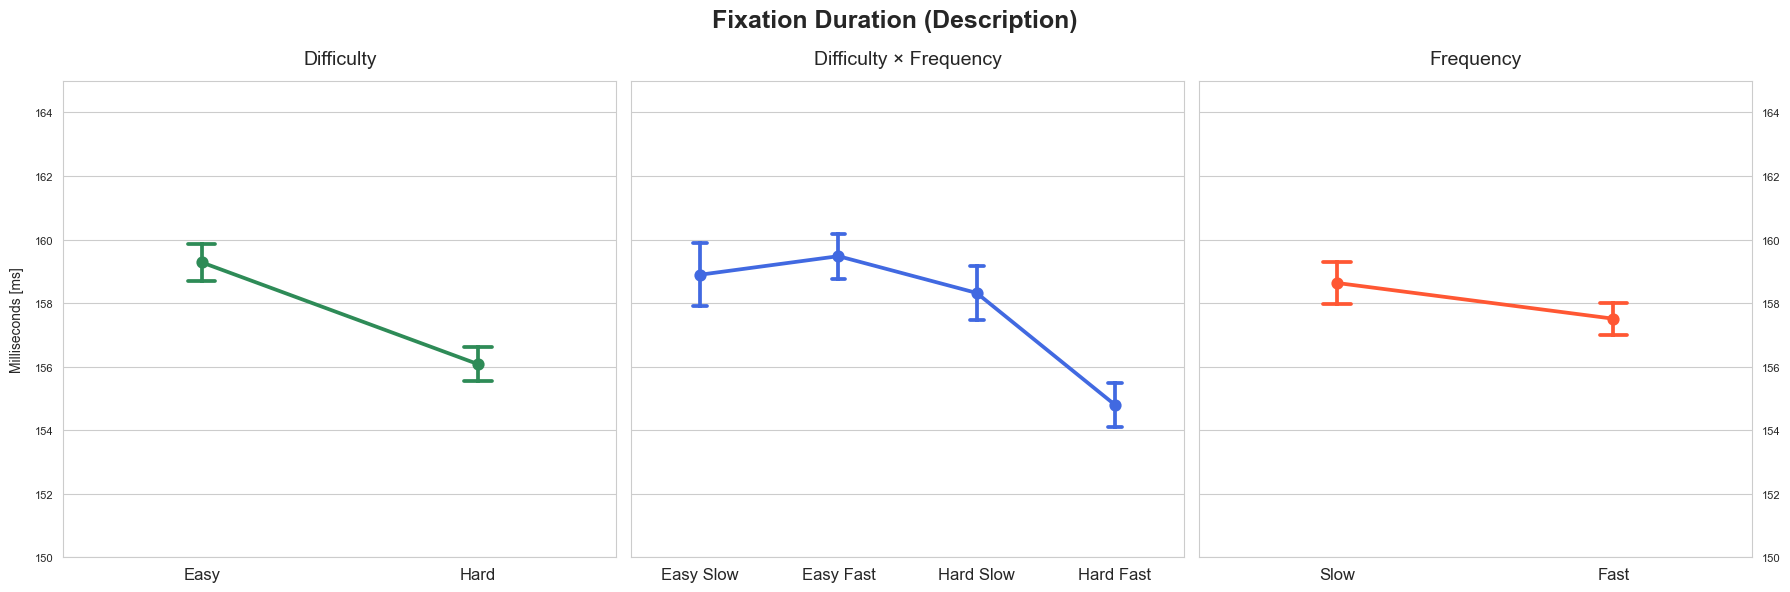

In [6]:
# Visualize plots
col = 'duration_Description'
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Fixation Duration (Description)', fontsize=18, weight='bold')
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df_long_expanded, x='difficulty', y=col, errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Milliseconds [ms]', fontsize=10, labelpad=8)
axes[0].set_ylim(150, 165)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=8)

# difficulty & frequency
sns.pointplot(ax=axes[1], data=df_long_expanded, x='condition', y=col, errorbar='se', markers='o', capsize=.1, color=colors[1],
              order=['Easy Slow', 'Easy Fast', 'Hard Slow', 'Hard Fast'])
axes[1].set_title('Difficulty × Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(150, 165)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelleft=False)

# frequency
sns.pointplot(ax=axes[2], data=df_long_expanded, x='frequency', y=col, errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[2].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_ylim(150, 165)
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=8, labelleft=False, labelright=True)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

##### Fixation Count - Description
Positive - Negative

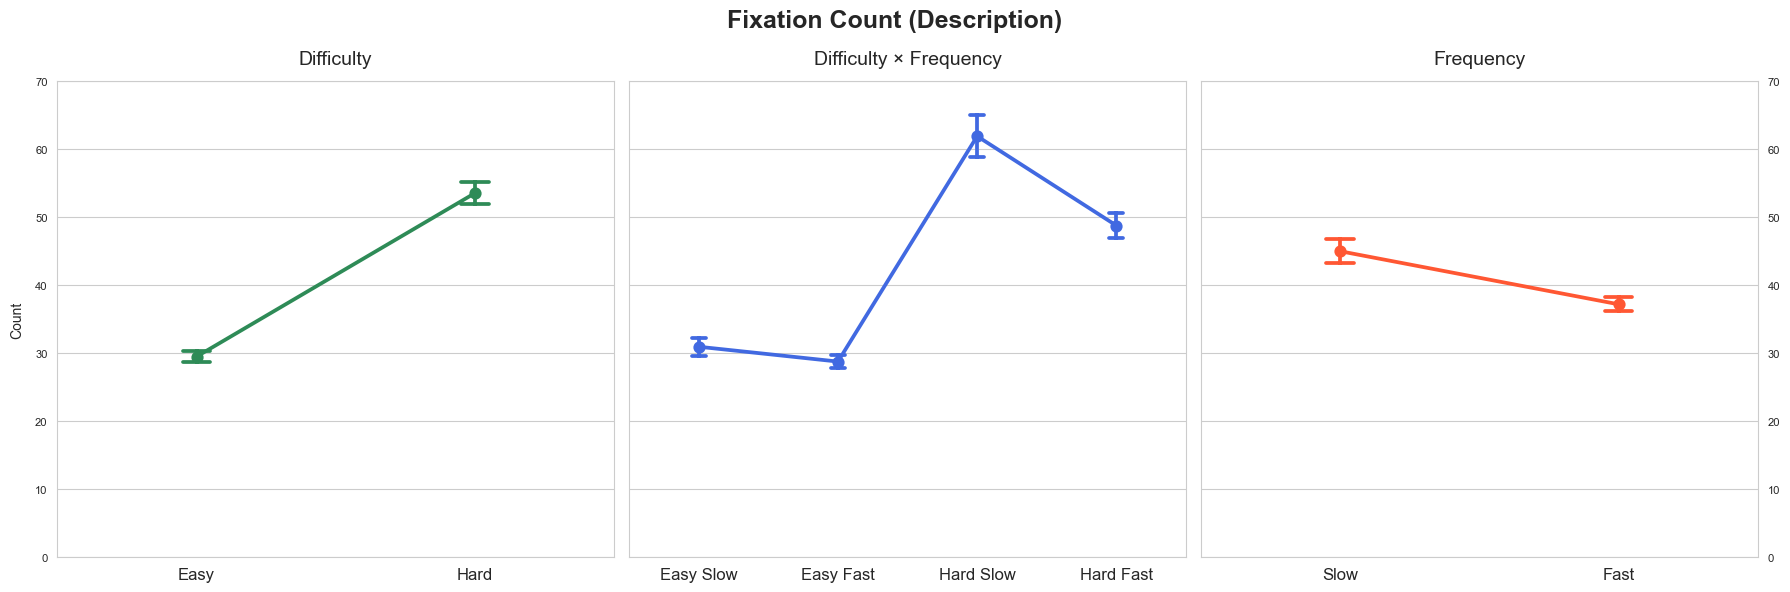

In [7]:
# Visualize plot
col = 'fix_count_Description'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Fixation Count (Description)', fontsize=18, weight='bold')
sns.set_style("whitegrid")
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df_long_expanded, x='difficulty', y=col, errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Count', fontsize=10, labelpad=8)
axes[0].set_ylim(0, 70)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=8)

# difficulty & frequency
sns.pointplot(ax=axes[1], data=df_long_expanded, x='condition', y=col, errorbar='se', markers='o', capsize=.1, color=colors[1],
              order=['Easy Slow', 'Easy Fast', 'Hard Slow', 'Hard Fast'])
axes[1].set_title('Difficulty × Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(0, 70)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelleft=False)

# frequency
sns.pointplot(ax=axes[2], data=df_long_expanded, x='frequency', y=col, errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[2].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_ylim(0, 70)
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=8, labelleft=False, labelright=True)


plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

##### Fixation Frequency - Actions
Positive - Positive

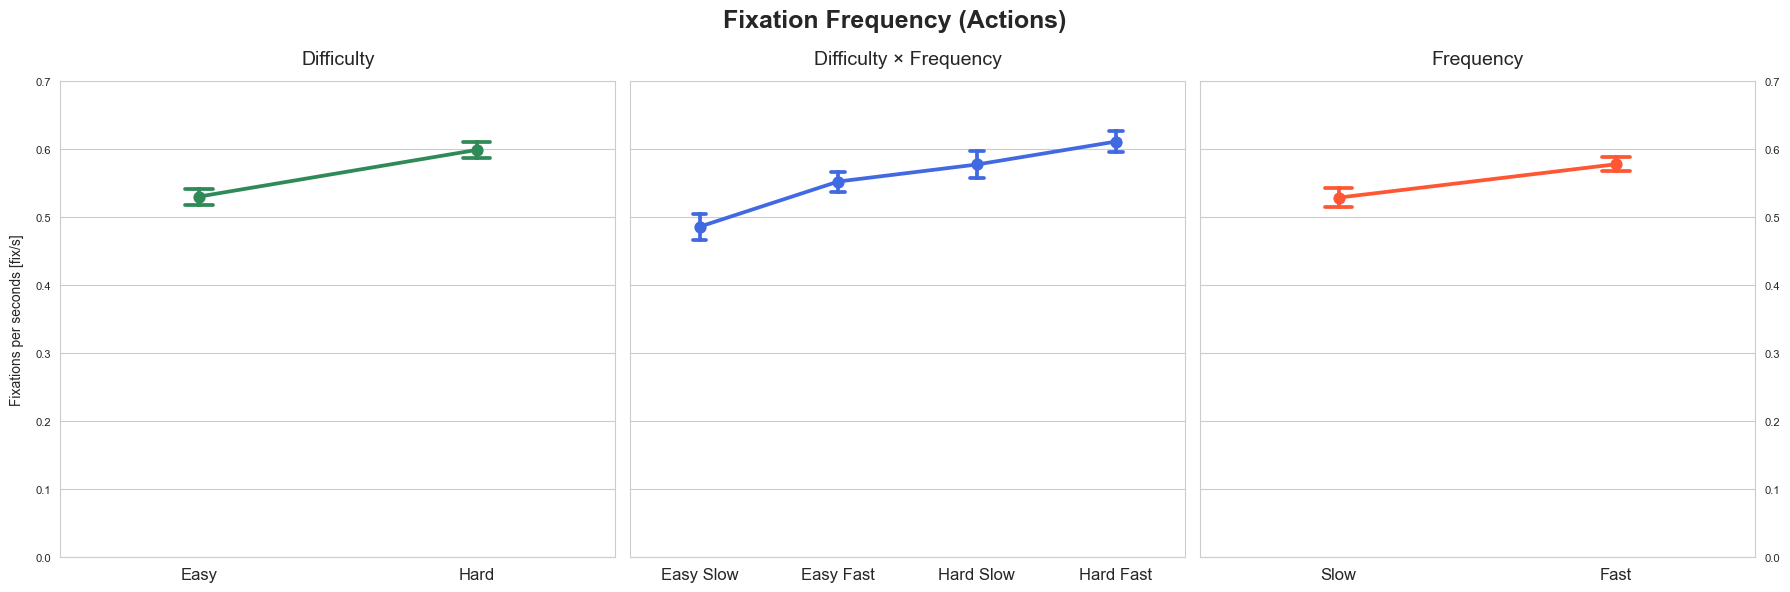

In [8]:
# Visualize plot
col = 'fix_freq_Actions'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Fixation Frequency (Actions)', fontsize=18, weight='bold')
sns.set_style("whitegrid")
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df_long_expanded, x='difficulty', y=col, errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Fixations per seconds [fix/s]', fontsize=10, labelpad=8)
axes[0].set_ylim(0, .7)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=8)

# difficulty & frequency
sns.pointplot(ax=axes[1], data=df_long_expanded, x='condition', y=col, errorbar='se', markers='o', capsize=.1, color=colors[1],
              order=['Easy Slow', 'Easy Fast', 'Hard Slow', 'Hard Fast'])
axes[1].set_title('Difficulty × Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(0, .7)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelleft=False)

# frequency
sns.pointplot(ax=axes[2], data=df_long_expanded, x='frequency', y=col, errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[2].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_ylim(0, .7)
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=8, labelleft=False, labelright=True)


plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

##### Time-to-1st- Fix - Actions
Positive - Negative

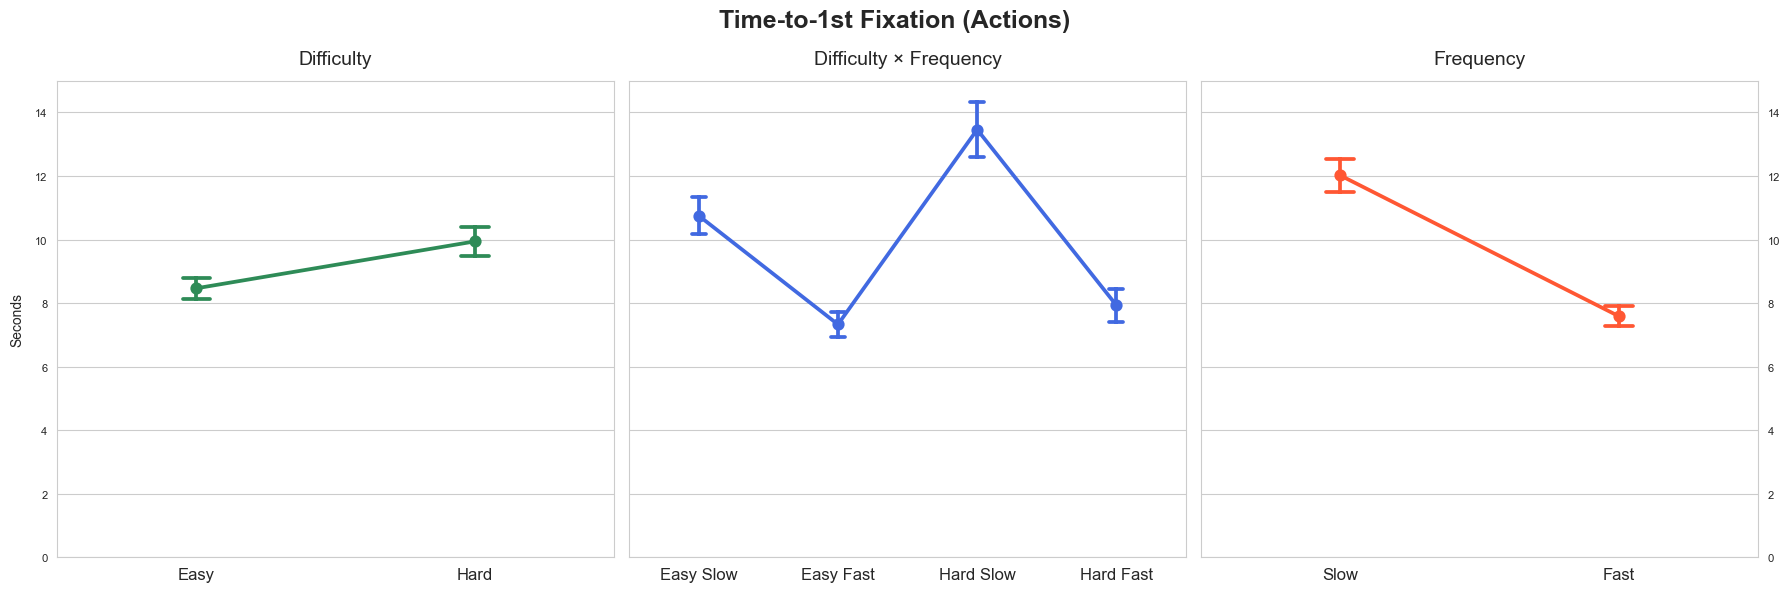

In [9]:
# Visualize plot
col = 'time_1st_fix_Actions'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Time-to-1st Fixation (Actions)', fontsize=18, weight='bold')
sns.set_style("whitegrid")
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df_long_expanded, x='difficulty', y=col, errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Seconds', fontsize=10, labelpad=8)
axes[0].set_ylim(0, 15)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=8)

# difficulty & frequency
sns.pointplot(ax=axes[1], data=df_long_expanded, x='condition', y=col, errorbar='se', markers='o', capsize=.1, color=colors[1],
              order=['Easy Slow', 'Easy Fast', 'Hard Slow', 'Hard Fast'])
axes[1].set_title('Difficulty × Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(0, 15)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelleft=False)

# frequency
sns.pointplot(ax=axes[2], data=df_long_expanded, x='frequency', y=col, errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[2].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_ylim(0, 15)
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=8, labelleft=False, labelright=True)


plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

##### Visit Count - Diagnostics
Positive - Positive

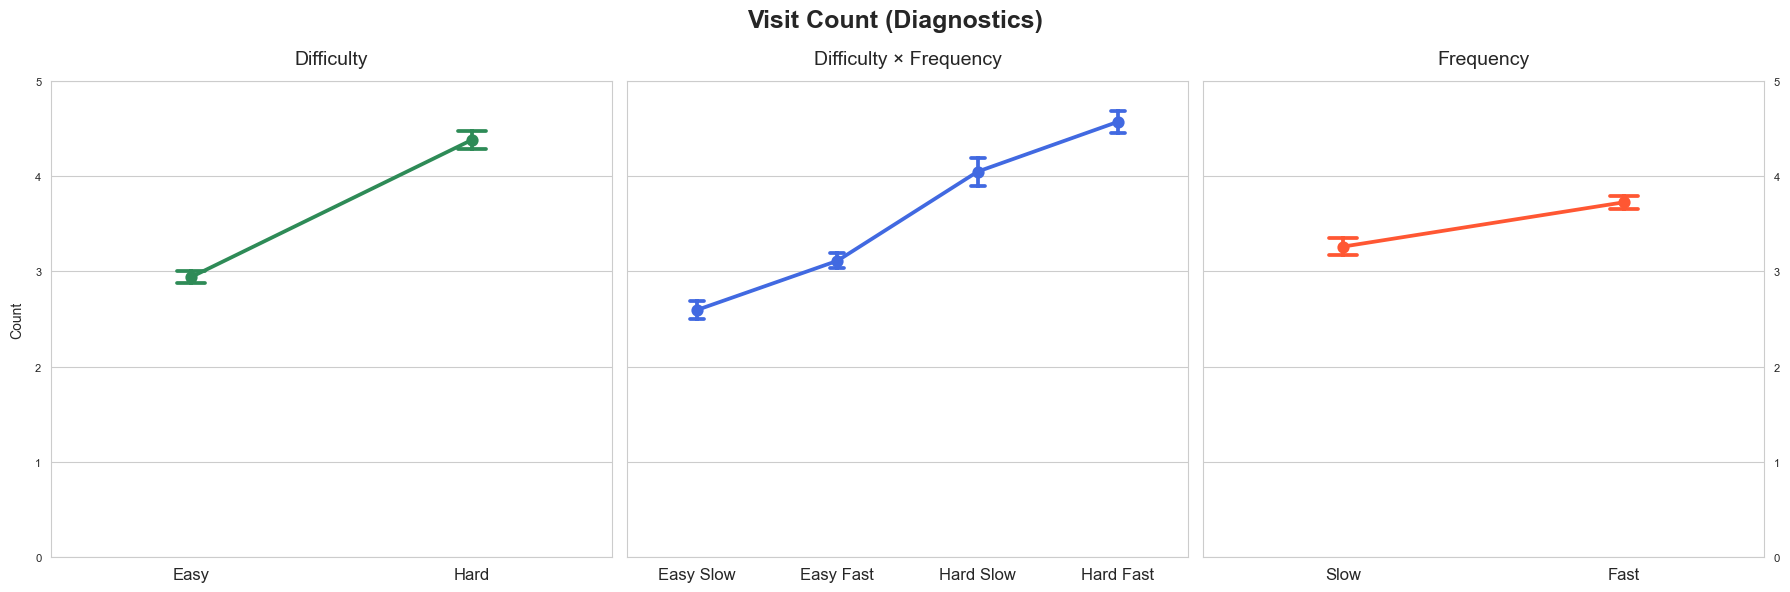

In [10]:
# Visualize plot
col = 'visit_count_Diagnostics'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Visit Count (Diagnostics)', fontsize=18, weight='bold')
sns.set_style("whitegrid")
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df_long_expanded, x='difficulty', y=col, errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Count', fontsize=10, labelpad=8)
axes[0].set_ylim(0, 5)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=8)

# difficulty & frequency
sns.pointplot(ax=axes[1], data=df_long_expanded, x='condition', y=col, errorbar='se', markers='o', capsize=.1, color=colors[1],
              order=['Easy Slow', 'Easy Fast', 'Hard Slow', 'Hard Fast'])
axes[1].set_title('Difficulty × Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(0, 5)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelleft=False)

# frequency
sns.pointplot(ax=axes[2], data=df_long_expanded, x='frequency', y=col, errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[2].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_ylim(0, 5)
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=8, labelleft=False, labelright=True)


plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

##### Visit Frequency - Ticket
Negative - Positive

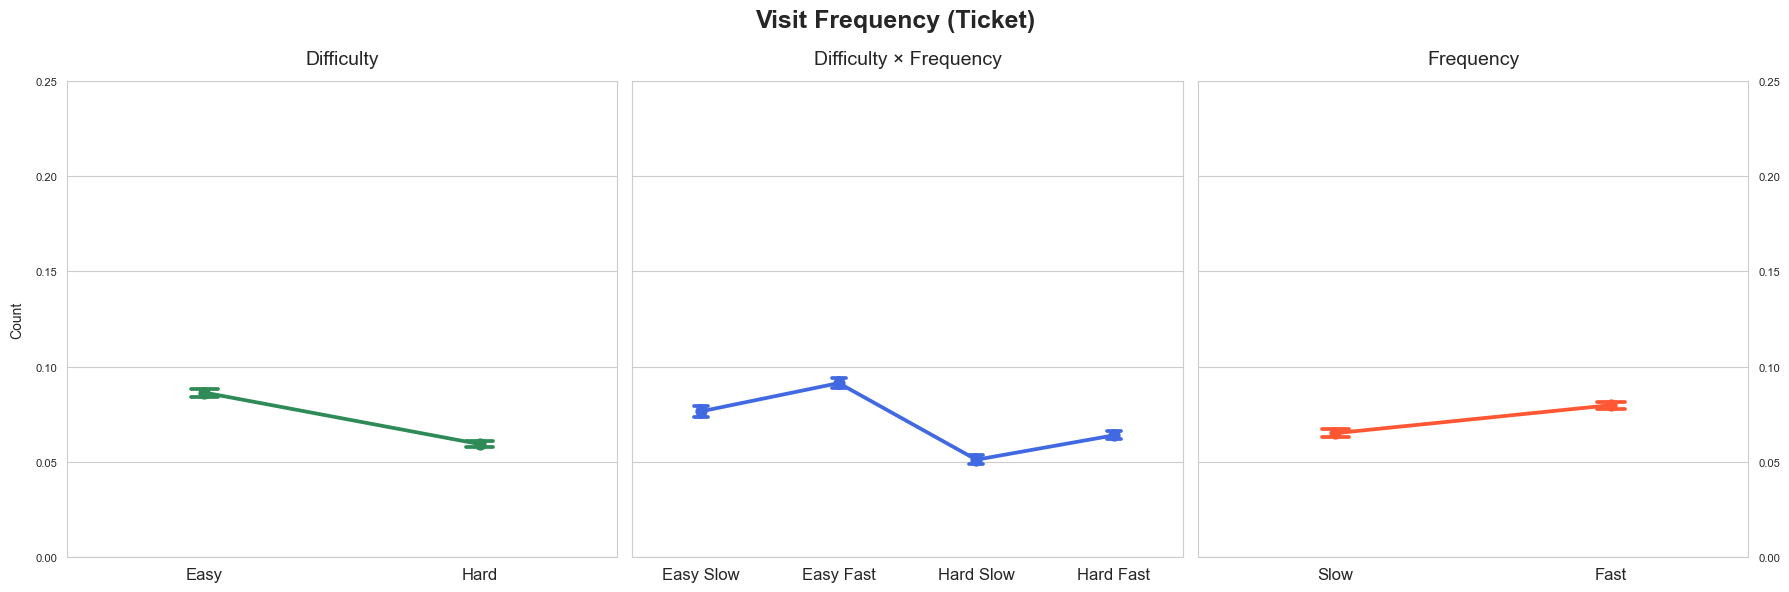

In [11]:
# Visualize plot
col = 'visit_freq_Ticket'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Visit Frequency (Ticket)', fontsize=18, weight='bold')
sns.set_style("whitegrid")
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df_long_expanded, x='difficulty', y=col, errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Count', fontsize=10, labelpad=8)
axes[0].set_ylim(0, .25)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=8)

# difficulty & frequency
sns.pointplot(ax=axes[1], data=df_long_expanded, x='condition', y=col, errorbar='se', markers='o', capsize=.1, color=colors[1],
              order=['Easy Slow', 'Easy Fast', 'Hard Slow', 'Hard Fast'])
axes[1].set_title('Difficulty × Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(0, .25)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelleft=False)

# frequency
sns.pointplot(ax=axes[2], data=df_long_expanded, x='frequency', y=col, errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[2].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_ylim(0, .25)
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=8, labelleft=False, labelright=True)


plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

##### Visit Length - Description
Positive - Negative

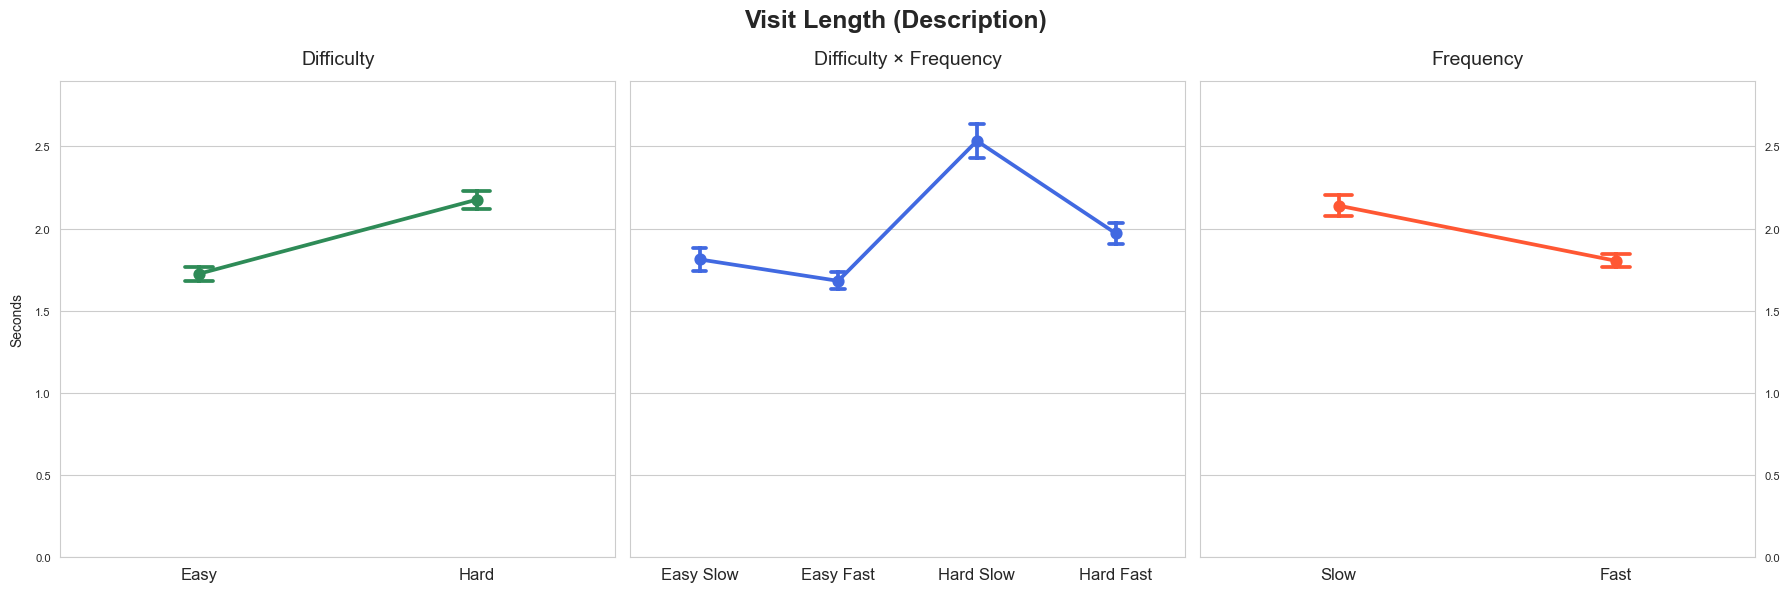

In [12]:
# Visualize plot
col = 'visit_len_Description'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Visit Length (Description)', fontsize=18, weight='bold')
sns.set_style("whitegrid")
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df_long_expanded, x='difficulty', y=col, errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Seconds', fontsize=10, labelpad=8)
axes[0].set_ylim(0, 2.9)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=8)

# difficulty & frequency
sns.pointplot(ax=axes[1], data=df_long_expanded, x='condition', y=col, errorbar='se', markers='o', capsize=.1, color=colors[1],
              order=['Easy Slow', 'Easy Fast', 'Hard Slow', 'Hard Fast'])
axes[1].set_title('Difficulty × Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(0, 2.9)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelleft=False)

# frequency
sns.pointplot(ax=axes[2], data=df_long_expanded, x='frequency', y=col, errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[2].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_ylim(0, 2.9)
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=8, labelleft=False, labelright=True)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

##### Dwell Time - Ticket
Negative - Positive

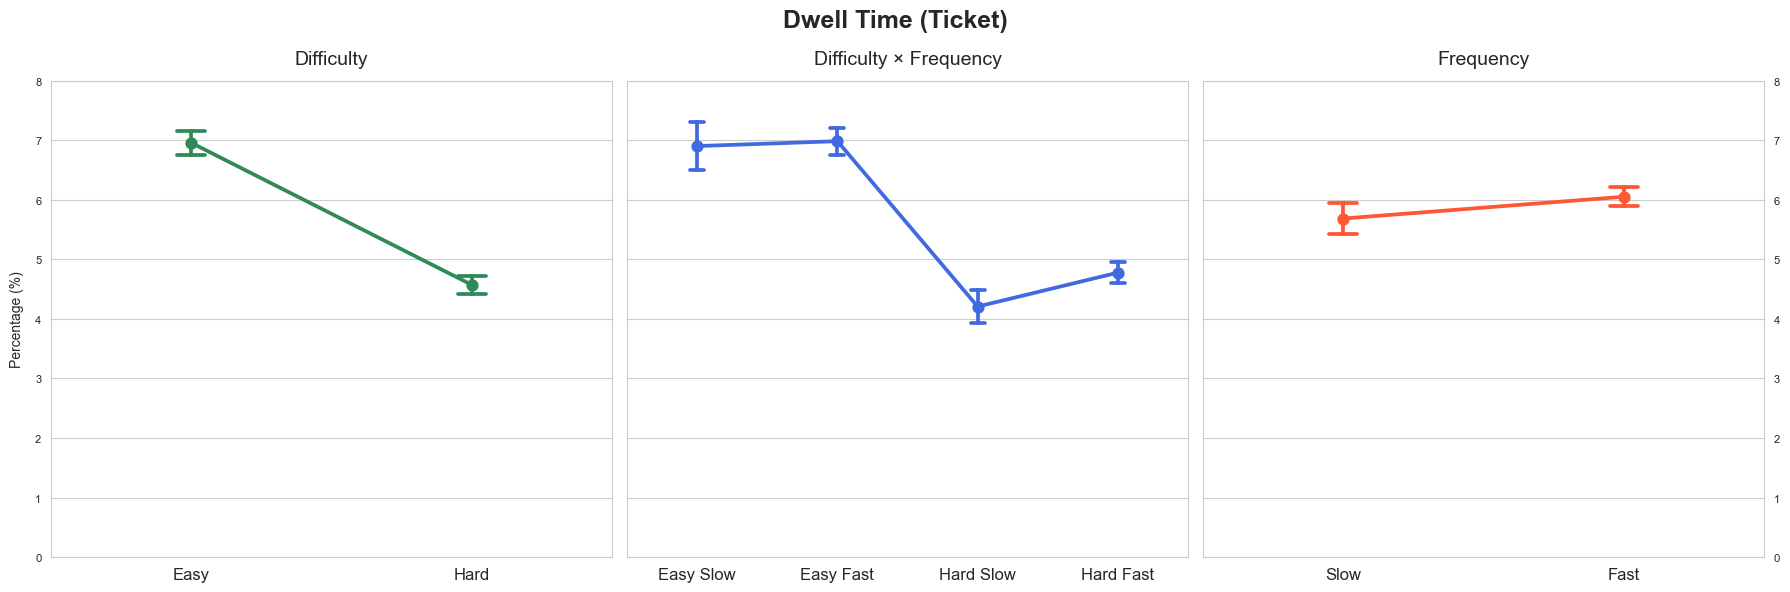

In [13]:
# Visualize plot
col = 'dwell_pct_Ticket'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Dwell Time (Ticket)', fontsize=18, weight='bold')
sns.set_style("whitegrid")
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df_long_expanded, x='difficulty', y=col, errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Percentage (%)', fontsize=10, labelpad=8)
axes[0].set_ylim(0, 8)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=8)

# difficulty & frequency
sns.pointplot(ax=axes[1], data=df_long_expanded, x='condition', y=col, errorbar='se', markers='o', capsize=.1, color=colors[1],
              order=['Easy Slow', 'Easy Fast', 'Hard Slow', 'Hard Fast'])
axes[1].set_title('Difficulty × Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(0, 8)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelleft=False)

# frequency
sns.pointplot(ax=axes[2], data=df_long_expanded, x='frequency', y=col, errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[2].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_ylim(0, 8)
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=8, labelleft=False, labelright=True)


plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

##### Stationary Entropy
Positive - Positive

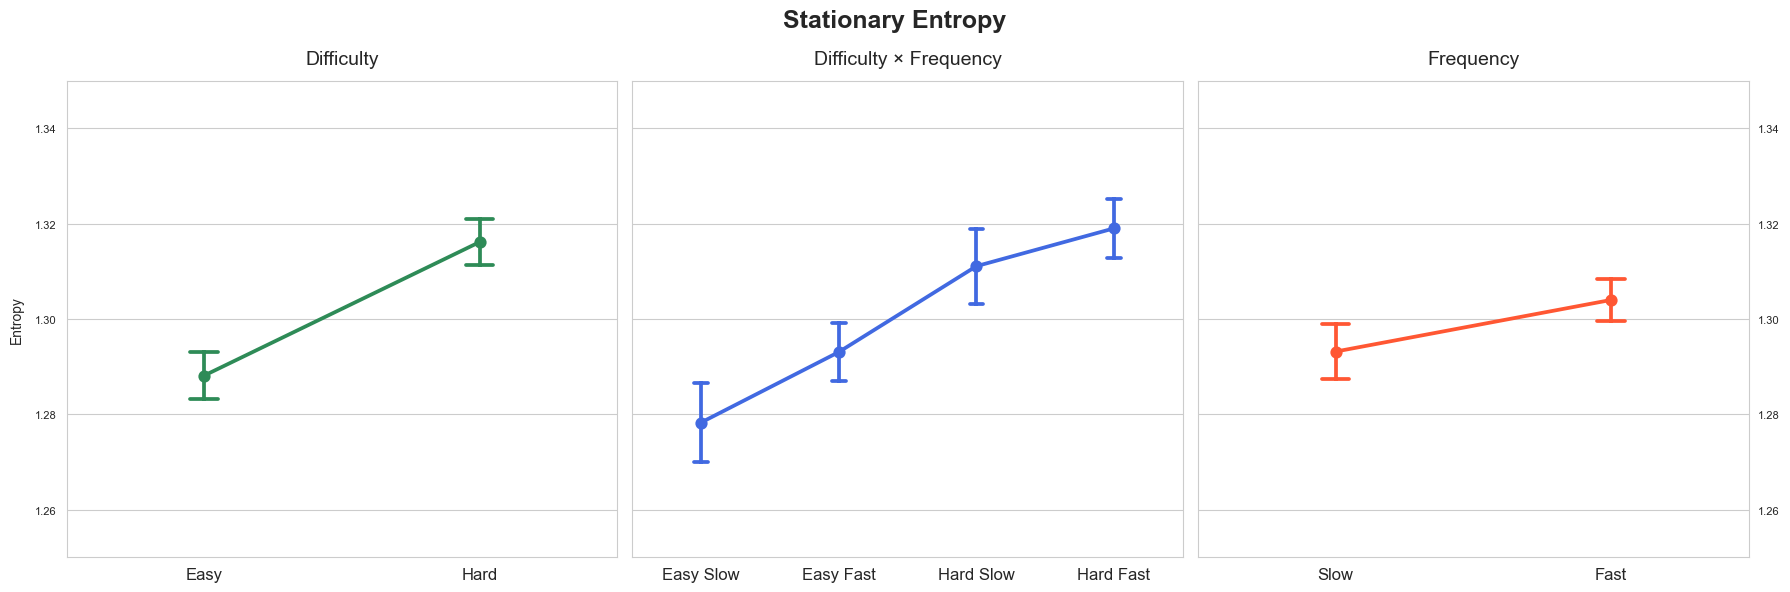

In [14]:
# Visualize plot
col = 'stat_entropy'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Stationary Entropy', fontsize=18, weight='bold')
sns.set_style("whitegrid")
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df_long_expanded, x='difficulty', y=col, errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Entropy', fontsize=10, labelpad=8)
axes[0].set_ylim(1.25, 1.35)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=8)

# difficulty & frequency
sns.pointplot(ax=axes[1], data=df_long_expanded, x='condition', y=col, errorbar='se', markers='o', capsize=.1, color=colors[1],
              order=['Easy Slow', 'Easy Fast', 'Hard Slow', 'Hard Fast'])
axes[1].set_title('Difficulty × Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(1.25, 1.35)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelleft=False)

# frequency
sns.pointplot(ax=axes[2], data=df_long_expanded, x='frequency', y=col, errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[2].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_ylim(1.25, 1.35)
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=8, labelleft=False, labelright=True)


plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

### 1. Descriptive Analysis (2)

##### Fixation Duration - Description
Negative - Negative

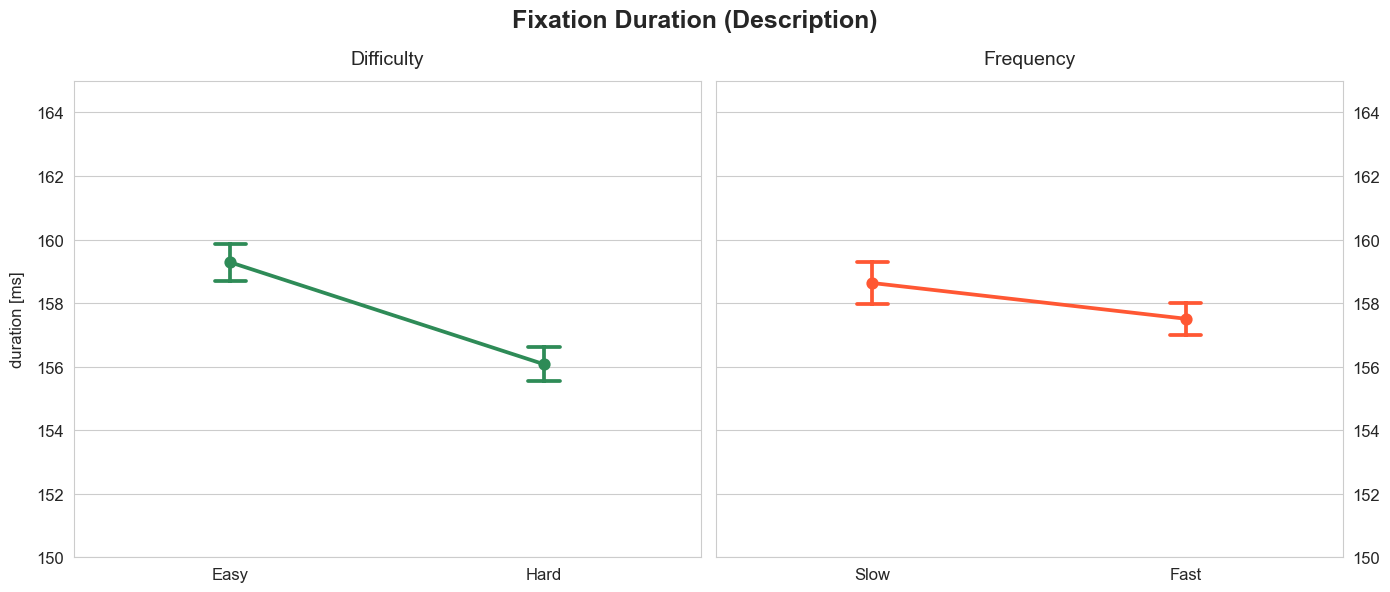

In [15]:
# Visualize plots
col = 'duration_Description'
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Fixation Duration (Description)', fontsize=18, weight='bold')
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df_long_expanded, x='difficulty', y=col, errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('duration [ms]', fontsize=12, labelpad=8)
axes[0].set_ylim(150, 165)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# frequency
sns.pointplot(ax=axes[1], data=df_long_expanded, x='frequency', y=col, errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[1].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(150, 165)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12, labelleft=False, labelright=True)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

##### Fixation Count - Description
Positive - Negative

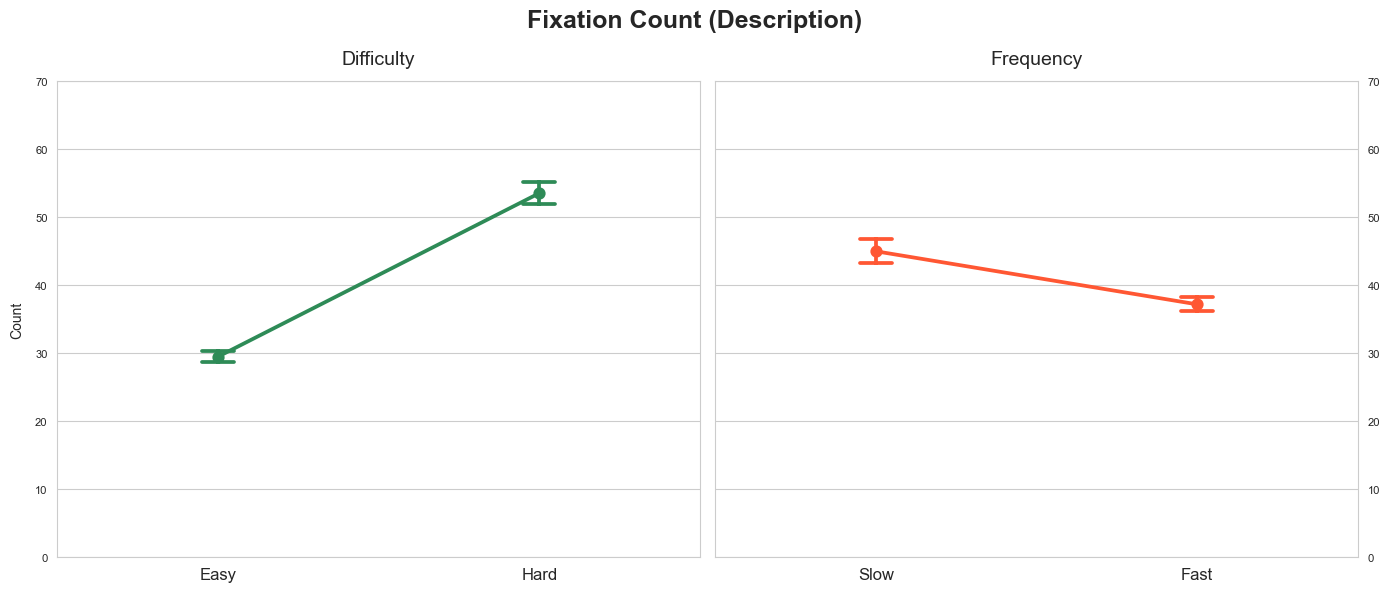

In [16]:
# Visualize plot
col = 'fix_count_Description'
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Fixation Count (Description)', fontsize=18, weight='bold')
sns.set_style("whitegrid")
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df_long_expanded, x='difficulty', y=col, errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Count', fontsize=10, labelpad=8)
axes[0].set_ylim(0, 70)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=8)

# frequency
sns.pointplot(ax=axes[1], data=df_long_expanded, x='frequency', y=col, errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[1].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(0, 70)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=8, labelleft=False, labelright=True)


plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

##### Fixation Frequency - Actions
Positive - Positive

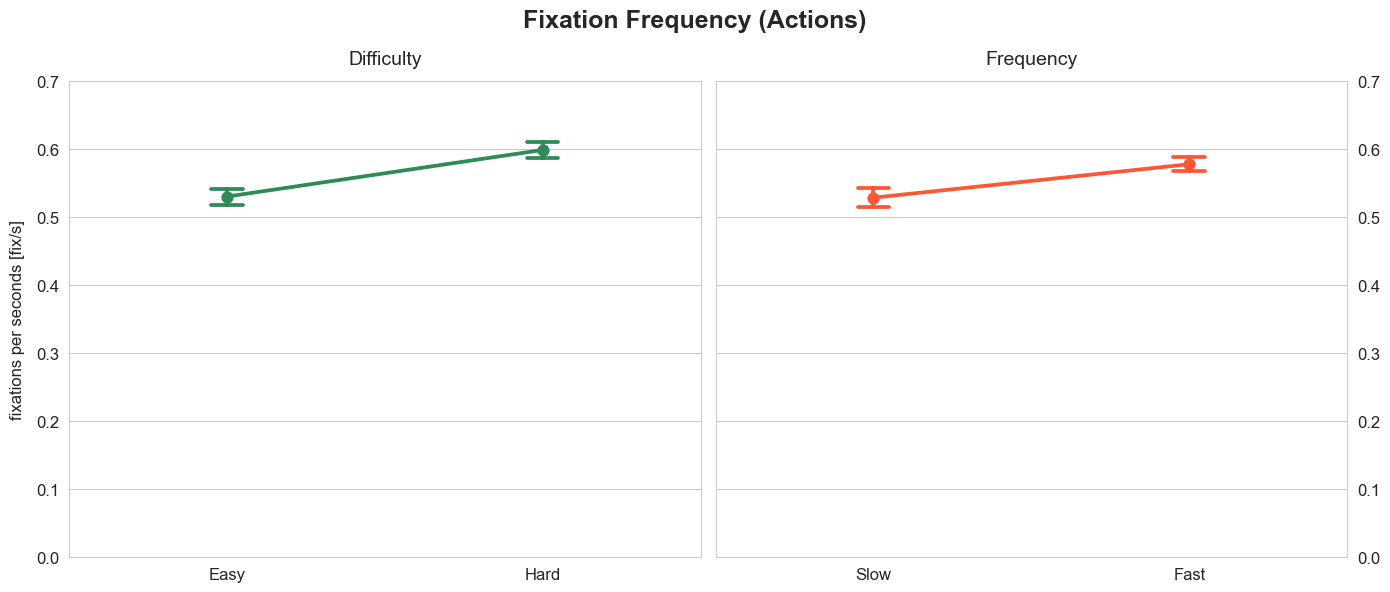

In [17]:
# Visualize plot
col = 'fix_freq_Actions'
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Fixation Frequency (Actions)', fontsize=18, weight='bold')
sns.set_style("whitegrid")
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df_long_expanded, x='difficulty', y=col, errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('fixations per seconds [fix/s]', fontsize=12, labelpad=8)
axes[0].set_ylim(0, .7)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# frequency
sns.pointplot(ax=axes[1], data=df_long_expanded, x='frequency', y=col, errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[1].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(0, .7)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12, labelleft=False, labelright=True)


plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

##### Time-to-1st- Fix - Actions
Positive - Negative

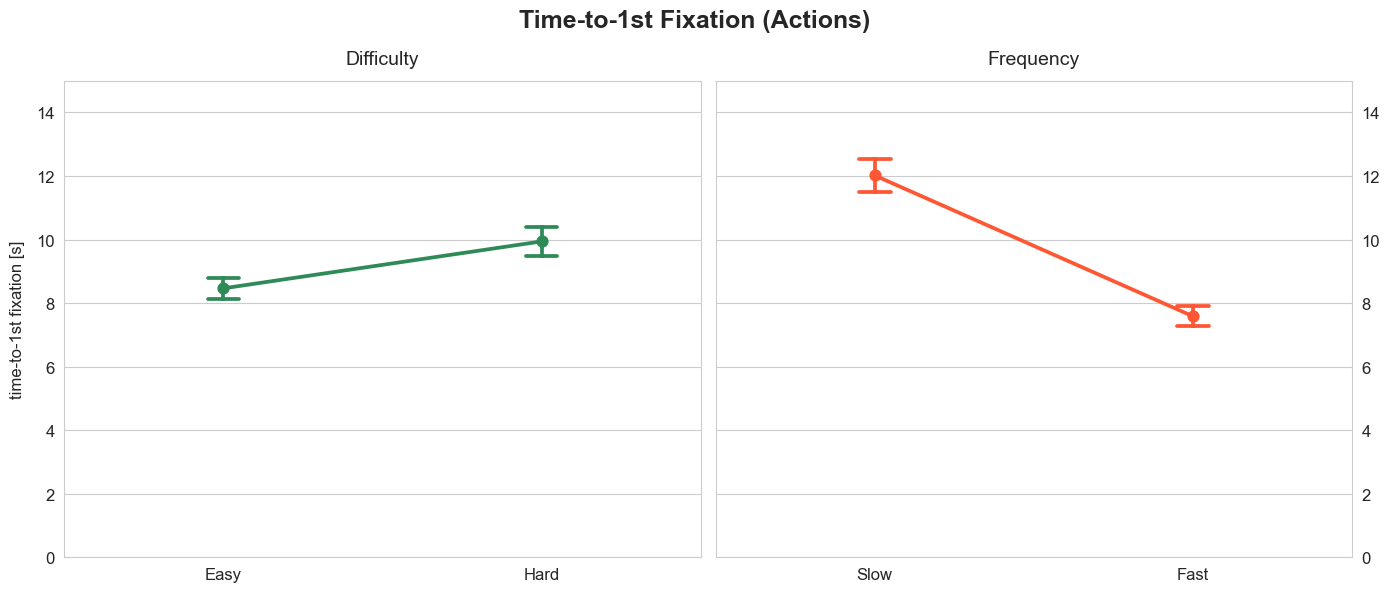

In [18]:
# Visualize plot
col = 'time_1st_fix_Actions'
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Time-to-1st Fixation (Actions)', fontsize=18, weight='bold')
sns.set_style("whitegrid")
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df_long_expanded, x='difficulty', y=col, errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('time-to-1st fixation [s]', fontsize=12, labelpad=8)
axes[0].set_ylim(0, 15)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# frequency
sns.pointplot(ax=axes[1], data=df_long_expanded, x='frequency', y=col, errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[1].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(0, 15)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12, labelleft=False, labelright=True)


plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

##### Visit Count - Diagnostics
Positive - Positive

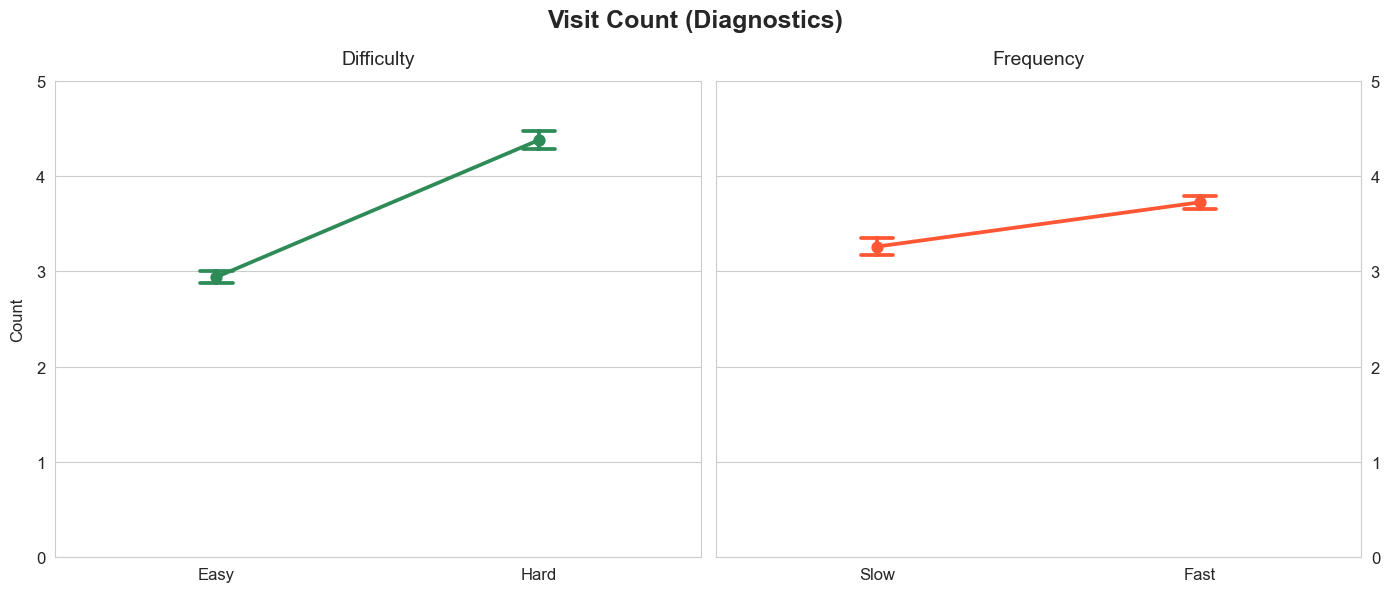

In [19]:
# Visualize plot
col = 'visit_count_Diagnostics'
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Visit Count (Diagnostics)', fontsize=18, weight='bold')
sns.set_style("whitegrid")
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df_long_expanded, x='difficulty', y=col, errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Count', fontsize=12, labelpad=8)
axes[0].set_ylim(0, 5)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# frequency
sns.pointplot(ax=axes[1], data=df_long_expanded, x='frequency', y=col, errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[1].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(0, 5)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12, labelleft=False, labelright=True)


plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

##### Visit Frequency - Ticket
Negative - Positive

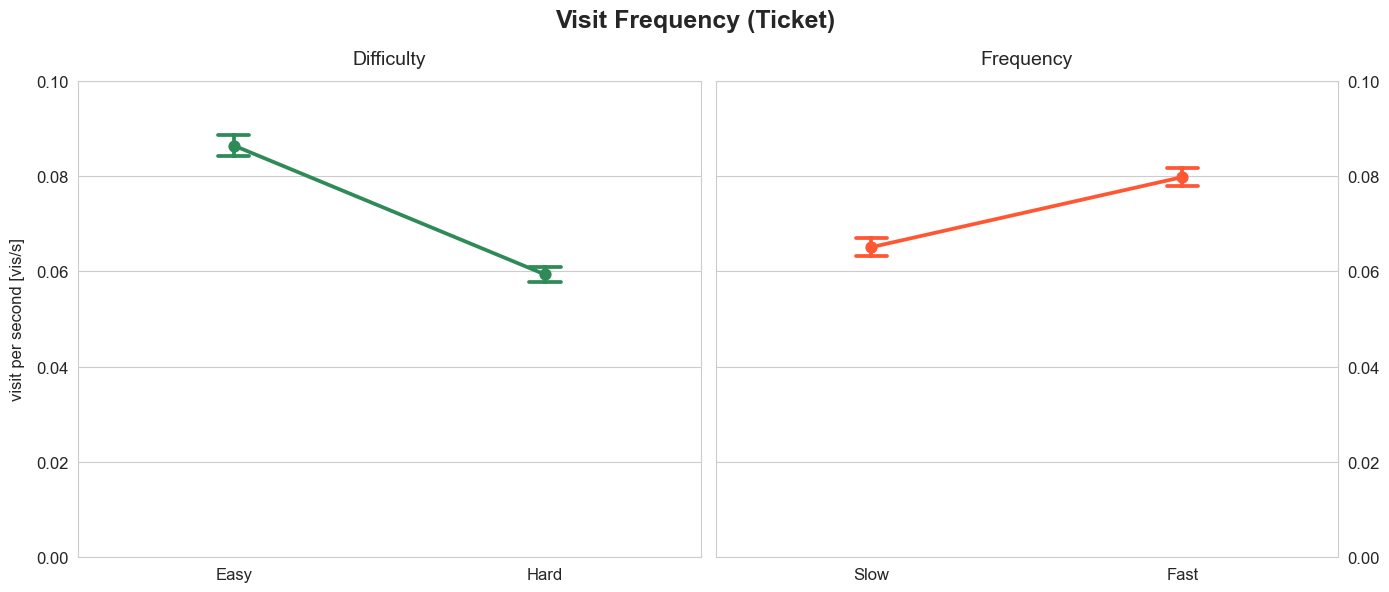

In [20]:
# Visualize plot
col = 'visit_freq_Ticket'
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Visit Frequency (Ticket)', fontsize=18, weight='bold')
sns.set_style("whitegrid")
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df_long_expanded, x='difficulty', y=col, errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('visit per second [vis/s]', fontsize=12, labelpad=8)
axes[0].set_ylim(0, .1)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# frequency
sns.pointplot(ax=axes[1], data=df_long_expanded, x='frequency', y=col, errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[1].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(0, .1)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12, labelleft=False, labelright=True)


plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

##### Visit Length - Description
Positive - Negative

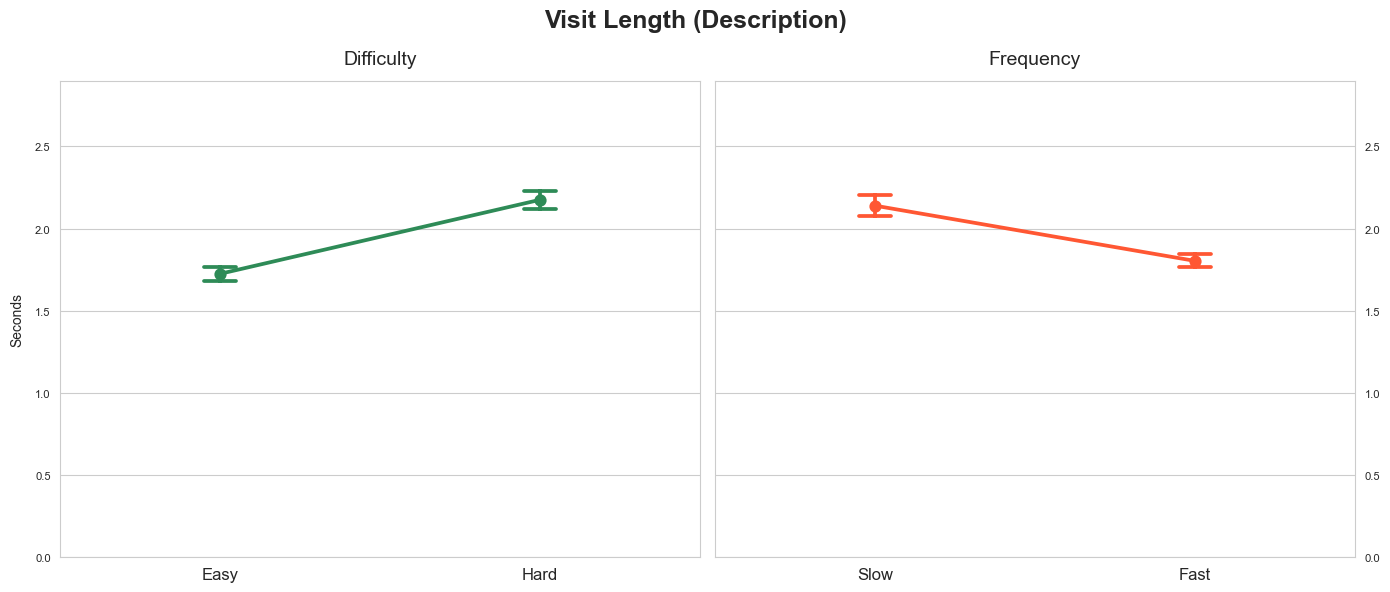

In [21]:
# Visualize plot
col = 'visit_len_Description'
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Visit Length (Description)', fontsize=18, weight='bold')
sns.set_style("whitegrid")
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df_long_expanded, x='difficulty', y=col, errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Seconds', fontsize=10, labelpad=8)
axes[0].set_ylim(0, 2.9)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=8)

# frequency
sns.pointplot(ax=axes[1], data=df_long_expanded, x='frequency', y=col, errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[1].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(0, 2.9)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=8, labelleft=False, labelright=True)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

##### Dwell Time - Ticket
Negative - Positive

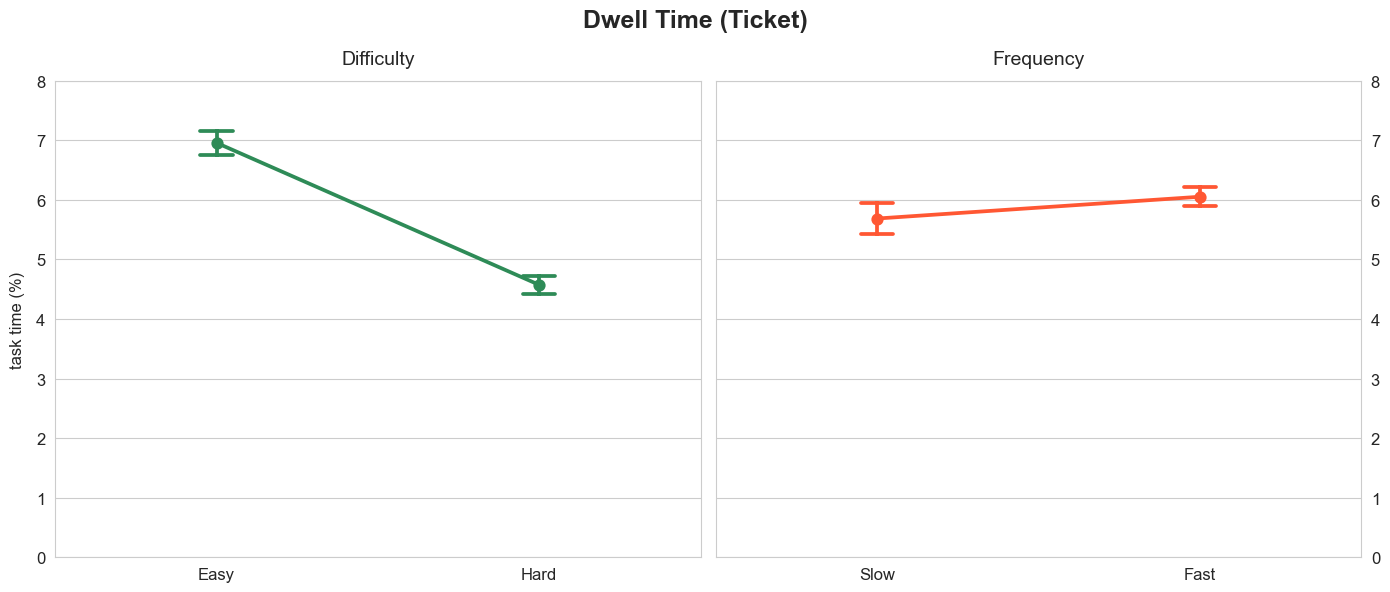

In [22]:
# Visualize plot
col = 'dwell_pct_Ticket'
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Dwell Time (Ticket)', fontsize=18, weight='bold')
sns.set_style("whitegrid")
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df_long_expanded, x='difficulty', y=col, errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('task time (%)', fontsize=12, labelpad=8)
axes[0].set_ylim(0, 8)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# frequency
sns.pointplot(ax=axes[1], data=df_long_expanded, x='frequency', y=col, errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[1].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(0, 8)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12, labelleft=False, labelright=True)


plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

##### Stationary Entropy
Positive - Positive

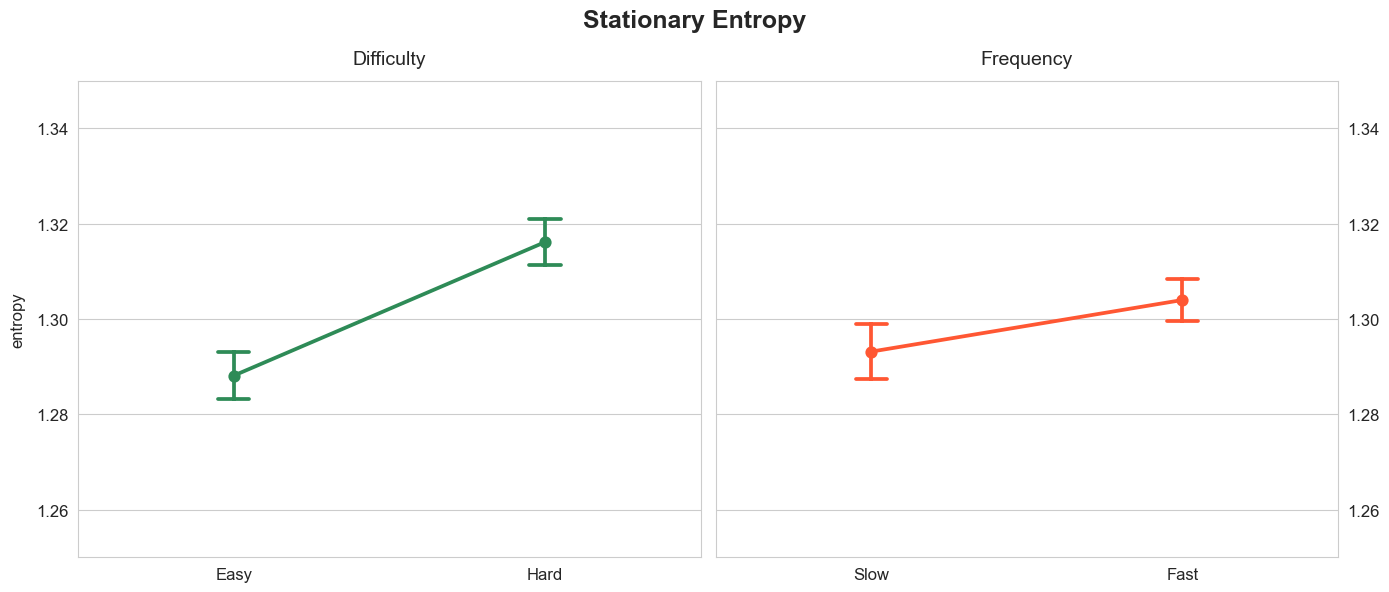

In [23]:
# Visualize plot
col = 'stat_entropy'
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Stationary Entropy', fontsize=18, weight='bold')
sns.set_style("whitegrid")
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df_long_expanded, x='difficulty', y=col, errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('entropy', fontsize=12, labelpad=8)
axes[0].set_ylim(1.25, 1.35)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# frequency
sns.pointplot(ax=axes[1], data=df_long_expanded, x='frequency', y=col, errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[1].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(1.25, 1.35)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12, labelleft=False, labelright=True)


plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

### 2. Inferential Analysis

##### Fixation Duration - Description

In [9]:
# Prepare Dataset
col = 'duration_Description'
aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_23364\1876754626.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()


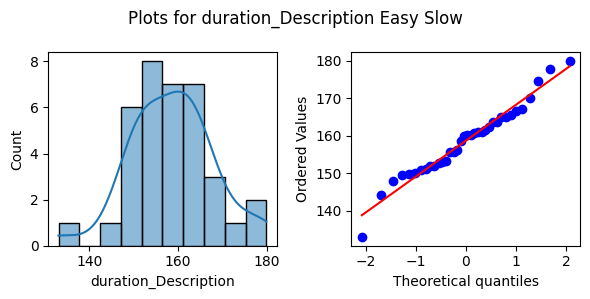

Shapiro-Wilk Test for duration_Description: p-value = 0.568945479142828


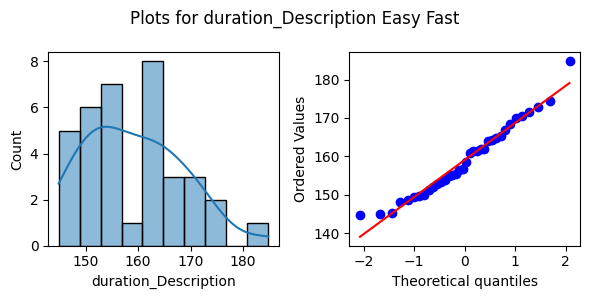

Shapiro-Wilk Test for duration_Description: p-value = 0.2834716761769852


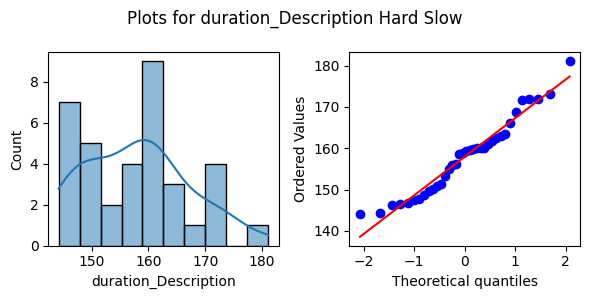

Shapiro-Wilk Test for duration_Description: p-value = 0.15102861206004037


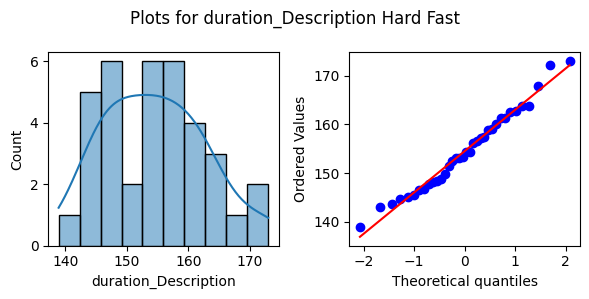

Shapiro-Wilk Test for duration_Description: p-value = 0.6420966253519327


In [10]:
# Check Normality
def check_normality(df, column, condition):
    df = df.query(f"condition == '{condition}'")

    plt.figure(figsize=(6, 3))
    plt.suptitle(f'Plots for {column} {condition}')
    # subplot for distribution plot
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], kde=True, bins=10)
    plt.xlabel(column)
    # subplot for QQ plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[column], dist="norm", plot=plt)
    plt.title('')

    plt.tight_layout()
    plt.show()

    # Perform the Shapiro-Wilk test
    stat, p_value = stats.shapiro(df[column])
    print(f"Shapiro-Wilk Test for {column}: p-value = {p_value}")

check_normality(aggregated_df, col, 'Easy Slow')
check_normality(aggregated_df, col, 'Easy Fast')
check_normality(aggregated_df, col, 'Hard Slow')
check_normality(aggregated_df, col, 'Hard Fast')

In [11]:
# Check Homoscedasticity
def check_homoscedasticity(df, factor, column):
    groups = df[factor].unique()
    data_groups = [df[df[factor] == group][column].dropna() for group in groups]
    stat, p_value = levene(*data_groups)

    print(f"{factor}: \tTest statistic = {stat:.4f}, p-value = {p_value:.4f}")

check_homoscedasticity(aggregated_df, 'difficulty', col)
check_homoscedasticity(aggregated_df, 'frequency', col)

difficulty: 	Test statistic = 0.1259, p-value = 0.7233
frequency: 	Test statistic = 0.0119, p-value = 0.9134


In [17]:
# Factorial AnovaRM
anova = AnovaRM(
    data=aggregated_df,
    depvar=col,    # Dependent variable
    subject='participant_id',          # Variable representing the subjects
    within=['difficulty', 'frequency'],# Within-subject factors
    aggregate_func='mean',
).fit()
anova.anova_table

F Value  Num DF  Den DF    Pr > F
difficulty            8.007011     1.0    17.0  0.011560
frequency             3.221241     1.0    17.0  0.090489
difficulty:frequency  5.477783     1.0    17.0  0.031711

In [18]:
# Post-hoc Pairwise Comparison (Bonferroni Correction)
posthoc_diff = pg.pairwise_tests(
    dv=col,
    within=['difficulty', 'frequency'],
    subject='participant_id',
    data=aggregated_df,
    padjust='bonf'
).rename(columns={'difficulty': 'Fixed'})
posthoc_freq = pg.pairwise_tests(
    dv=col,
    within=['frequency', 'difficulty'],
    subject='participant_id',
    data=aggregated_df,
    padjust='bonf'
).rename(columns={'frequency': 'Fixed'})
posthoc = pd.concat([posthoc_diff.tail(4), posthoc_freq.tail(2)])
posthoc

Contrast Fixed     A     B Paired Parametric         T   dof  \
0              difficulty     -  Easy  Hard   True       True  2.829666  17.0   
1               frequency     -  Slow  Fast   True       True  1.794781  17.0   
2  difficulty * frequency  Easy  Slow  Fast   True       True -0.318389  17.0   
3  difficulty * frequency  Hard  Slow  Fast   True       True  3.400281  17.0   
2  frequency * difficulty  Slow  Easy  Hard   True       True  0.455715  17.0   
3  frequency * difficulty  Fast  Easy  Hard   True       True  5.413054  17.0   

  alternative     p-unc    p-corr p-adjust     BF10    hedges  
0   two-sided  0.011560       NaN      NaN    4.688  0.320374  
1   two-sided  0.090489       NaN      NaN    0.917  0.184590  
2   two-sided  0.754068  1.000000     bonf    0.254 -0.047119  
3   two-sided  0.003406  0.006811     bonf   13.064  0.416278  
2   two-sided  0.654362  1.000000     bonf    0.267  0.082080  
3   two-sided  0.000047  0.000093     bonf  555.974  0.527765

##### Fixation Count - Description

In [19]:
# Prepare Dataset
col = 'fix_count_Description'
aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_84\2824293983.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()


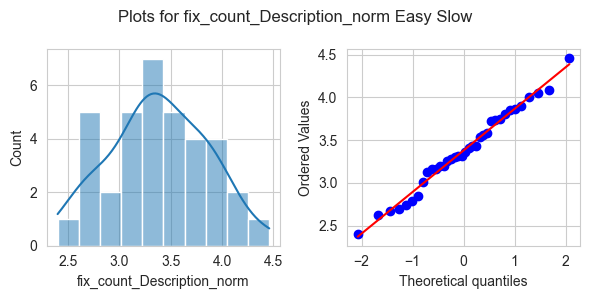

Shapiro-Wilk Test for fix_count_Description_norm: p-value = 0.9093380172403299


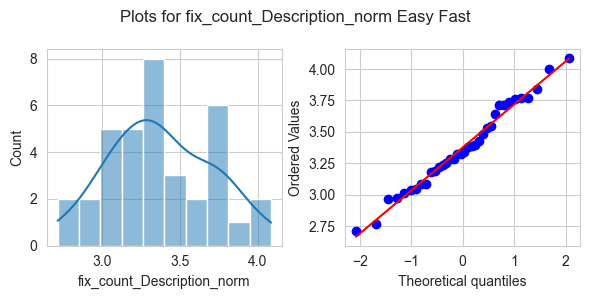

Shapiro-Wilk Test for fix_count_Description_norm: p-value = 0.7742971652727695


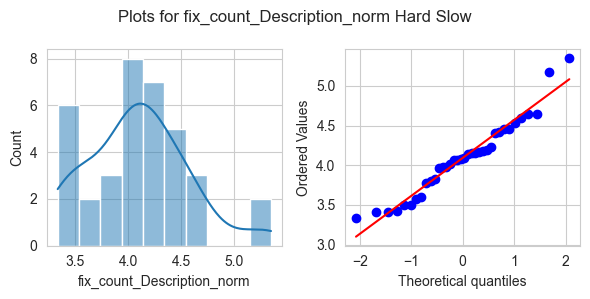

Shapiro-Wilk Test for fix_count_Description_norm: p-value = 0.14309106757593937


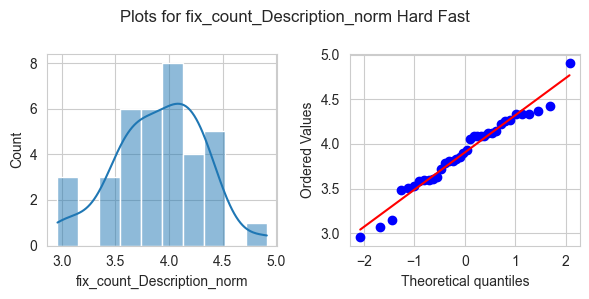

Shapiro-Wilk Test for fix_count_Description_norm: p-value = 0.4516288652048323


In [20]:
# Normalize (log) and Check Normality
aggregated_df[f'{col}_norm'] = np.log(aggregated_df[col] + 1)

check_normality(aggregated_df, f'{col}_norm', 'Easy Slow')
check_normality(aggregated_df, f'{col}_norm', 'Easy Fast')
check_normality(aggregated_df, f'{col}_norm', 'Hard Slow')
check_normality(aggregated_df, f'{col}_norm', 'Hard Fast')

In [21]:
# Check Homoscedasticity
check_homoscedasticity(aggregated_df, 'difficulty', f'{col}_norm')
check_homoscedasticity(aggregated_df, 'frequency', f'{col}_norm')

difficulty: 	Test statistic = 0.2944, p-value = 0.5882
frequency: 	Test statistic = 3.8911, p-value = 0.0505


In [22]:
# Factorial AnovaRM
anova = AnovaRM(
    data=aggregated_df,
    depvar=f'{col}_norm',    # Dependent variable
    subject='participant_id',          # Variable representing the subjects
    within=['difficulty', 'frequency'],# Within-subject factors
    aggregate_func='mean',
).fit()
anova.anova_table

F Value  Num DF  Den DF        Pr > F
difficulty            228.498228     1.0    17.0  2.739265e-11
frequency               3.305650     1.0    17.0  8.670703e-02
difficulty:frequency    7.452605     1.0    17.0  1.425433e-02

In [23]:
# Post-hoc Pairwise Comparison (Bonferroni Correction)
posthoc_diff = pg.pairwise_tests(
    dv=col,
    within=['difficulty', 'frequency'],
    subject='participant_id',
    data=aggregated_df,
    padjust='bonf'
).rename(columns={'difficulty': 'Fixed'})
posthoc_freq = pg.pairwise_tests(
    dv=col,
    within=['frequency', 'difficulty'],
    subject='participant_id',
    data=aggregated_df,
    padjust='bonf'
).rename(columns={'frequency': 'Fixed'})
posthoc = pd.concat([posthoc_diff.tail(4), posthoc_freq.tail(2)])
posthoc

Contrast Fixed     A     B Paired Parametric         T   dof  \
0              difficulty     -  Easy  Hard   True       True -9.092512  17.0   
1               frequency     -  Slow  Fast   True       True  2.502018  17.0   
2  difficulty * frequency  Easy  Slow  Fast   True       True  0.838307  17.0   
3  difficulty * frequency  Hard  Slow  Fast   True       True  2.638870  17.0   
2  frequency * difficulty  Slow  Easy  Hard   True       True -7.023860  17.0   
3  frequency * difficulty  Fast  Easy  Hard   True       True -8.080392  17.0   

  alternative         p-unc        p-corr p-adjust       BF10    hedges  
0   two-sided  6.126682e-08           NaN      NaN  2.302e+05 -1.813692  
1   two-sided  2.285319e-02           NaN      NaN      2.686  0.488622  
2   two-sided  4.134907e-01  8.269814e-01     bonf      0.331  0.163674  
3   two-sided  1.723449e-02  3.446898e-02     bonf      3.378  0.593593  
2   two-sided  2.046775e-06  4.093550e-06     bonf   9294.187 -1.648294  
3   two-sided  3.184519e-07  6.369038e-07     bonf  5.072e+04 -1.583569

##### Fixation Frequency - Actions

In [24]:
# Prepare Dataset
col = 'fix_freq_Actions'
aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_84\3844697616.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()


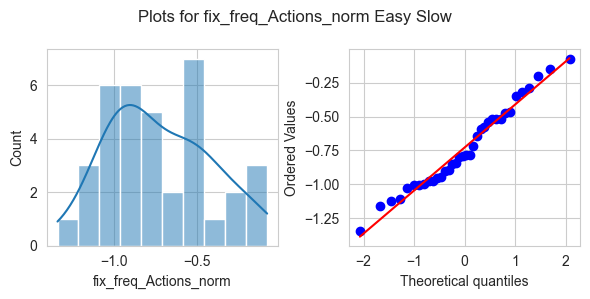

Shapiro-Wilk Test for fix_freq_Actions_norm: p-value = 0.43320295807853476


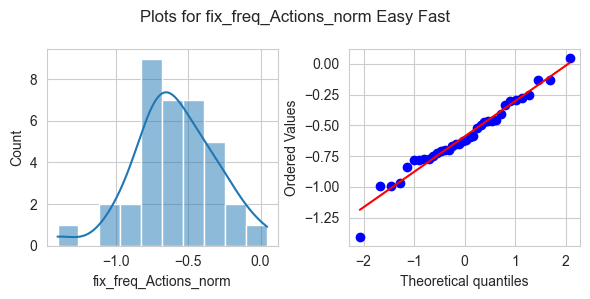

Shapiro-Wilk Test for fix_freq_Actions_norm: p-value = 0.6014911941701042


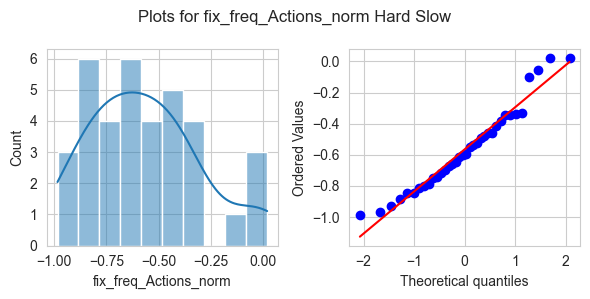

Shapiro-Wilk Test for fix_freq_Actions_norm: p-value = 0.15276639192302005


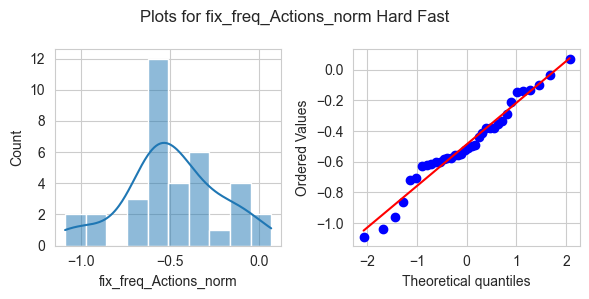

Shapiro-Wilk Test for fix_freq_Actions_norm: p-value = 0.41160293684586224


In [25]:
# Normalize (boxcox) and Check Normality
aggregated_df[f'{col}_norm'], _ = stats.boxcox(aggregated_df[col])

check_normality(aggregated_df, f'{col}_norm', 'Easy Slow')
check_normality(aggregated_df, f'{col}_norm', 'Easy Fast')
check_normality(aggregated_df, f'{col}_norm', 'Hard Slow')
check_normality(aggregated_df, f'{col}_norm', 'Hard Fast')

In [26]:
# Check Homoscedasticity
check_homoscedasticity(aggregated_df, 'difficulty', f'{col}_norm')
check_homoscedasticity(aggregated_df, 'frequency', f'{col}_norm')

difficulty: 	Test statistic = 1.6629, p-value = 0.1993
frequency: 	Test statistic = 1.2837, p-value = 0.2591


In [27]:
# Factorial AnovaRM
anova = AnovaRM(
    data=aggregated_df,
    depvar=f'{col}_norm',    # Dependent variable
    subject='participant_id',          # Variable representing the subjects
    within=['difficulty', 'frequency'],# Within-subject factors
    aggregate_func='mean',
).fit()
anova.anova_table

F Value  Num DF  Den DF    Pr > F
difficulty            14.928555     1.0    17.0  0.001246
frequency             10.011049     1.0    17.0  0.005670
difficulty:frequency   0.857613     1.0    17.0  0.367369

In [28]:
# Post-hoc Pairwise Comparison (Bonferroni Correction)
posthoc_diff = pg.pairwise_tests(
    dv=col,
    within=['difficulty', 'frequency'],
    subject='participant_id',
    data=aggregated_df,
    padjust='bonf'
).rename(columns={'difficulty': 'Fixed'})
posthoc_freq = pg.pairwise_tests(
    dv=col,
    within=['frequency', 'difficulty'],
    subject='participant_id',
    data=aggregated_df,
    padjust='bonf'
).rename(columns={'frequency': 'Fixed'})
posthoc = pd.concat([posthoc_diff.tail(4), posthoc_freq.tail(2)])
posthoc

Contrast Fixed     A     B Paired Parametric         T   dof  \
0              difficulty     -  Easy  Hard   True       True -3.577411  17.0   
1               frequency     -  Slow  Fast   True       True -3.062670  17.0   
2  difficulty * frequency  Easy  Slow  Fast   True       True -2.816413  17.0   
3  difficulty * frequency  Hard  Slow  Fast   True       True -1.575002  17.0   
2  frequency * difficulty  Slow  Easy  Hard   True       True -2.311376  17.0   
3  frequency * difficulty  Fast  Easy  Hard   True       True -3.720898  17.0   

  alternative     p-unc    p-corr p-adjust    BF10    hedges  
0   two-sided  0.002320       NaN      NaN  18.122 -0.525558  
1   two-sided  0.007046       NaN      NaN   7.077 -0.429693  
2   two-sided  0.011887  0.023775     bonf   4.582 -0.463085  
3   two-sided  0.133682  0.267363     bonf   0.689 -0.318520  
2   two-sided  0.033614  0.067229     bonf   1.972 -0.585558  
3   two-sided  0.001699  0.003398     bonf  23.669 -0.387050

##### Time-to-1st Fix - Actions

In [29]:
# Prepare Dataset
col = 'time_1st_fix_Actions'
aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_84\3378826165.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()


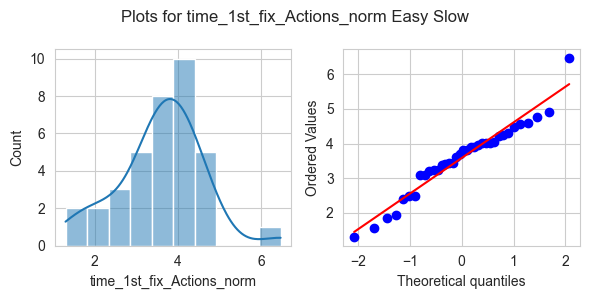

Shapiro-Wilk Test for time_1st_fix_Actions_norm: p-value = 0.18675164635211544


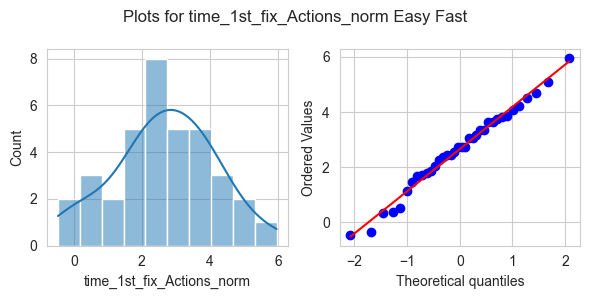

Shapiro-Wilk Test for time_1st_fix_Actions_norm: p-value = 0.9339779610418111


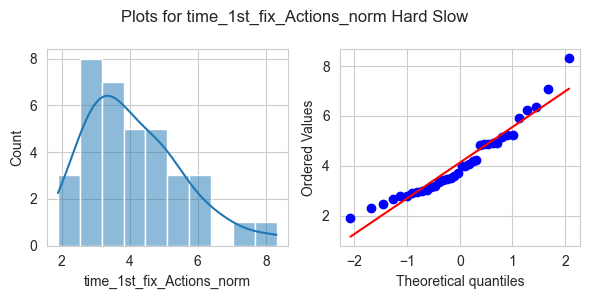

Shapiro-Wilk Test for time_1st_fix_Actions_norm: p-value = 0.039249859934459765


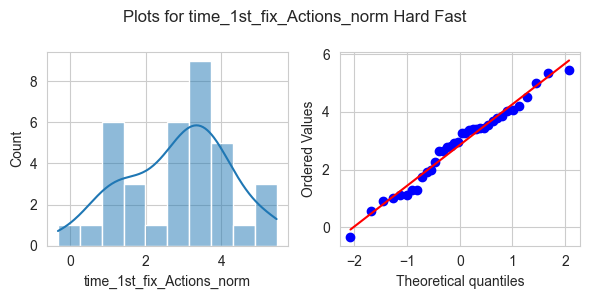

Shapiro-Wilk Test for time_1st_fix_Actions_norm: p-value = 0.552500593040122


In [30]:
# Normalize (boxcox) and Check Normality
aggregated_df[f'{col}_norm'], _ = stats.boxcox(aggregated_df[col])

check_normality(aggregated_df, f'{col}_norm', 'Easy Slow')
check_normality(aggregated_df, f'{col}_norm', 'Easy Fast')
check_normality(aggregated_df, f'{col}_norm', 'Hard Slow')
check_normality(aggregated_df, f'{col}_norm', 'Hard Fast')

In [31]:
# Check Homoscedasticity
check_homoscedasticity(aggregated_df, 'difficulty', f'{col}_norm')
check_homoscedasticity(aggregated_df, 'frequency', f'{col}_norm')

difficulty: 	Test statistic = 0.3583, p-value = 0.5504
frequency: 	Test statistic = 2.0690, p-value = 0.1525


In [32]:
# Factorial AnovaRM
anova = AnovaRM(
    data=aggregated_df,
    depvar=f'{col}_norm',    # Dependent variable
    subject='participant_id',          # Variable representing the subjects
    within=['difficulty', 'frequency'],# Within-subject factors
    aggregate_func='mean',
).fit()
anova.anova_table

F Value  Num DF  Den DF    Pr > F
difficulty             6.249714     1.0    17.0  0.022950
frequency             14.345349     1.0    17.0  0.001470
difficulty:frequency   0.967083     1.0    17.0  0.339199

In [33]:
# Post-hoc Pairwise Comparison (Bonferroni Correction)
posthoc_diff = pg.pairwise_tests(
    dv=col,
    within=['difficulty', 'frequency'],
    subject='participant_id',
    data=aggregated_df,
    padjust='bonf'
).rename(columns={'difficulty': 'Fixed'})
posthoc_freq = pg.pairwise_tests(
    dv=col,
    within=['frequency', 'difficulty'],
    subject='participant_id',
    data=aggregated_df,
    padjust='bonf'
).rename(columns={'frequency': 'Fixed'})
posthoc = pd.concat([posthoc_diff.tail(4), posthoc_freq.tail(2)])
posthoc

Contrast Fixed     A     B Paired Parametric         T   dof  \
0              difficulty     -  Easy  Hard   True       True -3.171547  17.0   
1               frequency     -  Slow  Fast   True       True  3.410792  17.0   
2  difficulty * frequency  Easy  Slow  Fast   True       True  3.632858  17.0   
3  difficulty * frequency  Hard  Slow  Fast   True       True  2.839636  17.0   
2  frequency * difficulty  Slow  Easy  Hard   True       True -3.006947  17.0   
3  frequency * difficulty  Fast  Easy  Hard   True       True -0.522167  17.0   

  alternative     p-unc    p-corr p-adjust    BF10    hedges  
0   two-sided  0.005579       NaN      NaN   8.608 -0.432407  
1   two-sided  0.003329       NaN      NaN  13.319  0.857494  
2   two-sided  0.002057  0.004114     bonf  20.088  0.658957  
3   two-sided  0.011319  0.022638     bonf   4.771  0.887499  
2   two-sided  0.007936  0.015873     bonf   6.407 -0.514449  
3   two-sided  0.608292  1.000000     bonf   0.274 -0.116996

##### Visit Count - Diagnostics

In [34]:
# Prepare Dataset
col = 'visit_count_Diagnostics'
aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_84\1475813668.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()


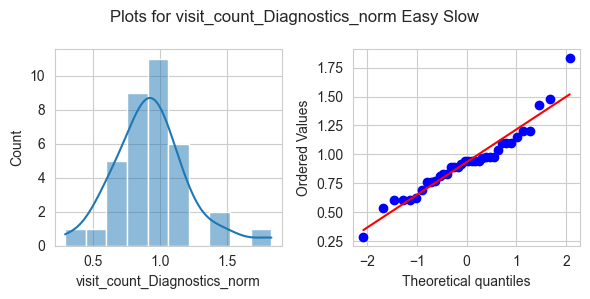

Shapiro-Wilk Test for visit_count_Diagnostics_norm: p-value = 0.07095769882083215


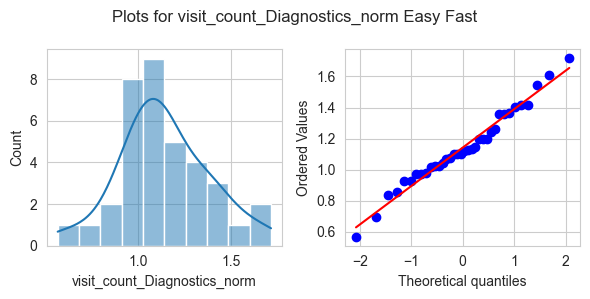

Shapiro-Wilk Test for visit_count_Diagnostics_norm: p-value = 0.7640429451314441


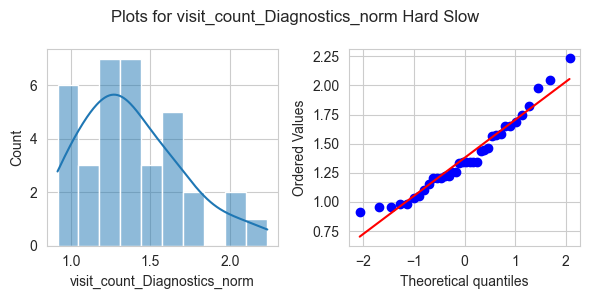

Shapiro-Wilk Test for visit_count_Diagnostics_norm: p-value = 0.0804974535971061


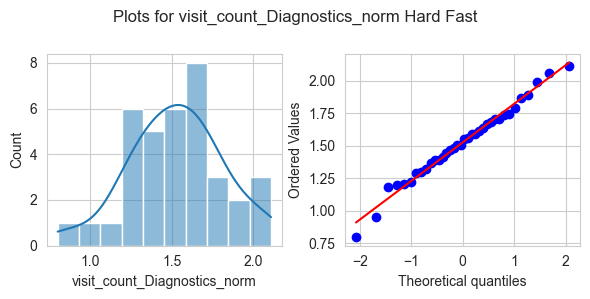

Shapiro-Wilk Test for visit_count_Diagnostics_norm: p-value = 0.9630655147770252


In [35]:
# Normalize (log) and Check Normality
aggregated_df[f'{col}_norm'] = np.log(aggregated_df[col])

check_normality(aggregated_df, f'{col}_norm', 'Easy Slow')
check_normality(aggregated_df, f'{col}_norm', 'Easy Fast')
check_normality(aggregated_df, f'{col}_norm', 'Hard Slow')
check_normality(aggregated_df, f'{col}_norm', 'Hard Fast')

In [36]:
# Check Homoscedasticity
check_homoscedasticity(aggregated_df, 'difficulty', f'{col}_norm')
check_homoscedasticity(aggregated_df, 'frequency', f'{col}_norm')

difficulty: 	Test statistic = 1.6714, p-value = 0.1982
frequency: 	Test statistic = 0.5085, p-value = 0.4769


In [37]:
# Factorial AnovaRM
anova = AnovaRM(
    data=aggregated_df,
    depvar=f'{col}_norm',    # Dependent variable
    subject='participant_id',          # Variable representing the subjects
    within=['difficulty', 'frequency'],# Within-subject factors
    aggregate_func='mean',
).fit()
anova.anova_table

F Value  Num DF  Den DF        Pr > F
difficulty            133.245947     1.0    17.0  1.817713e-09
frequency              25.995296     1.0    17.0  8.920557e-05
difficulty:frequency    1.662506     1.0    17.0  2.145331e-01

In [38]:
# Post-hoc Pairwise Comparison (Bonferroni Correction)
posthoc_diff = pg.pairwise_tests(
    dv=col,
    within=['difficulty', 'frequency'],
    subject='participant_id',
    data=aggregated_df,
    padjust='bonf'
).rename(columns={'difficulty': 'Fixed'})
posthoc_freq = pg.pairwise_tests(
    dv=col,
    within=['frequency', 'difficulty'],
    subject='participant_id',
    data=aggregated_df,
    padjust='bonf'
).rename(columns={'frequency': 'Fixed'})
posthoc = pd.concat([posthoc_diff.tail(4), posthoc_freq.tail(2)])
posthoc

Contrast Fixed     A     B Paired Parametric         T   dof  \
0              difficulty     -  Easy  Hard   True       True -8.116627  17.0   
1               frequency     -  Slow  Fast   True       True -4.883951  17.0   
2  difficulty * frequency  Easy  Slow  Fast   True       True -4.153513  17.0   
3  difficulty * frequency  Hard  Slow  Fast   True       True -3.917852  17.0   
2  frequency * difficulty  Slow  Easy  Hard   True       True -7.368042  17.0   
3  frequency * difficulty  Fast  Easy  Hard   True       True -7.562496  17.0   

  alternative         p-unc    p-corr p-adjust       BF10    hedges  
0   two-sided  2.995439e-07       NaN      NaN  5.364e+04 -1.418218  
1   two-sided  1.397912e-04       NaN      NaN     209.52 -0.556320  
2   two-sided  6.651487e-04  0.001330     bonf     53.275 -0.725860  
3   two-sided  1.107949e-03  0.002216     bonf     34.218 -0.419932  
2   two-sided  1.098375e-06  0.000002     bonf  1.637e+04 -1.283976  
3   two-sided  7.781878e-07  0.000002     bonf  2.242e+04 -1.457854

##### Visit Frequency - Ticket

In [12]:
# Prepare Dataset
col = 'visit_freq_Ticket'
aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_23364\2846524019.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()


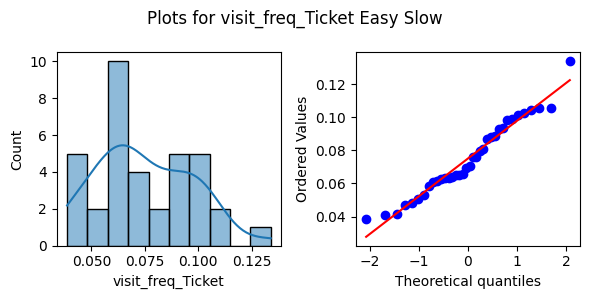

Shapiro-Wilk Test for visit_freq_Ticket: p-value = 0.23482658583503963


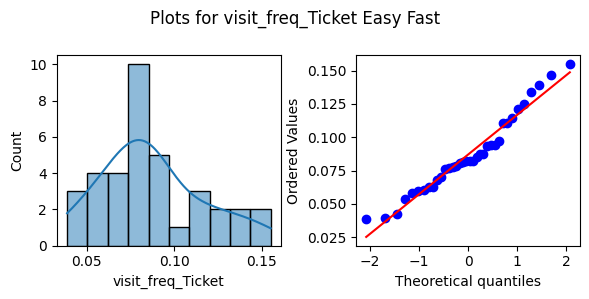

Shapiro-Wilk Test for visit_freq_Ticket: p-value = 0.17428687710583485


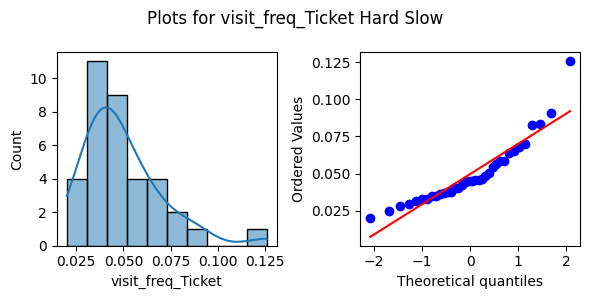

Shapiro-Wilk Test for visit_freq_Ticket: p-value = 0.0007309767283314699


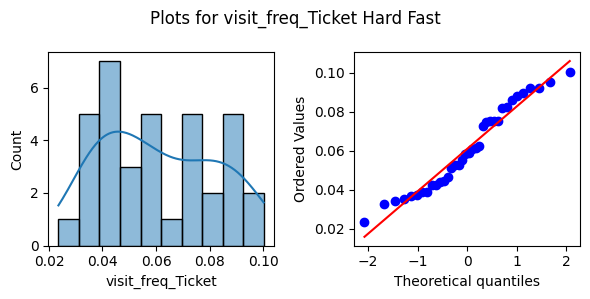

Shapiro-Wilk Test for visit_freq_Ticket: p-value = 0.0835541210599344


In [13]:
# Normalize and Check Normality
check_normality(aggregated_df, col, 'Easy Slow')
check_normality(aggregated_df, col, 'Easy Fast')
check_normality(aggregated_df, col, 'Hard Slow')
check_normality(aggregated_df, col, 'Hard Fast')

In [14]:
# Check Homoscedasticity
check_homoscedasticity(aggregated_df, 'difficulty', col)
check_homoscedasticity(aggregated_df, 'frequency', col)

difficulty: 	Test statistic = 1.6178, p-value = 0.2055
frequency: 	Test statistic = 0.7560, p-value = 0.3861


In [17]:
# Factorial AnovaRM
anova = AnovaRM(
    data=aggregated_df,
    depvar=col,    # Dependent variable
    subject='participant_id',          # Variable representing the subjects
    within=['difficulty', 'frequency'],# Within-subject factors
    aggregate_func='mean',
).fit()
anova.anova_table

F Value  Num DF  Den DF        Pr > F
difficulty            84.298364     1.0    17.0  5.332291e-08
frequency             13.508597     1.0    17.0  1.875360e-03
difficulty:frequency   0.032436     1.0    17.0  8.592027e-01

In [19]:
# Post-hoc Pairwise Comparison (Bonferroni Correction)
posthoc_diff = pg.pairwise_tests(
    dv=col,
    within=['difficulty', 'frequency'],
    subject='participant_id',
    data=aggregated_df,
    padjust='bonf'
).rename(columns={'difficulty': 'Fixed'})
posthoc_freq = pg.pairwise_tests(
    dv=col,
    within=['frequency', 'difficulty'],
    subject='participant_id',
    data=aggregated_df,
    padjust='bonf'
).rename(columns={'frequency': 'Fixed'})
posthoc = pd.concat([posthoc_diff.tail(4), posthoc_freq.tail(2)])
posthoc

Contrast Fixed     A     B Paired Parametric          T  \
0              difficulty     -  Easy  Hard   True       True  11.925972   
1               frequency     -  Slow  Fast   True       True  -4.313009   
2  difficulty * frequency  Easy  Slow  Fast   True       True  -3.539721   
3  difficulty * frequency  Hard  Slow  Fast   True       True  -3.341662   
2  frequency * difficulty  Slow  Easy  Hard   True       True   7.748020   
3  frequency * difficulty  Fast  Easy  Hard   True       True  10.213012   

    dof alternative         p-unc        p-corr p-adjust       BF10    hedges  
0  17.0   two-sided  1.106079e-09           NaN      NaN  9.418e+06  1.343591  
1  17.0   two-sided  4.715871e-04           NaN      NaN     71.911 -0.570444  
2  17.0   two-sided  2.517568e-03  5.035135e-03     bonf     16.898 -0.452409  
3  17.0   two-sided  3.866050e-03  7.732100e-03     bonf     11.732 -0.618834  
2  17.0   two-sided  5.627634e-07  1.125527e-06     bonf  3.014e+04  1.455305  
3  17.0   two-sided  1.135770e-08  2.271539e-08     bonf  1.089e+06  1.081322

##### Visit Length - Description *

In [39]:
# Prepare Dataset
col = 'visit_len_Description'
aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_84\1245350867.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()


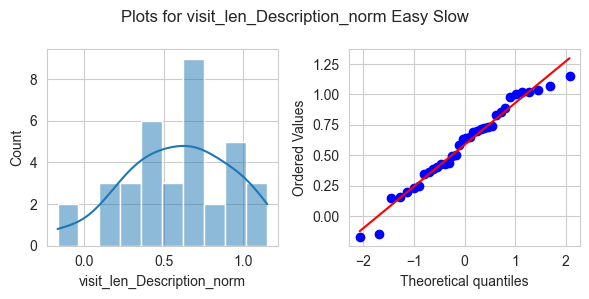

Shapiro-Wilk Test for visit_len_Description_norm: p-value = 0.39442567620731717


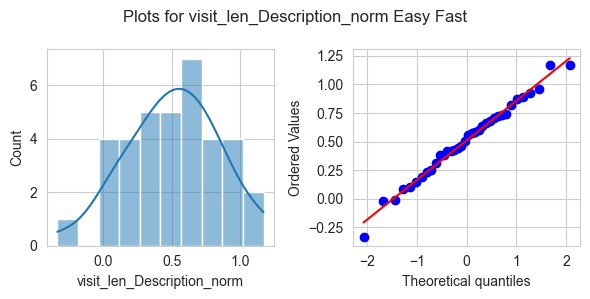

Shapiro-Wilk Test for visit_len_Description_norm: p-value = 0.9731578101789582


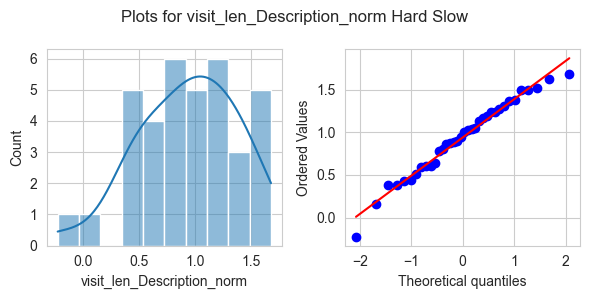

Shapiro-Wilk Test for visit_len_Description_norm: p-value = 0.6414702712201956


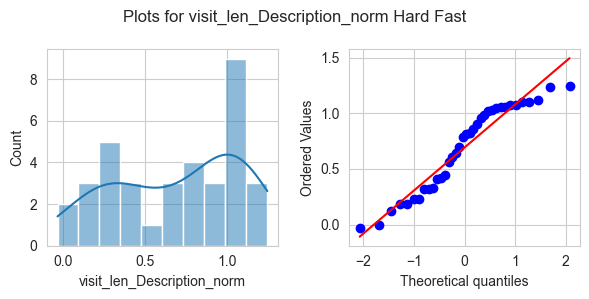

Shapiro-Wilk Test for visit_len_Description_norm: p-value = 0.01188577235442273


In [40]:
# Normalize (boxcox) and Check Normality
aggregated_df[f'{col}_norm'], _ = stats.boxcox(aggregated_df[col])

check_normality(aggregated_df, f'{col}_norm', 'Easy Slow')
check_normality(aggregated_df, f'{col}_norm', 'Easy Fast')
check_normality(aggregated_df, f'{col}_norm', 'Hard Slow')
check_normality(aggregated_df, f'{col}_norm', 'Hard Fast')

In [41]:
# Check Homoscedasticity
check_homoscedasticity(aggregated_df, 'difficulty', f'{col}_norm')
check_homoscedasticity(aggregated_df, 'frequency', f'{col}_norm')

difficulty: 	Test statistic = 4.2818, p-value = 0.0403
frequency: 	Test statistic = 0.7001, p-value = 0.4042


In [42]:
# ANOVA Results (from R) 
print("Analysis of Variance of Aligned Rank Transformed Data")
print("\nTable Type: Analysis of Deviance Table (Type III Wald F tests with Kenward-Roger df)")
print("Model: Mixed Effects (lmer)")
print("Response: art(visit_len_Description_norm)")
print("\n| Effect                 | F-value | df | df.residual | Pr(>F)   |")
print("|------------------------|---------|----|-------------|----------|")
print("| Difficulty             | 29.767  | 1  | 123         | 2.57e-07 | ***")
print("| Frequency              | 10.907  | 1  | 123         | 0.00125  |  **")
print("| Difficulty:Frequency   |  2.678  | 1  | 123         | 0.10428  |    ")
print("---")
print("Signif. codes:   0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1")

Analysis of Variance of Aligned Rank Transformed Data

Table Type: Analysis of Deviance Table (Type III Wald F tests with Kenward-Roger df)
Model: Mixed Effects (lmer)
Response: art(visit_len_Description_norm)

| Effect                 | F-value | df | df.residual | Pr(>F)   |
|------------------------|---------|----|-------------|----------|
| Difficulty             | 29.767  | 1  | 123         | 2.57e-07 | ***
| Frequency              | 10.907  | 1  | 123         | 0.00125  |  **
| Difficulty:Frequency   |  2.678  | 1  | 123         | 0.10428  |    
---
Signif. codes:   0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


##### Dwell_time - Ticket

In [43]:
# Prepare Dataset
col = 'dwell_pct_Ticket'
aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_84\1815151048.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()


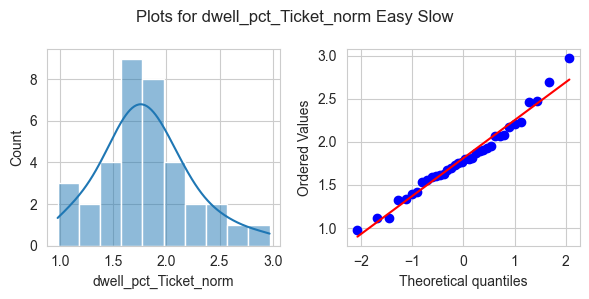

Shapiro-Wilk Test for dwell_pct_Ticket_norm: p-value = 0.6197200689958413


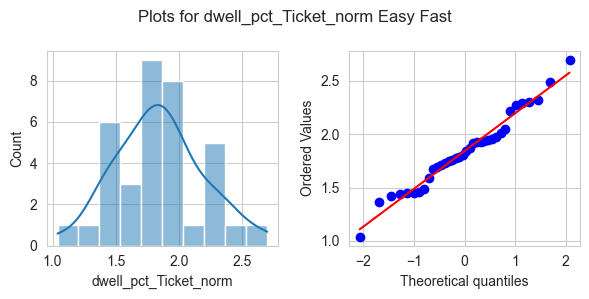

Shapiro-Wilk Test for dwell_pct_Ticket_norm: p-value = 0.6992331030849548


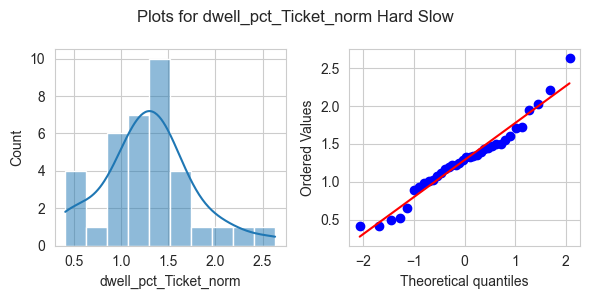

Shapiro-Wilk Test for dwell_pct_Ticket_norm: p-value = 0.28280325464587724


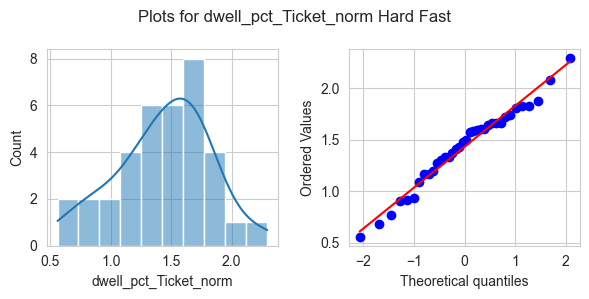

Shapiro-Wilk Test for dwell_pct_Ticket_norm: p-value = 0.6933461418495843


In [44]:
# Normalize (log) and Check Normality
aggregated_df[f'{col}_norm'] = np.log(aggregated_df[col])

check_normality(aggregated_df, f'{col}_norm', 'Easy Slow')
check_normality(aggregated_df, f'{col}_norm', 'Easy Fast')
check_normality(aggregated_df, f'{col}_norm', 'Hard Slow')
check_normality(aggregated_df, f'{col}_norm', 'Hard Fast')

In [45]:
# Check Homoscedasticity
check_homoscedasticity(aggregated_df, 'difficulty', f'{col}_norm')
check_homoscedasticity(aggregated_df, 'frequency', f'{col}_norm')

difficulty: 	Test statistic = 0.9803, p-value = 0.3238
frequency: 	Test statistic = 2.9868, p-value = 0.0861


In [46]:
# Factorial AnovaRM
anova = AnovaRM(
    data=aggregated_df,
    depvar=f'{col}_norm',    # Dependent variable
    subject='participant_id',          # Variable representing the subjects
    within=['difficulty', 'frequency'],# Within-subject factors
    aggregate_func='mean',
).fit()
anova.anova_table

F Value  Num DF  Den DF        Pr > F
difficulty            186.880045     1.0    17.0  1.337555e-10
frequency               1.806765     1.0    17.0  1.965612e-01
difficulty:frequency    2.603175     1.0    17.0  1.250573e-01

In [47]:
# Post-hoc Pairwise Comparison (Bonferroni Correction)
posthoc_diff = pg.pairwise_tests(
    dv=col,
    within=['difficulty', 'frequency'],
    subject='participant_id',
    data=aggregated_df,
    padjust='bonf'
).rename(columns={'difficulty': 'Fixed'})
posthoc_freq = pg.pairwise_tests(
    dv=col,
    within=['frequency', 'difficulty'],
    subject='participant_id',
    data=aggregated_df,
    padjust='bonf'
).rename(columns={'frequency': 'Fixed'})
posthoc = pd.concat([posthoc_diff.tail(4), posthoc_freq.tail(2)])
posthoc

Contrast Fixed     A     B Paired Parametric         T   dof  \
0              difficulty     -  Easy  Hard   True       True  8.112661  17.0   
1               frequency     -  Slow  Fast   True       True -0.485760  17.0   
2  difficulty * frequency  Easy  Slow  Fast   True       True  0.083177  17.0   
3  difficulty * frequency  Hard  Slow  Fast   True       True -0.973957  17.0   
2  frequency * difficulty  Slow  Easy  Hard   True       True  6.133701  17.0   
3  frequency * difficulty  Fast  Easy  Hard   True       True  8.250676  17.0   

  alternative         p-unc        p-corr p-adjust       BF10    hedges  
0   two-sided  3.015550e-07           NaN      NaN  5.332e+04  1.173731  
1   two-sided  6.333387e-01           NaN      NaN       0.27 -0.088047  
2   two-sided  9.346823e-01  1.000000e+00     bonf      0.244  0.013921  
3   two-sided  3.437338e-01  6.874677e-01     bonf      0.368 -0.229702  
2   two-sided  1.103155e-05  2.206310e-05     bonf   2024.358  1.067913  
3   two-sided  2.391928e-07  4.783856e-07     bonf  6.592e+04  1.078708

##### Stationary Entropy

In [48]:
# Prepare Dataset
col = 'stat_entropy'
aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_84\3590772226.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()


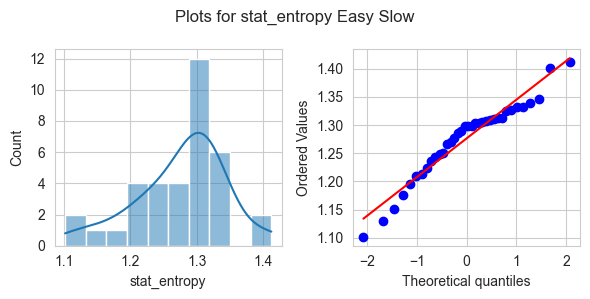

Shapiro-Wilk Test for stat_entropy: p-value = 0.0944326849743241


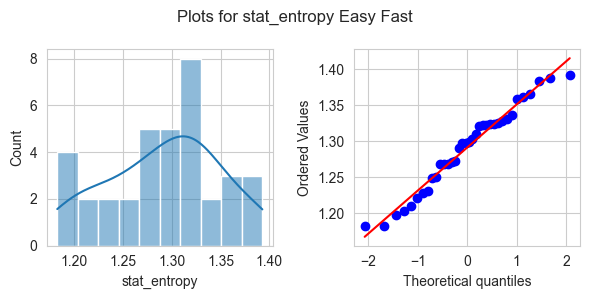

Shapiro-Wilk Test for stat_entropy: p-value = 0.3019543055181213


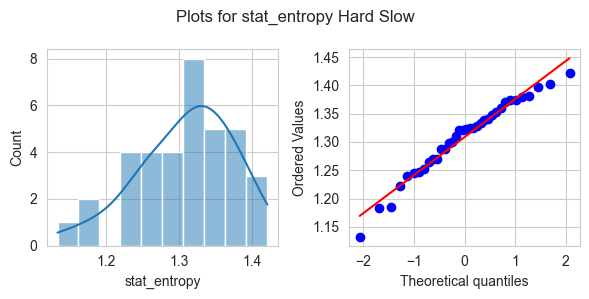

Shapiro-Wilk Test for stat_entropy: p-value = 0.33032635329787313


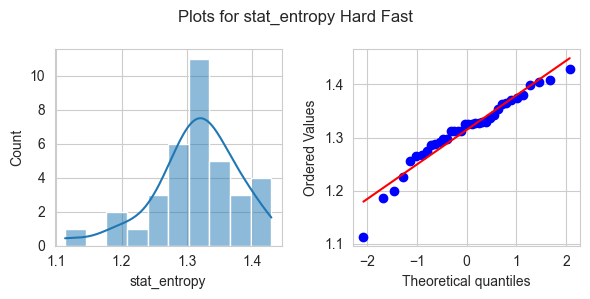

Shapiro-Wilk Test for stat_entropy: p-value = 0.08867592248394991


In [49]:
# Check Normality
check_normality(aggregated_df, col, 'Easy Slow')
check_normality(aggregated_df, col, 'Easy Fast')
check_normality(aggregated_df, col, 'Hard Slow')
check_normality(aggregated_df, col, 'Hard Fast')

In [50]:
# Check Homoscedasticity
check_homoscedasticity(aggregated_df, 'difficulty', col)
check_homoscedasticity(aggregated_df, 'frequency', col)

difficulty: 	Test statistic = 0.0003, p-value = 0.9865
frequency: 	Test statistic = 0.3216, p-value = 0.5715


In [51]:
# Factorial AnovaRM
anova = AnovaRM(
    data=aggregated_df,
    depvar=col,    # Dependent variable
    subject='participant_id',          # Variable representing the subjects
    within=['difficulty', 'frequency'],# Within-subject factors
    aggregate_func='mean',
).fit()
anova.anova_table

F Value  Num DF  Den DF    Pr > F
difficulty            13.798789     1.0    17.0  0.001722
frequency              1.187228     1.0    17.0  0.291094
difficulty:frequency   0.411138     1.0    17.0  0.529943

In [52]:
# Post-hoc Pairwise Comparison (Bonferroni Correction)
posthoc_diff = pg.pairwise_tests(
    dv=col,
    within=['difficulty', 'frequency'],
    subject='participant_id',
    data=aggregated_df,
    padjust='bonf'
).rename(columns={'difficulty': 'Fixed'})
posthoc_freq = pg.pairwise_tests(
    dv=col,
    within=['frequency', 'difficulty'],
    subject='participant_id',
    data=aggregated_df,
    padjust='bonf'
).rename(columns={'frequency': 'Fixed'})
posthoc = pd.concat([posthoc_diff.tail(4), posthoc_freq.tail(2)])
posthoc

Contrast Fixed     A     B Paired Parametric         T   dof  \
0              difficulty     -  Easy  Hard   True       True -3.714672  17.0   
1               frequency     -  Slow  Fast   True       True -1.089600  17.0   
2  difficulty * frequency  Easy  Slow  Fast   True       True -1.214593  17.0   
3  difficulty * frequency  Hard  Slow  Fast   True       True -0.484417  17.0   
2  frequency * difficulty  Slow  Easy  Hard   True       True -2.720489  17.0   
3  frequency * difficulty  Fast  Easy  Hard   True       True -2.547406  17.0   

  alternative     p-unc    p-corr p-adjust    BF10    hedges  
0   two-sided  0.001722       NaN      NaN  23.396 -0.535073  
1   two-sided  0.291094       NaN      NaN   0.407 -0.196994  
2   two-sided  0.241124  0.482247     bonf   0.459 -0.278968  
3   two-sided  0.634272  1.000000     bonf    0.27 -0.093559  
2   two-sided  0.014539  0.029078     bonf   3.882 -0.558876  
3   two-sided  0.020821  0.041641     bonf   2.896 -0.393494

### 3. AoI Selection per Metric

##### Fixation Duration
Map

In [53]:
# Prepare variables
features = [
    'duration_Ticket',
    'duration_Description',
    'duration_Map',
    'duration_Diagnostics',
    'duration_Actions'
]

X = df_long_expanded.dropna()[features]
y = df_long_expanded.dropna()['condition'].apply(lambda x: 
    0 if x == "Easy Slow" else 
    1 if x == "Easy Fast" else 
    2 if x == "Hard Slow" else 3)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

duration_Map


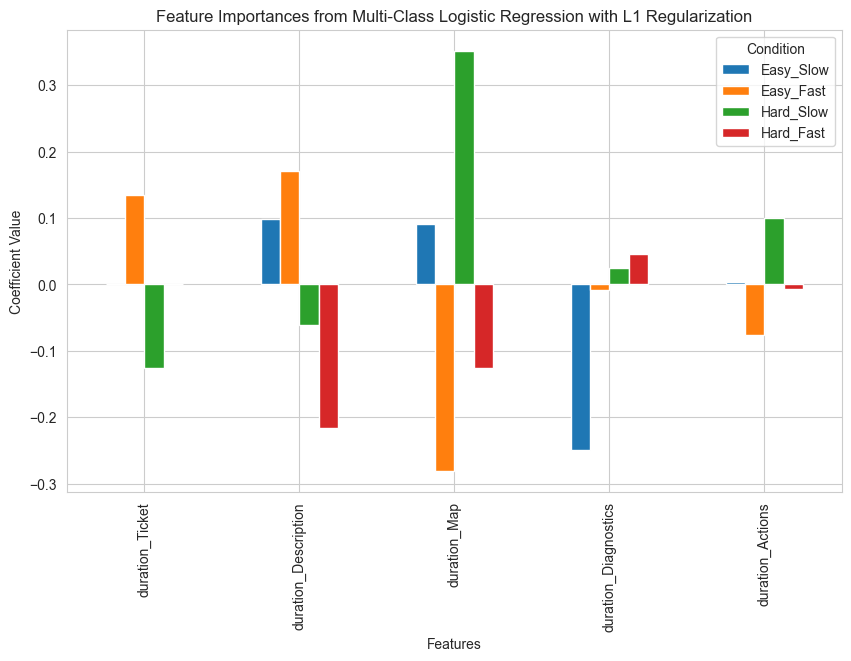

In [54]:
# Fit model and plot feature importances
log_reg = LogisticRegression(
    penalty='l1', 
    solver='saga', 
    class_weight='balanced', 
    random_state=0
)
log_reg.fit(X_scaled, y)

coefficients = pd.DataFrame(log_reg.coef_, columns=features)
coefficients.index = ['Easy_Slow', 'Easy_Fast', 'Hard_Slow', 'Hard_Fast']

most_important_feature = coefficients.abs().sum(axis=0).idxmax()
print(most_important_feature)

coefficients.T.plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importances from Multi-Class Logistic Regression with L1 Regularization')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.legend(title="Condition")
plt.show()

##### Fixation Count
Description

In [55]:
# Prepare variables
features = [
    'fix_count_Ticket',
    'fix_count_Description',
    'fix_count_Map',
    'fix_count_Diagnostics',
    'fix_count_Actions'
]

X = df_long_expanded.dropna().drop(columns=['participant_id', 'instance', 'condition'])[features]
y = df_long_expanded.dropna()['condition'].apply(lambda x: 
    0 if x == "Easy Slow" else 
    1 if x == "Easy Fast" else 
    2 if x == "Hard Slow" else 3)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

fix_count_Description


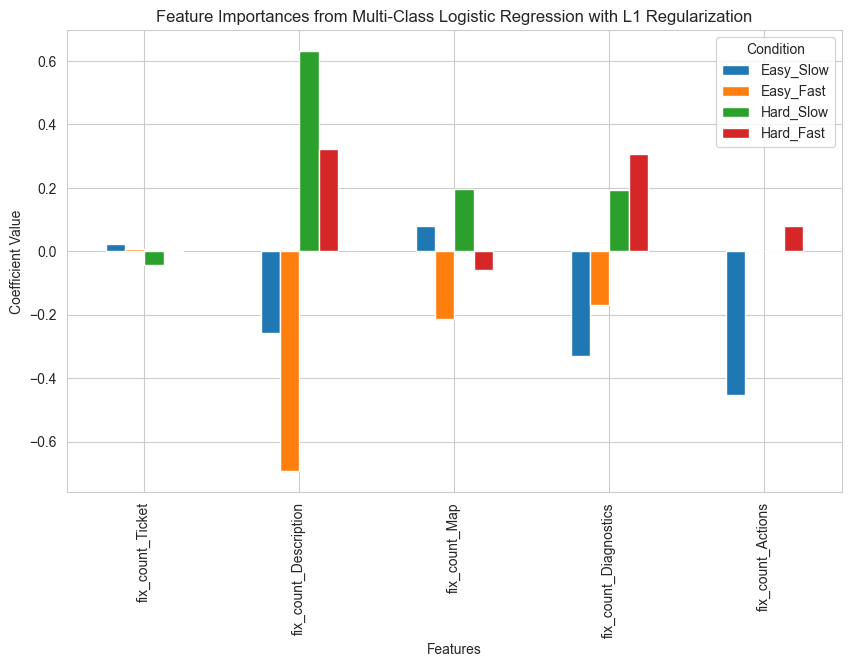

In [56]:
# Fit model and plot feature importances
log_reg = LogisticRegression(
    penalty='l1', 
    solver='saga', 
    class_weight='balanced', 
    random_state=0
)
log_reg.fit(X_scaled, y)

coefficients = pd.DataFrame(log_reg.coef_, columns=features)
coefficients.index = ['Easy_Slow', 'Easy_Fast', 'Hard_Slow', 'Hard_Fast']

most_important_feature = coefficients.abs().sum(axis=0).idxmax()
print(most_important_feature)

coefficients.T.plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importances from Multi-Class Logistic Regression with L1 Regularization')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.legend(title="Condition")
plt.show()

##### Fixation Frequency
Ticket

In [57]:
# Prepare variables
features = [
    'fix_freq_Ticket',
    'fix_freq_Description',
    'fix_freq_Map',
    'fix_freq_Diagnostics',
    'fix_freq_Actions'
]

X = df_long_expanded.dropna().drop(columns=['participant_id', 'instance', 'condition'])[features]
y = df_long_expanded.dropna()['condition'].apply(lambda x: 
    0 if x == "Easy Slow" else 
    1 if x == "Easy Fast" else 
    2 if x == "Hard Slow" else 3)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

fix_freq_Ticket


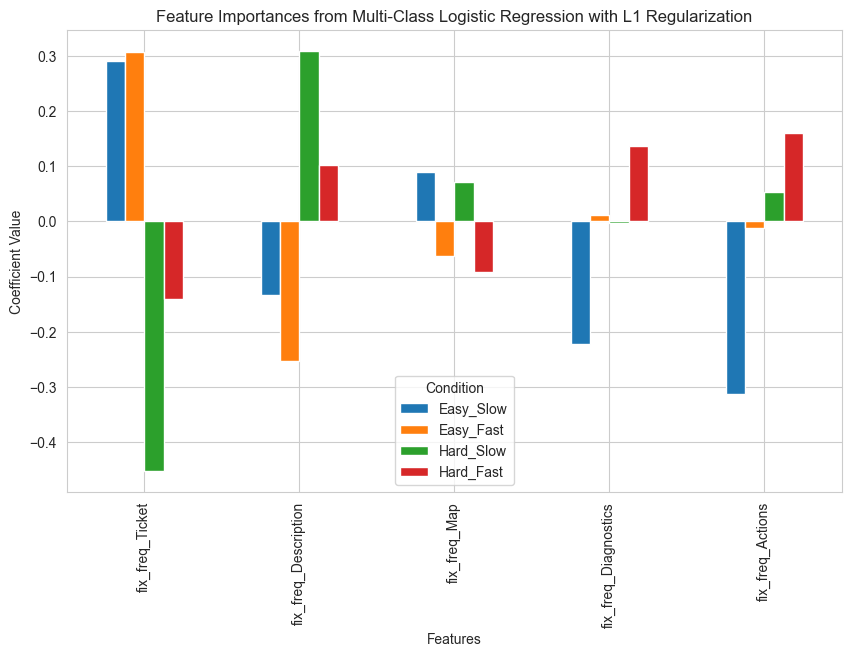

In [58]:
# Fit model and plot feature importances
log_reg = LogisticRegression(
    penalty='l1', 
    solver='saga', 
    class_weight='balanced', 
    random_state=0
)
log_reg.fit(X_scaled, y)

coefficients = pd.DataFrame(log_reg.coef_, columns=features)
coefficients.index = ['Easy_Slow', 'Easy_Fast', 'Hard_Slow', 'Hard_Fast']

most_important_feature = coefficients.abs().sum(axis=0).idxmax()
print(most_important_feature)

coefficients.T.plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importances from Multi-Class Logistic Regression with L1 Regularization')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.legend(title="Condition")
plt.show()

##### Time-to-1st Fixation
Diagnostics

In [59]:
# Prepare variables
features = [
    'time_1st_fix_Ticket',
    'time_1st_fix_Description',
    'time_1st_fix_Map',
    'time_1st_fix_Diagnostics',
    'time_1st_fix_Actions'
]

X = df_long_expanded.dropna().drop(columns=['participant_id', 'instance', 'condition'])[features]
y = df_long_expanded.dropna()['condition'].apply(lambda x: 
    0 if x == "Easy Slow" else 
    1 if x == "Easy Fast" else 
    2 if x == "Hard Slow" else 3)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

time_1st_fix_Diagnostics


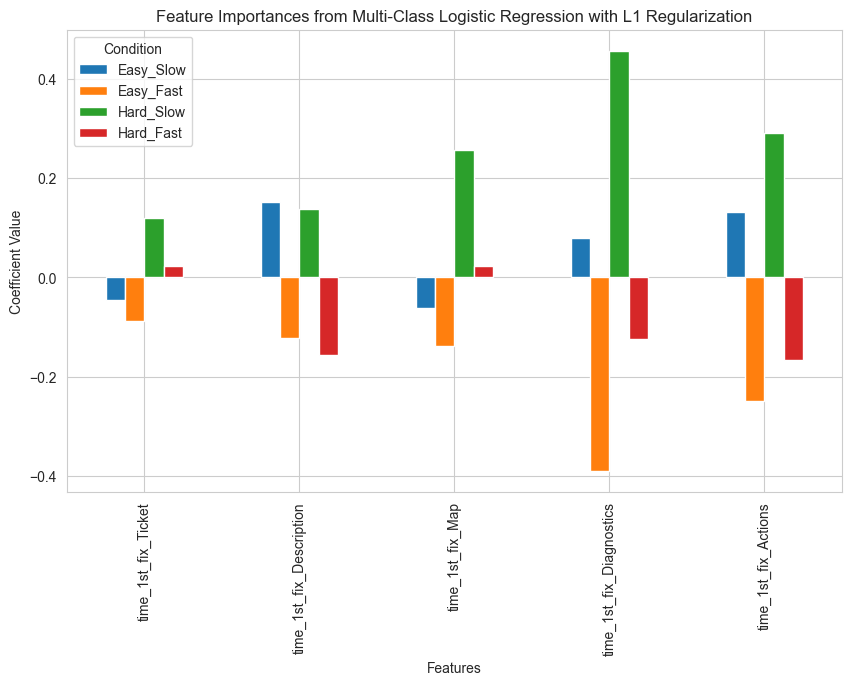

In [60]:
# Fit model and plot feature importances
log_reg = LogisticRegression(
    penalty='l1', 
    solver='saga', 
    class_weight='balanced', 
    random_state=0
)
log_reg.fit(X_scaled, y)

coefficients = pd.DataFrame(log_reg.coef_, columns=features)
coefficients.index = ['Easy_Slow', 'Easy_Fast', 'Hard_Slow', 'Hard_Fast']

most_important_feature = coefficients.abs().sum(axis=0).idxmax()
print(most_important_feature)

coefficients.T.plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importances from Multi-Class Logistic Regression with L1 Regularization')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.legend(title="Condition")
plt.show()

##### Visit Count
Actions

In [61]:
# Prepare variables
features = [
    'visit_count_Ticket',
    'visit_count_Description',
    'visit_count_Map',
    'visit_count_Diagnostics',
    'visit_count_Actions'
]

X = df_long_expanded.dropna().drop(columns=['participant_id', 'instance', 'condition'])[features]
y = df_long_expanded.dropna()['condition'].apply(lambda x: 
    0 if x == "Easy Slow" else 
    1 if x == "Easy Fast" else 
    2 if x == "Hard Slow" else 3)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

visit_count_Actions


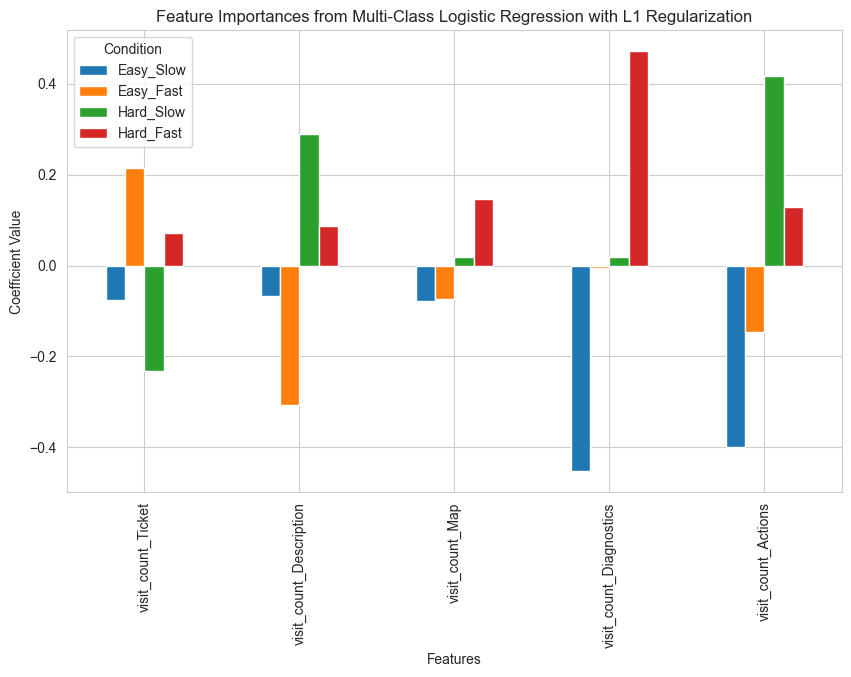

In [62]:
# Fit model and plot feature importances
log_reg = LogisticRegression(
    penalty='l1', 
    solver='saga', 
    class_weight='balanced', 
    random_state=0
)
log_reg.fit(X_scaled, y)

coefficients = pd.DataFrame(log_reg.coef_, columns=features)
coefficients.index = ['Easy_Slow', 'Easy_Fast', 'Hard_Slow', 'Hard_Fast']

most_important_feature = coefficients.abs().sum(axis=0).idxmax()
print(most_important_feature)

coefficients.T.plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importances from Multi-Class Logistic Regression with L1 Regularization')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.legend(title="Condition")
plt.show()

##### Visit Length
Description

In [63]:
# Prepare variables
features = [
    'visit_len_Ticket',
    'visit_len_Description',
    'visit_len_Map',
    'visit_len_Diagnostics',
    'visit_len_Actions'
]

X = df_long_expanded.dropna().drop(columns=['participant_id', 'instance', 'condition'])[features]
y = df_long_expanded.dropna()['condition'].apply(lambda x: 
    0 if x == "Easy Slow" else 
    1 if x == "Easy Fast" else 
    2 if x == "Hard Slow" else 3)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

visit_len_Description


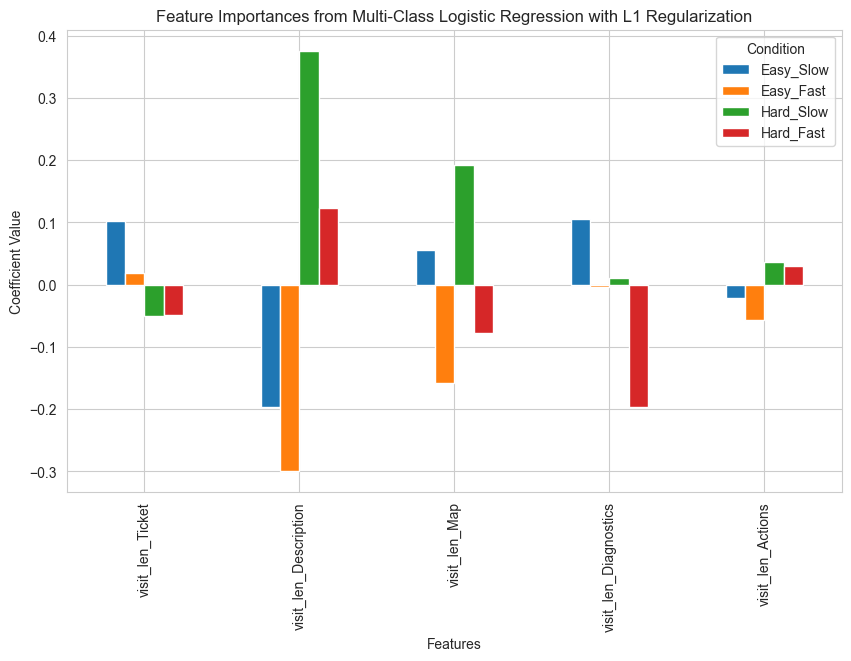

In [64]:
# Fit model and plot feature importances
log_reg = LogisticRegression(
    penalty='l1', 
    solver='saga', 
    class_weight='balanced', 
    random_state=0
)
log_reg.fit(X_scaled, y)

coefficients = pd.DataFrame(log_reg.coef_, columns=features)
coefficients.index = ['Easy_Slow', 'Easy_Fast', 'Hard_Slow', 'Hard_Fast']

most_important_feature = coefficients.abs().sum(axis=0).idxmax()
print(most_important_feature)

coefficients.T.plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importances from Multi-Class Logistic Regression with L1 Regularization')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.legend(title="Condition")
plt.show()

##### Dwell Time
Ticket

In [65]:
# Prepare variables
features = [
    'dwell_pct_Ticket',
    'dwell_pct_Description',
    'dwell_pct_Map',
    'dwell_pct_Diagnostics',
    'dwell_pct_Actions'
]

X = df_long_expanded.dropna().drop(columns=['participant_id', 'instance', 'condition'])[features]
y = df_long_expanded.dropna()['condition'].apply(lambda x: 
    0 if x == "Easy Slow" else 
    1 if x == "Easy Fast" else 
    2 if x == "Hard Slow" else 3)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

dwell_pct_Ticket


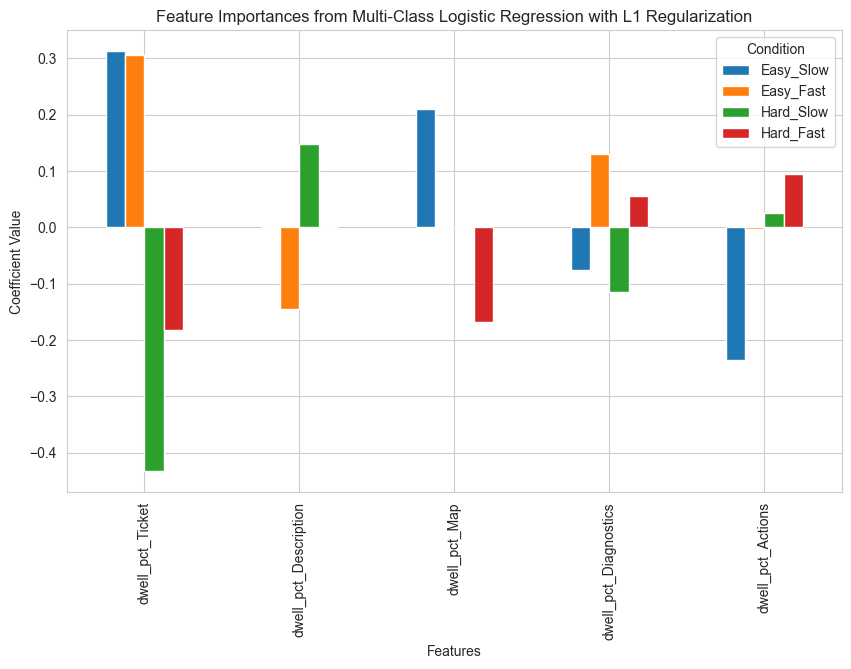

In [66]:
# Fit model and plot feature importances
log_reg = LogisticRegression(
    penalty='l1', 
    solver='saga', 
    class_weight='balanced', 
    random_state=0
)
log_reg.fit(X_scaled, y)

coefficients = pd.DataFrame(log_reg.coef_, columns=features)
coefficients.index = ['Easy_Slow', 'Easy_Fast', 'Hard_Slow', 'Hard_Fast']

most_important_feature = coefficients.abs().sum(axis=0).idxmax()
print(most_important_feature)

coefficients.T.plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importances from Multi-Class Logistic Regression with L1 Regularization')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.legend(title="Condition")
plt.show()

##### Entropy
Transition Entropy

In [67]:
# Prepare variables
features = [
    'stat_entropy',
    'trans_entropy'
]

X = df_long_expanded.dropna().drop(columns=['participant_id', 'instance', 'condition'])[features]
y = df_long_expanded.dropna()['condition'].apply(lambda x: 
    0 if x == "Easy Slow" else 
    1 if x == "Easy Fast" else 
    2 if x == "Hard Slow" else 3)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

trans_entropy


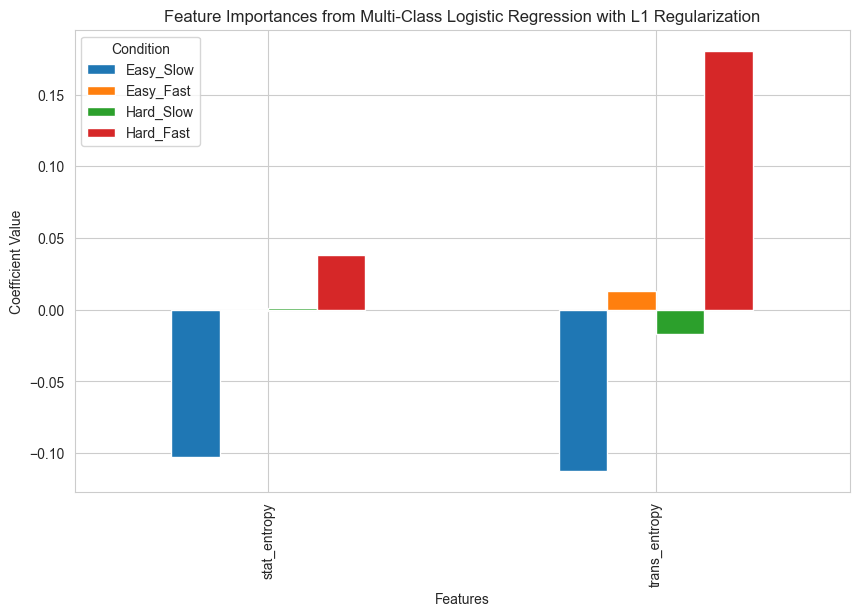

In [68]:
# Fit model and plot feature importances
log_reg = LogisticRegression(
    penalty='l1', 
    solver='saga', 
    class_weight='balanced', 
    random_state=0
)
log_reg.fit(X_scaled, y)

coefficients = pd.DataFrame(log_reg.coef_, columns=features)
coefficients.index = ['Easy_Slow', 'Easy_Fast', 'Hard_Slow', 'Hard_Fast']

most_important_feature = coefficients.abs().sum(axis=0).idxmax()
print(most_important_feature)

coefficients.T.plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importances from Multi-Class Logistic Regression with L1 Regularization')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.legend(title="Condition")
plt.show()

### 4. Descriptive Analysis (new features)

##### Fixation Duration - Map
Positive - Negative

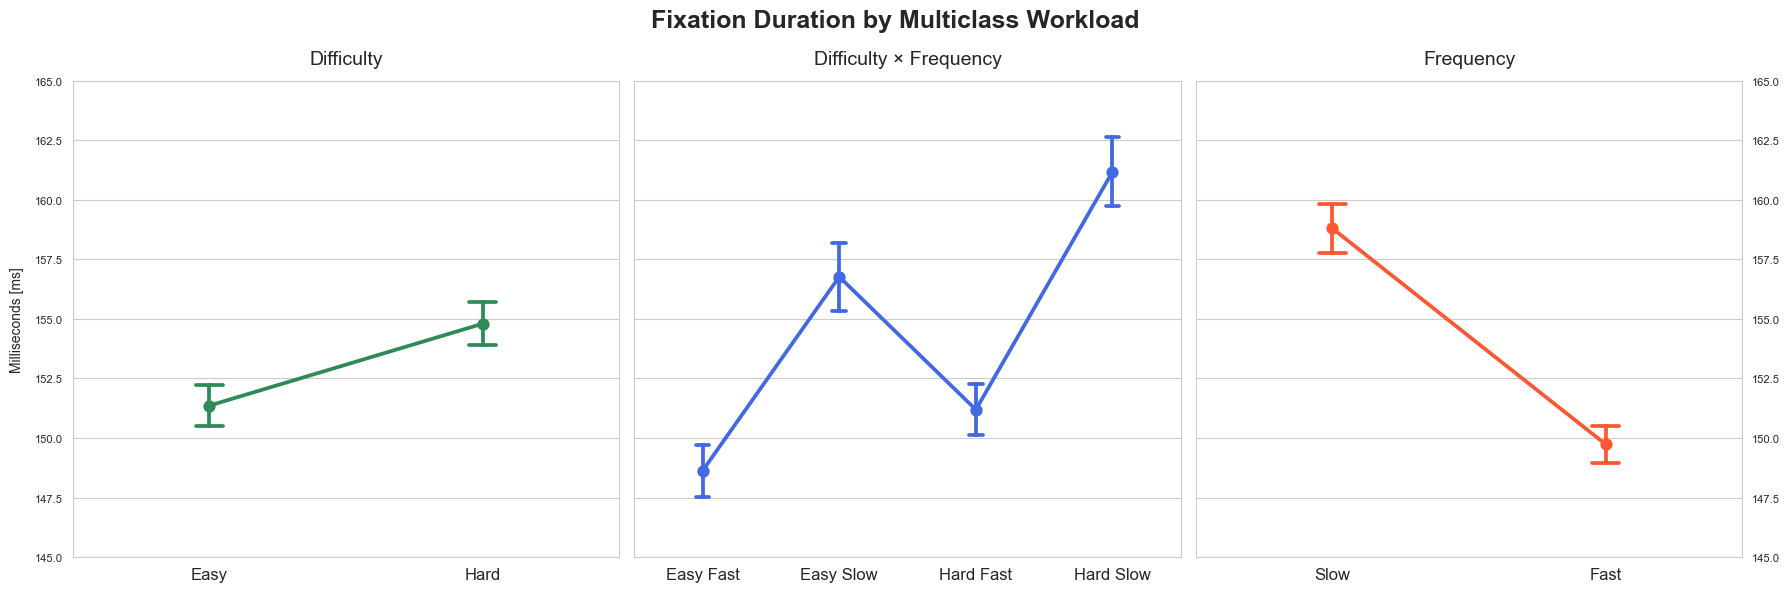

In [69]:
# Visualize plots
col = 'duration_Map'
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Fixation Duration by Multiclass Workload', fontsize=18, weight='bold')
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df_long_expanded, x='difficulty', y=col, errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Milliseconds [ms]', fontsize=10, labelpad=8)
axes[0].set_ylim(145, 165)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=8)

# difficulty & frequency
sns.pointplot(ax=axes[1], data=df_long_expanded, x='condition', y=col, errorbar='se', markers='o', capsize=.1, color=colors[1])
axes[1].set_title('Difficulty × Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(145, 165)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelleft=False)

# frequency
sns.pointplot(ax=axes[2], data=df_long_expanded, x='frequency', y=col, errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[2].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_ylim(145, 165)
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=8, labelleft=False, labelright=True)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

##### Fixation Count - Description
Positive - Negative

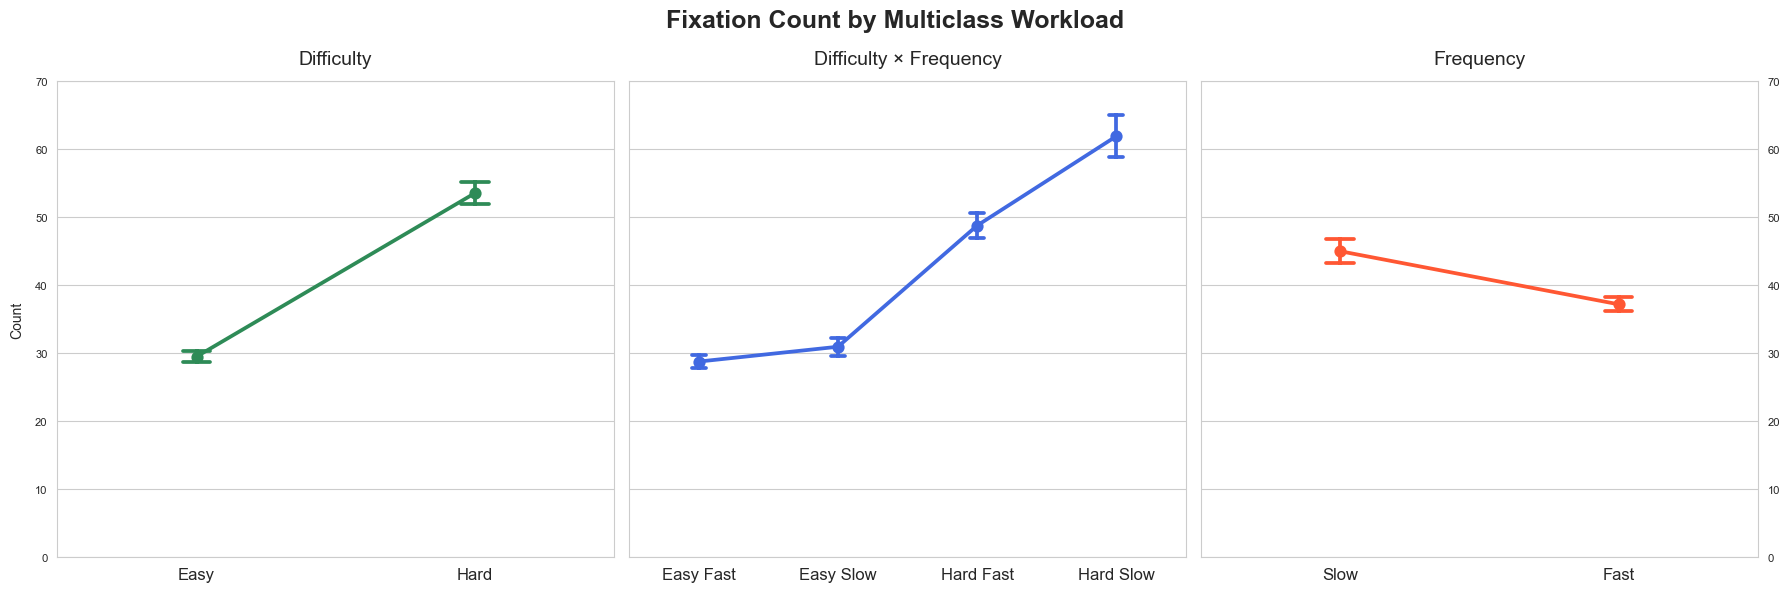

In [70]:
# Visualize plot
col = 'fix_count_Description'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Fixation Count by Multiclass Workload', fontsize=18, weight='bold')
sns.set_style("whitegrid")
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df_long_expanded, x='difficulty', y=col, errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Count', fontsize=10, labelpad=8)
axes[0].set_ylim(0, 70)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=8)

# difficulty & frequency
sns.pointplot(ax=axes[1], data=df_long_expanded, x='condition', y=col, errorbar='se', markers='o', capsize=.1, color=colors[1])
axes[1].set_title('Difficulty × Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(0, 70)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelleft=False)

# frequency
sns.pointplot(ax=axes[2], data=df_long_expanded, x='frequency', y=col, errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[2].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_ylim(0, 70)
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=8, labelleft=False, labelright=True)


plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

##### Fixation Frequency - Ticket
Negative - Positive

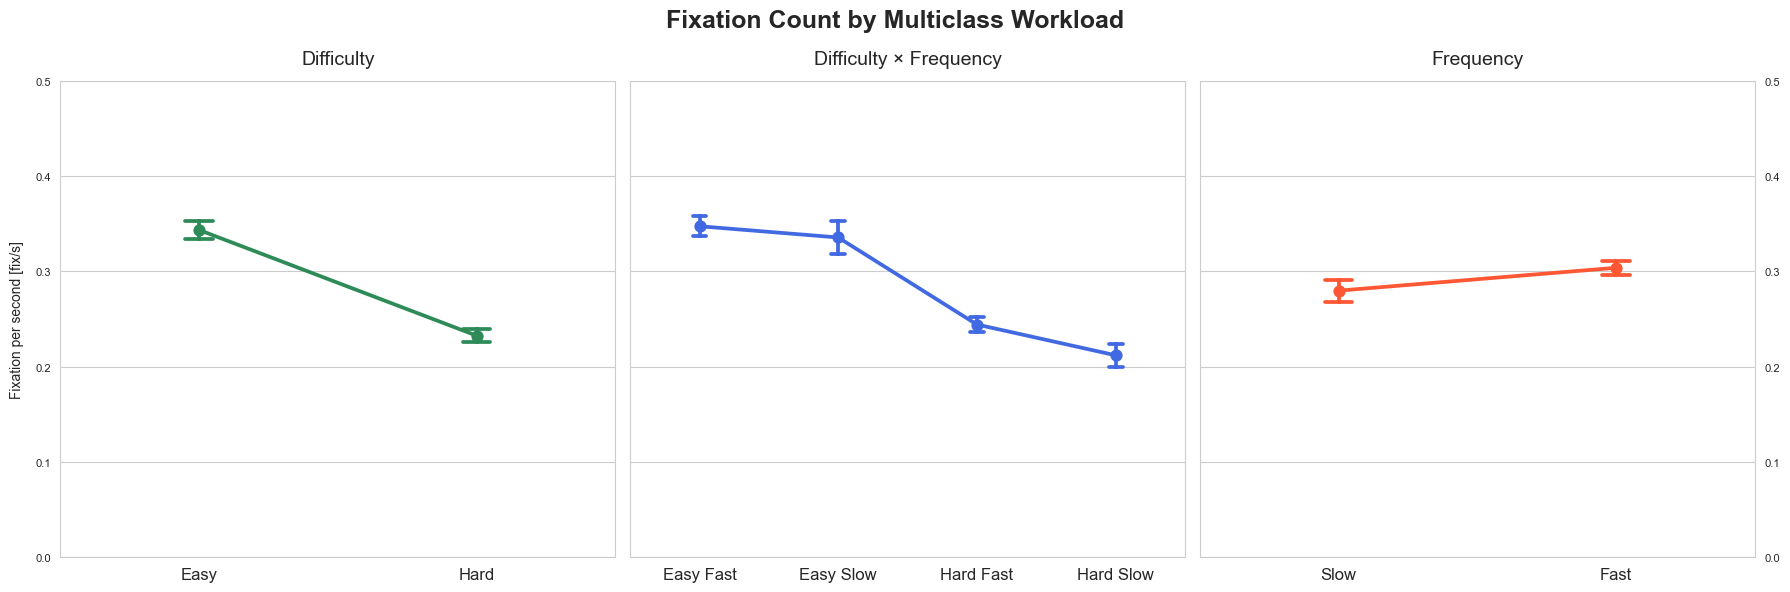

In [71]:
# Visualize plot
col = 'fix_freq_Ticket'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Fixation Count by Multiclass Workload', fontsize=18, weight='bold')
sns.set_style("whitegrid")
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df_long_expanded, x='difficulty', y=col, errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Fixation per second [fix/s]', fontsize=10, labelpad=8)
axes[0].set_ylim(0, .5)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=8)

# difficulty & frequency
sns.pointplot(ax=axes[1], data=df_long_expanded, x='condition', y=col, errorbar='se', markers='o', capsize=.1, color=colors[1])
axes[1].set_title('Difficulty × Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(0, .5)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelleft=False)

# frequency
sns.pointplot(ax=axes[2], data=df_long_expanded, x='frequency', y=col, errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[2].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_ylim(0, .5)
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=8, labelleft=False, labelright=True)


plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

##### Time-to-1st- Fix - Diagnostics
Positive - Negative

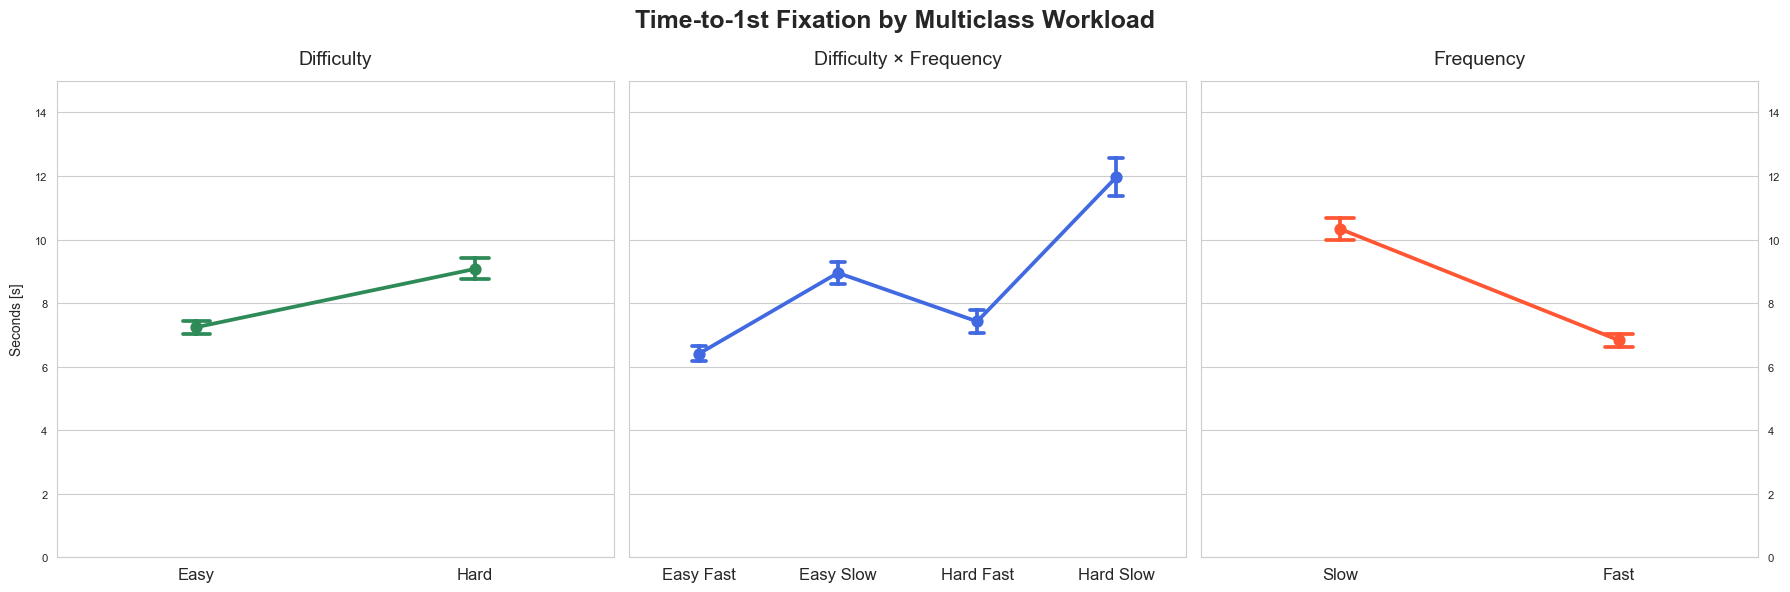

In [72]:
# Visualize plot
col = 'time_1st_fix_Diagnostics'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Time-to-1st Fixation by Multiclass Workload', fontsize=18, weight='bold')
sns.set_style("whitegrid")
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df_long_expanded, x='difficulty', y=col, errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Seconds [s]', fontsize=10, labelpad=8)
axes[0].set_ylim(0, 15)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=8)

# difficulty & frequency
sns.pointplot(ax=axes[1], data=df_long_expanded, x='condition', y=col, errorbar='se', markers='o', capsize=.1, color=colors[1])
axes[1].set_title('Difficulty × Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(0, 15)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelleft=False)

# frequency
sns.pointplot(ax=axes[2], data=df_long_expanded, x='frequency', y=col, errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[2].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_ylim(0, 15)
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=8, labelleft=False, labelright=True)


plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

##### Visit Count - Actions
Positive - Positive

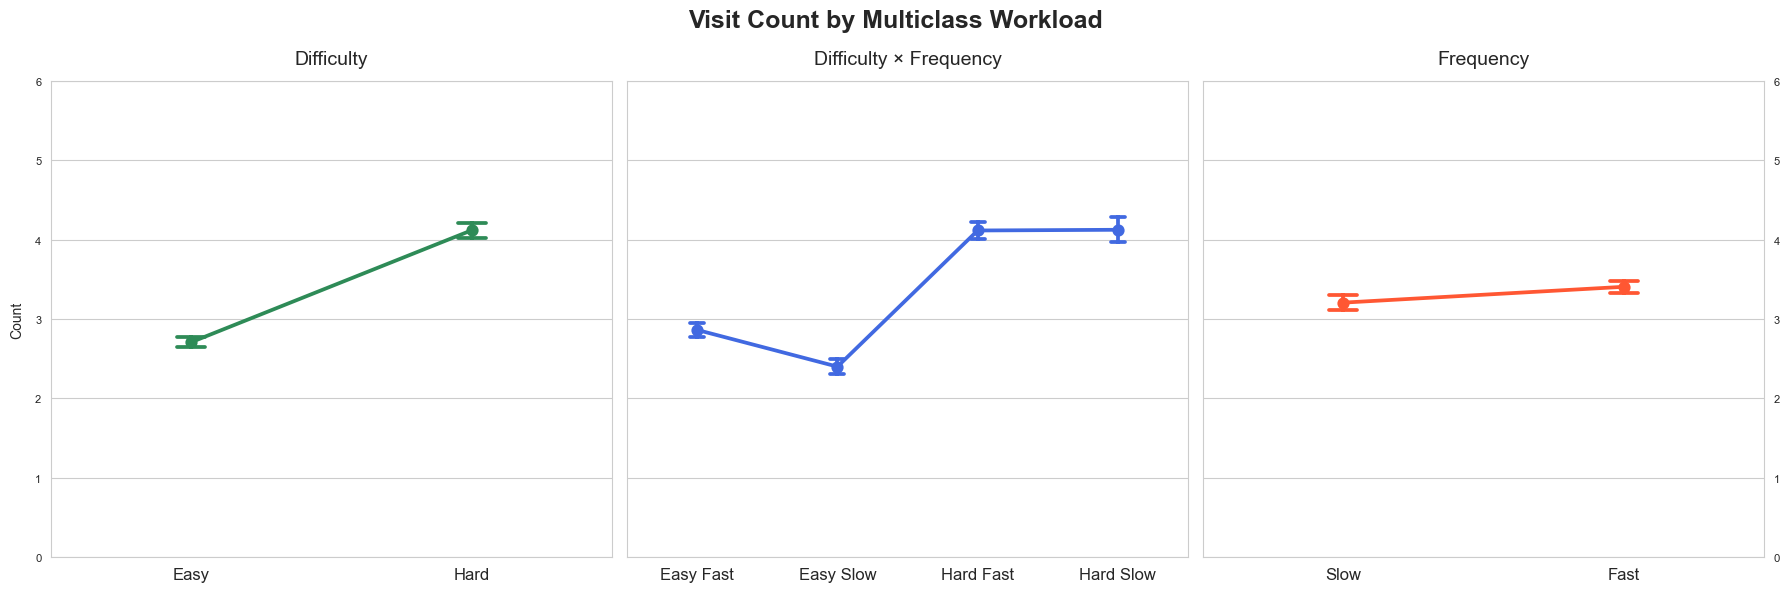

In [73]:
# Visualize plot
col = 'visit_count_Actions'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Visit Count by Multiclass Workload', fontsize=18, weight='bold')
sns.set_style("whitegrid")
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df_long_expanded, x='difficulty', y=col, errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Count', fontsize=10, labelpad=8)
axes[0].set_ylim(0, 6)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=8)

# difficulty & frequency
sns.pointplot(ax=axes[1], data=df_long_expanded, x='condition', y=col, errorbar='se', markers='o', capsize=.1, color=colors[1])
axes[1].set_title('Difficulty × Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(0, 6)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelleft=False)

# frequency
sns.pointplot(ax=axes[2], data=df_long_expanded, x='frequency', y=col, errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[2].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_ylim(0, 6)
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=8, labelleft=False, labelright=True)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

##### Visit Length - Description
Positive - Negative

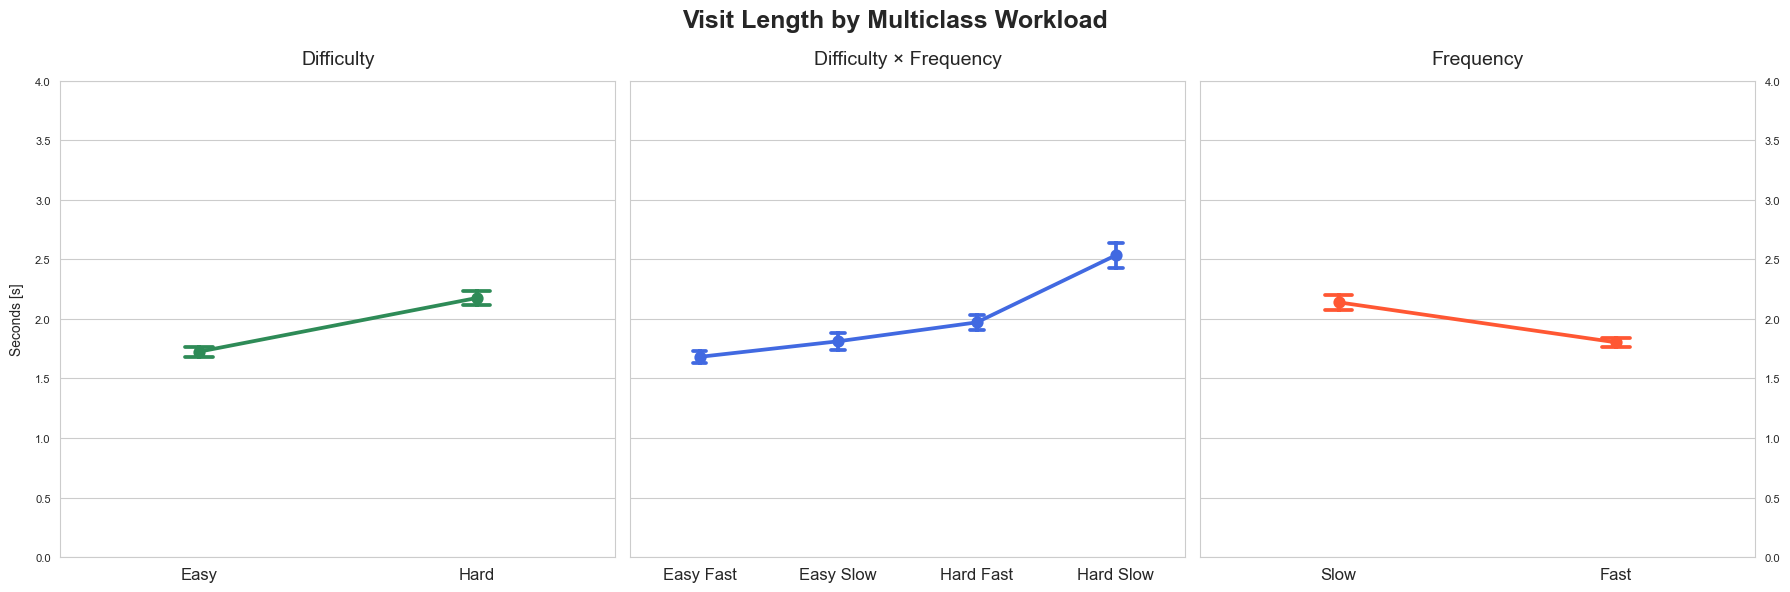

In [74]:
# Visualize plot
col = 'visit_len_Description'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Visit Length by Multiclass Workload', fontsize=18, weight='bold')
sns.set_style("whitegrid")
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df_long_expanded, x='difficulty', y=col, errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Seconds [s]', fontsize=10, labelpad=8)
axes[0].set_ylim(0, 4)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=8)

# difficulty & frequency
sns.pointplot(ax=axes[1], data=df_long_expanded, x='condition', y=col, errorbar='se', markers='o', capsize=.1, color=colors[1])
axes[1].set_title('Difficulty × Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(0, 4)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelleft=False)

# frequency
sns.pointplot(ax=axes[2], data=df_long_expanded, x='frequency', y=col, errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[2].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_ylim(0, 4)
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=8, labelleft=False, labelright=True)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

##### Dwell Time - Ticket
Negative - Positive

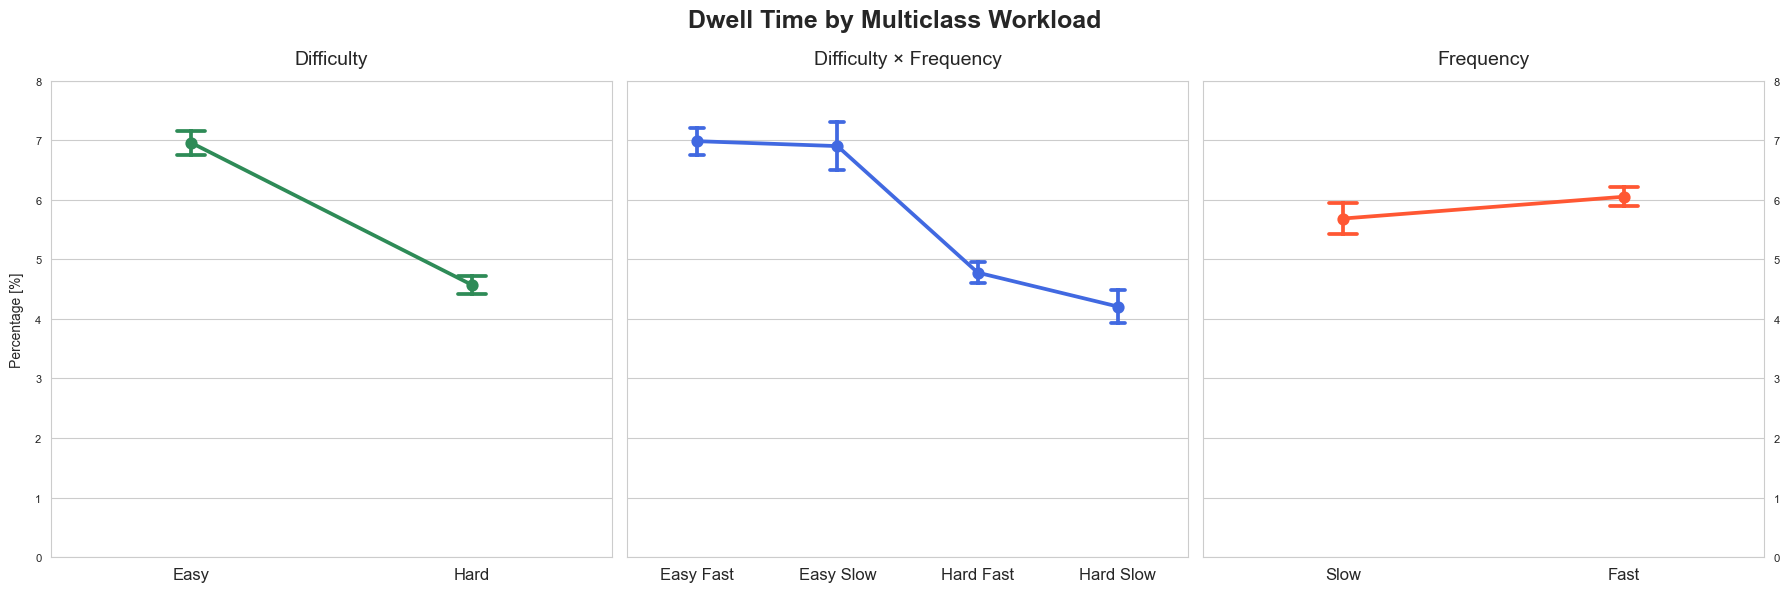

In [75]:
# Visualize plot
col = 'dwell_pct_Ticket'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Dwell Time by Multiclass Workload', fontsize=18, weight='bold')
sns.set_style("whitegrid")
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df_long_expanded, x='difficulty', y=col, errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Percentage [%]', fontsize=10, labelpad=8)
axes[0].set_ylim(0, 8)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=8)

# difficulty & frequency
sns.pointplot(ax=axes[1], data=df_long_expanded, x='condition', y=col, errorbar='se', markers='o', capsize=.1, color=colors[1])
axes[1].set_title('Difficulty × Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(0, 8)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelleft=False)

# frequency
sns.pointplot(ax=axes[2], data=df_long_expanded, x='frequency', y=col, errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[2].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_ylim(0, 8)
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=8, labelleft=False, labelright=True)


plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

##### Stationary Entropy
Positive - Positive

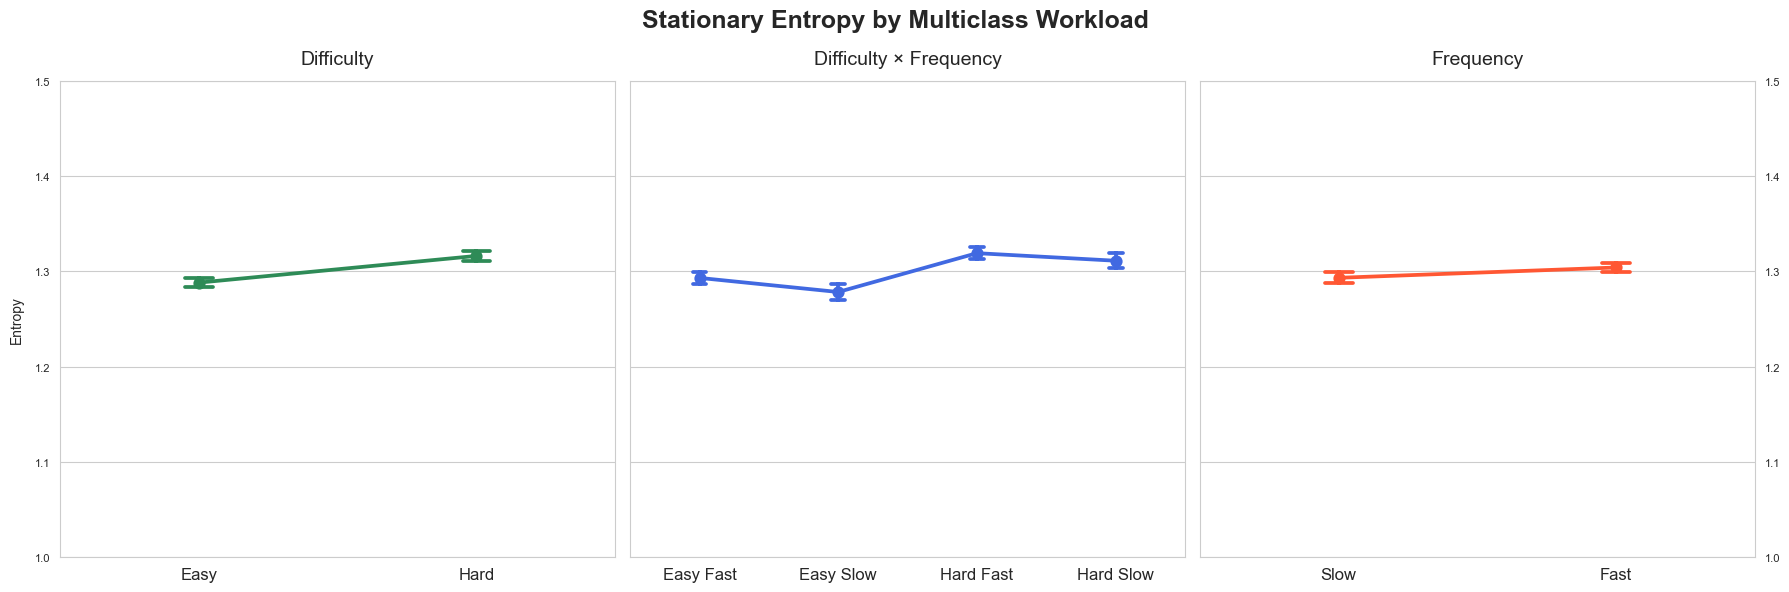

In [76]:
# Visualize plot
col = 'stat_entropy'
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Stationary Entropy by Multiclass Workload', fontsize=18, weight='bold')
sns.set_style("whitegrid")
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df_long_expanded, x='difficulty', y=col, errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Entropy', fontsize=10, labelpad=8)
axes[0].set_ylim(1, 1.5)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=8)

# difficulty & frequency
sns.pointplot(ax=axes[1], data=df_long_expanded, x='condition', y=col, errorbar='se', markers='o', capsize=.1, color=colors[1])
axes[1].set_title('Difficulty × Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(1, 1.5)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelleft=False)

# frequency
sns.pointplot(ax=axes[2], data=df_long_expanded, x='frequency', y=col, errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[2].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_ylim(1, 1.5)
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=8, labelleft=False, labelright=True)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

### 5. Inferential Analysis (new features)

##### Fixation Duration - Map

In [77]:
# Prepare Dataset
col = 'duration_Map'
aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_84\576961903.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()


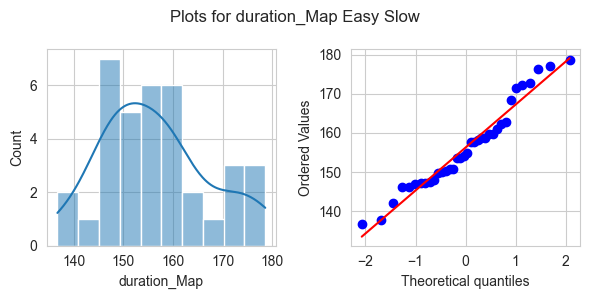

Shapiro-Wilk Test for duration_Map: p-value = 0.15071577496390087


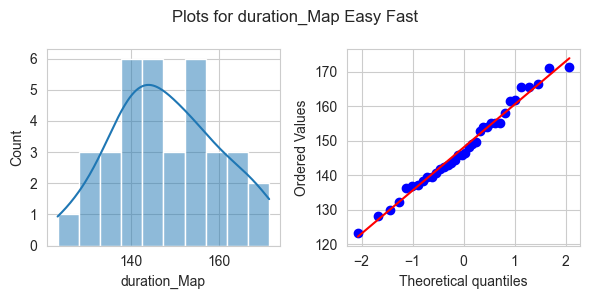

Shapiro-Wilk Test for duration_Map: p-value = 0.7694117569361842


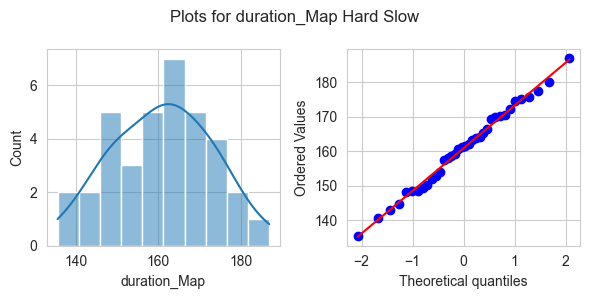

Shapiro-Wilk Test for duration_Map: p-value = 0.9892599960925312


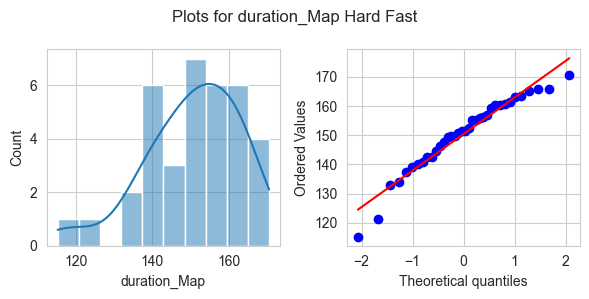

Shapiro-Wilk Test for duration_Map: p-value = 0.09334497365887093


In [78]:
# Check Normality
check_normality(aggregated_df, col, 'Easy Slow')
check_normality(aggregated_df, col, 'Easy Fast')
check_normality(aggregated_df, col, 'Hard Slow')
check_normality(aggregated_df, col, 'Hard Fast')

In [79]:
# Check Homoscedasticity
check_homoscedasticity(aggregated_df, 'difficulty', col)
check_homoscedasticity(aggregated_df, 'frequency', col)

difficulty: 	Test statistic = 0.2452, p-value = 0.6212
frequency: 	Test statistic = 0.1646, p-value = 0.6856


In [80]:
# Factorial AnovaRM
anova = AnovaRM(
    data=aggregated_df,
    depvar=col,    # Dependent variable
    subject='participant_id',          # Variable representing the subjects
    within=['difficulty', 'frequency'],# Within-subject factors
    aggregate_func='mean',
).fit()
anova.anova_table

F Value  Num DF  Den DF    Pr > F
difficulty             6.273776     1.0    17.0  0.022726
frequency             34.782661     1.0    17.0  0.000018
difficulty:frequency   0.734010     1.0    17.0  0.403502

In [81]:
# Post-hoc Pairwise Comparison (Bonferroni Correction)
posthoc_diff = pg.pairwise_tests(
    dv=col,
    within=['difficulty', 'frequency'],
    subject='participant_id',
    data=aggregated_df,
    padjust='bonf'
).rename(columns={'difficulty': 'Fixed'})
posthoc_freq = pg.pairwise_tests(
    dv=col,
    within=['frequency', 'difficulty'],
    subject='participant_id',
    data=aggregated_df,
    padjust='bonf'
).rename(columns={'frequency': 'Fixed'})
posthoc = pd.concat([posthoc_diff.tail(4), posthoc_freq.tail(2)])
posthoc

Contrast Fixed     A     B Paired Parametric         T   dof  \
0              difficulty     -  Easy  Hard   True       True -2.504751  17.0   
1               frequency     -  Slow  Fast   True       True  5.897683  17.0   
2  difficulty * frequency  Easy  Slow  Fast   True       True  4.142058  17.0   
3  difficulty * frequency  Hard  Slow  Fast   True       True  4.925983  17.0   
2  frequency * difficulty  Slow  Easy  Hard   True       True -2.169597  17.0   
3  frequency * difficulty  Fast  Easy  Hard   True       True -1.408894  17.0   

  alternative     p-unc    p-corr p-adjust      BF10    hedges  
0   two-sided  0.022726       NaN      NaN     2.698 -0.339723  
1   two-sided  0.000018       NaN      NaN  1332.905  0.901130  
2   two-sided  0.000682  0.001364     bonf     52.14  0.741629  
3   two-sided  0.000128  0.000256     bonf   226.559  0.930748  
2   two-sided  0.044502  0.089005     bonf      1.58 -0.423427  
3   two-sided  0.176895  0.353790     bonf     0.566 -0.205486

##### Fixation Count - Description

In [82]:
# Prepare Dataset
col = 'fix_count_Description'
aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_84\2824293983.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()


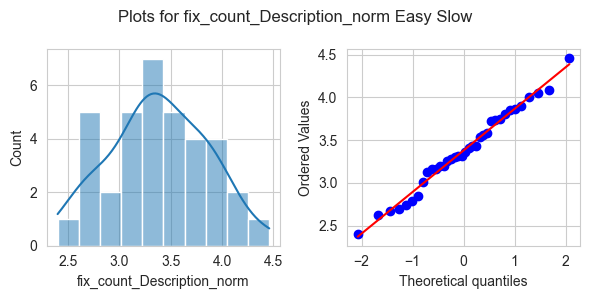

Shapiro-Wilk Test for fix_count_Description_norm: p-value = 0.9093380172403299


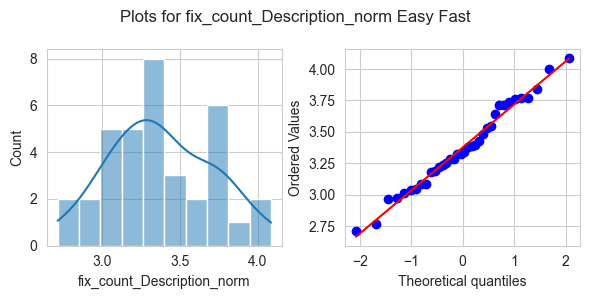

Shapiro-Wilk Test for fix_count_Description_norm: p-value = 0.7742971652727695


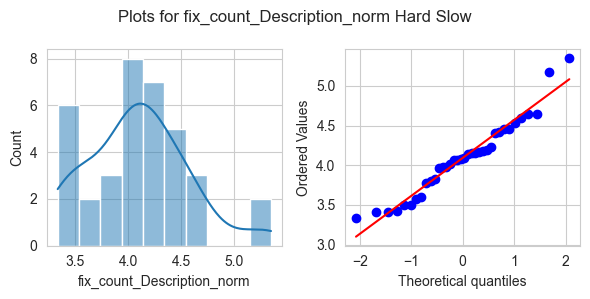

Shapiro-Wilk Test for fix_count_Description_norm: p-value = 0.14309106757593937


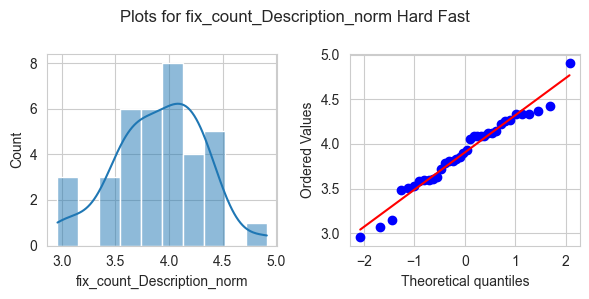

Shapiro-Wilk Test for fix_count_Description_norm: p-value = 0.4516288652048323


In [83]:
# Normalize (log) and Check Normality
aggregated_df[f'{col}_norm'] = np.log(aggregated_df[col] + 1)

check_normality(aggregated_df, f'{col}_norm', 'Easy Slow')
check_normality(aggregated_df, f'{col}_norm', 'Easy Fast')
check_normality(aggregated_df, f'{col}_norm', 'Hard Slow')
check_normality(aggregated_df, f'{col}_norm', 'Hard Fast')

In [84]:
# Check Homoscedasticity
check_homoscedasticity(aggregated_df, 'difficulty', f'{col}_norm')
check_homoscedasticity(aggregated_df, 'frequency', f'{col}_norm')

difficulty: 	Test statistic = 0.2944, p-value = 0.5882
frequency: 	Test statistic = 3.8911, p-value = 0.0505


In [85]:
# Factorial AnovaRM
anova = AnovaRM(
    data=aggregated_df,
    depvar=f'{col}_norm',    # Dependent variable
    subject='participant_id',          # Variable representing the subjects
    within=['difficulty', 'frequency'],# Within-subject factors
    aggregate_func='mean',
).fit()
anova.anova_table

F Value  Num DF  Den DF        Pr > F
difficulty            228.498228     1.0    17.0  2.739265e-11
frequency               3.305650     1.0    17.0  8.670703e-02
difficulty:frequency    7.452605     1.0    17.0  1.425433e-02

In [86]:
# Post-hoc Pairwise Comparison (Bonferroni Correction)
posthoc_diff = pg.pairwise_tests(
    dv=col,
    within=['difficulty', 'frequency'],
    subject='participant_id',
    data=aggregated_df,
    padjust='bonf'
).rename(columns={'difficulty': 'Fixed'})
posthoc_freq = pg.pairwise_tests(
    dv=col,
    within=['frequency', 'difficulty'],
    subject='participant_id',
    data=aggregated_df,
    padjust='bonf'
).rename(columns={'frequency': 'Fixed'})
posthoc = pd.concat([posthoc_diff.tail(2), posthoc_freq.tail(2)])
posthoc

Contrast Fixed     A     B Paired Parametric         T   dof  \
2  difficulty * frequency  Easy  Slow  Fast   True       True  0.838307  17.0   
3  difficulty * frequency  Hard  Slow  Fast   True       True  2.638870  17.0   
2  frequency * difficulty  Slow  Easy  Hard   True       True -7.023860  17.0   
3  frequency * difficulty  Fast  Easy  Hard   True       True -8.080392  17.0   

  alternative         p-unc        p-corr p-adjust       BF10    hedges  
2   two-sided  4.134907e-01  8.269814e-01     bonf      0.331  0.163674  
3   two-sided  1.723449e-02  3.446898e-02     bonf      3.378  0.593593  
2   two-sided  2.046775e-06  4.093550e-06     bonf   9294.187 -1.648294  
3   two-sided  3.184519e-07  6.369038e-07     bonf  5.072e+04 -1.583569

In [87]:
# Post-hoc Pairwise Comparison (Bonferroni Correction)
posthoc_diff = pg.pairwise_tests(
    dv=col,
    within=['difficulty', 'frequency'],
    subject='participant_id',
    data=aggregated_df,
    padjust='bonf'
).rename(columns={'difficulty': 'Fixed'})
posthoc_freq = pg.pairwise_tests(
    dv=col,
    within=['frequency', 'difficulty'],
    subject='participant_id',
    data=aggregated_df,
    padjust='bonf'
).rename(columns={'frequency': 'Fixed'})
posthoc = pd.concat([posthoc_diff.tail(4), posthoc_freq.tail(2)])
posthoc

Contrast Fixed     A     B Paired Parametric         T   dof  \
0              difficulty     -  Easy  Hard   True       True -9.092512  17.0   
1               frequency     -  Slow  Fast   True       True  2.502018  17.0   
2  difficulty * frequency  Easy  Slow  Fast   True       True  0.838307  17.0   
3  difficulty * frequency  Hard  Slow  Fast   True       True  2.638870  17.0   
2  frequency * difficulty  Slow  Easy  Hard   True       True -7.023860  17.0   
3  frequency * difficulty  Fast  Easy  Hard   True       True -8.080392  17.0   

  alternative         p-unc        p-corr p-adjust       BF10    hedges  
0   two-sided  6.126682e-08           NaN      NaN  2.302e+05 -1.813692  
1   two-sided  2.285319e-02           NaN      NaN      2.686  0.488622  
2   two-sided  4.134907e-01  8.269814e-01     bonf      0.331  0.163674  
3   two-sided  1.723449e-02  3.446898e-02     bonf      3.378  0.593593  
2   two-sided  2.046775e-06  4.093550e-06     bonf   9294.187 -1.648294  
3   two-sided  3.184519e-07  6.369038e-07     bonf  5.072e+04 -1.583569

##### Fixation Frequency - Ticket

In [88]:
# Prepare Dataset
col = 'fix_freq_Ticket'
aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_84\4091410213.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()


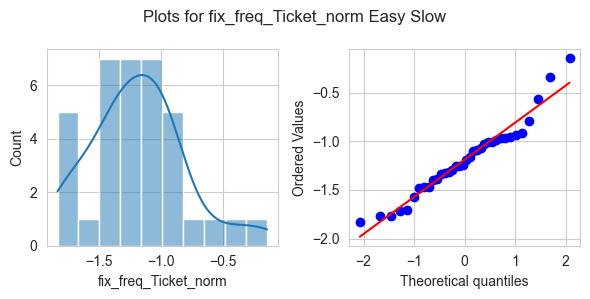

Shapiro-Wilk Test for fix_freq_Ticket_norm: p-value = 0.16196877787774533


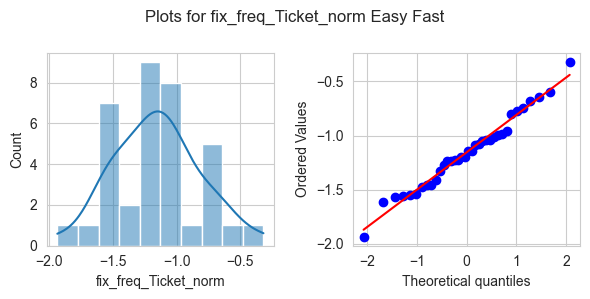

Shapiro-Wilk Test for fix_freq_Ticket_norm: p-value = 0.8687138372491306


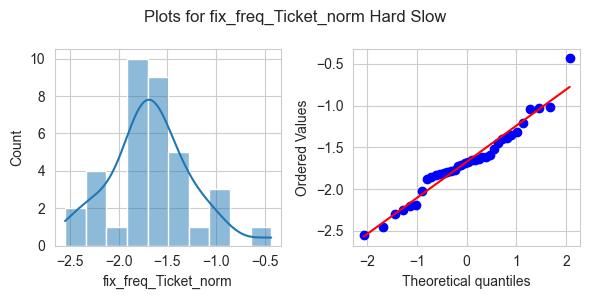

Shapiro-Wilk Test for fix_freq_Ticket_norm: p-value = 0.30907069238511586


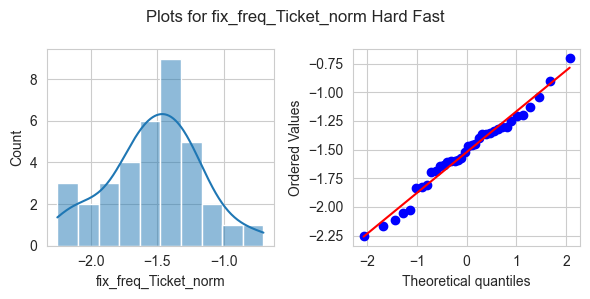

Shapiro-Wilk Test for fix_freq_Ticket_norm: p-value = 0.7738149886223064


In [89]:
# Normalize (log) and Check Normality
aggregated_df[f'{col}_norm'] = np.log(aggregated_df[col])

check_normality(aggregated_df, f'{col}_norm', 'Easy Slow')
check_normality(aggregated_df, f'{col}_norm', 'Easy Fast')
check_normality(aggregated_df, f'{col}_norm', 'Hard Slow')
check_normality(aggregated_df, f'{col}_norm', 'Hard Fast')

In [90]:
# Check Homoscedasticity
check_homoscedasticity(aggregated_df, 'difficulty', f'{col}_norm')
check_homoscedasticity(aggregated_df, 'frequency', f'{col}_norm')

difficulty: 	Test statistic = 0.3095, p-value = 0.5789
frequency: 	Test statistic = 2.4074, p-value = 0.1230


In [91]:
# Factorial AnovaRM
anova = AnovaRM(
    data=aggregated_df,
    depvar=f'{col}_norm',    # Dependent variable
    subject='participant_id',          # Variable representing the subjects
    within=['difficulty', 'frequency'],# Within-subject factors
    aggregate_func='mean',
).fit()
anova.anova_table

F Value  Num DF  Den DF        Pr > F
difficulty            185.136215     1.0    17.0  1.439371e-10
frequency               2.295213     1.0    17.0  1.481453e-01
difficulty:frequency    2.994283     1.0    17.0  1.016690e-01

In [92]:
# Post-hoc Pairwise Comparison (Bonferroni Correction)
posthoc_diff = pg.pairwise_tests(
    dv=col,
    within=['difficulty', 'frequency'],
    subject='participant_id',
    data=aggregated_df,
    padjust='bonf'
).rename(columns={'difficulty': 'Fixed'})
posthoc_freq = pg.pairwise_tests(
    dv=col,
    within=['frequency', 'difficulty'],
    subject='participant_id',
    data=aggregated_df,
    padjust='bonf'
).rename(columns={'frequency': 'Fixed'})
posthoc = pd.concat([posthoc_diff.tail(4), posthoc_freq.tail(2)])
posthoc

Contrast Fixed     A     B Paired Parametric         T   dof  \
0              difficulty     -  Easy  Hard   True       True  8.298896  17.0   
1               frequency     -  Slow  Fast   True       True -0.862867  17.0   
2  difficulty * frequency  Easy  Slow  Fast   True       True -0.255861  17.0   
3  difficulty * frequency  Hard  Slow  Fast   True       True -1.268191  17.0   
2  frequency * difficulty  Slow  Easy  Hard   True       True  6.241508  17.0   
3  frequency * difficulty  Fast  Easy  Hard   True       True  8.616347  17.0   

  alternative         p-unc        p-corr p-adjust       BF10    hedges  
0   two-sided  2.207198e-07           NaN      NaN  7.096e+04  1.170385  
1   two-sided  4.002204e-01           NaN      NaN      0.337 -0.150366  
2   two-sided  8.011283e-01  1.000000e+00     bonf       0.25 -0.040061  
3   two-sided  2.218230e-01  4.436459e-01     bonf      0.485 -0.297875  
2   two-sided  8.944389e-06  1.788878e-05     bonf   2445.581  1.101458  
3   two-sided  1.309749e-07  2.619497e-07     bonf  1.145e+05  1.043295

##### Time-to-1st Fix - Diagnostics *

In [93]:
# Prepare Dataset
col = 'time_1st_fix_Diagnostics'
aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_84\3929839579.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()


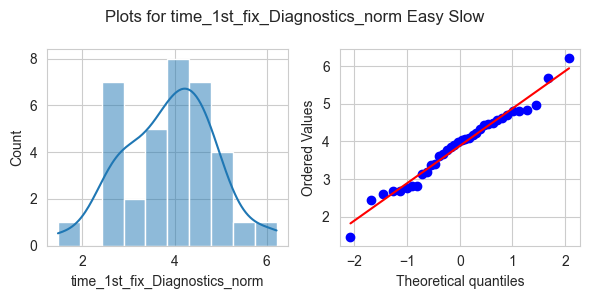

Shapiro-Wilk Test for time_1st_fix_Diagnostics_norm: p-value = 0.773019024693324


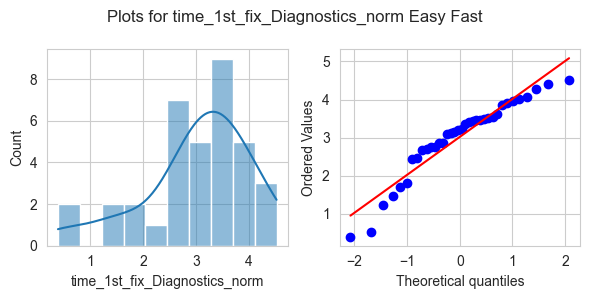

Shapiro-Wilk Test for time_1st_fix_Diagnostics_norm: p-value = 0.011521836976312446


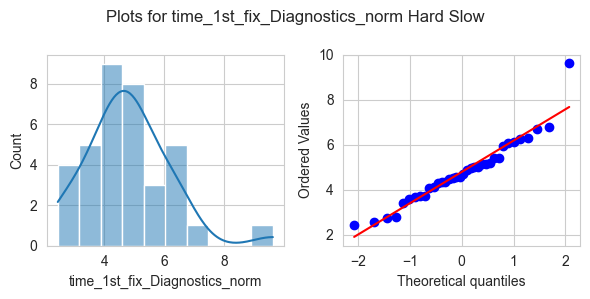

Shapiro-Wilk Test for time_1st_fix_Diagnostics_norm: p-value = 0.03850741311497693


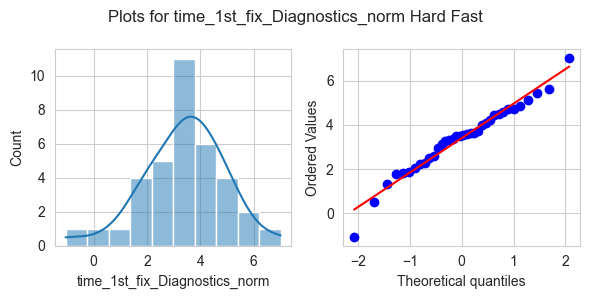

Shapiro-Wilk Test for time_1st_fix_Diagnostics_norm: p-value = 0.6111275860361294


In [94]:
# Normalize (boxcox) and Check Normality
aggregated_df[f'{col}_norm'], _ = stats.boxcox(aggregated_df[col])

check_normality(aggregated_df, f'{col}_norm', 'Easy Slow')
check_normality(aggregated_df, f'{col}_norm', 'Easy Fast')
check_normality(aggregated_df, f'{col}_norm', 'Hard Slow')
check_normality(aggregated_df, f'{col}_norm', 'Hard Fast')

In [95]:
# Check Homoscedasticity
check_homoscedasticity(aggregated_df, 'difficulty', f'{col}_norm')
check_homoscedasticity(aggregated_df, 'frequency', f'{col}_norm')

difficulty: 	Test statistic = 6.7521, p-value = 0.0104
frequency: 	Test statistic = 0.0000, p-value = 0.9953


In [96]:
# ANOVA Results (from R) 
print("Analysis of Variance of Aligned Rank Transformed Data")
print("\nTable Type: Analysis of Deviance Table (Type III Wald F tests with Kenward-Roger df)")
print("Model: Mixed Effects (lmer)")
print("Response: art(time_1st_fix_Diagnostics_norm)")
print("\n| Effect                 | F-value | df | df.residual | Pr(>F)   |")
print("|------------------------|---------|----|-------------|----------|")
print("| Difficulty             | 12.515  | 1  | 123         | 5.70e-04 | ***")
print("| Frequency              | 39.745  | 1  | 123         | 4.72e-09 | ***")
print("| Difficulty:Frequency   |  1.838  | 1  | 123         | 0.17769  | ")
print("---")
print("Signif. codes:   0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1")

Analysis of Variance of Aligned Rank Transformed Data

Table Type: Analysis of Deviance Table (Type III Wald F tests with Kenward-Roger df)
Model: Mixed Effects (lmer)
Response: art(time_1st_fix_Diagnostics_norm)

| Effect                 | F-value | df | df.residual | Pr(>F)   |
|------------------------|---------|----|-------------|----------|
| Difficulty             | 12.515  | 1  | 123         | 5.70e-04 | ***
| Frequency              | 39.745  | 1  | 123         | 4.72e-09 | ***
| Difficulty:Frequency   |  1.838  | 1  | 123         | 0.17769  | 
---
Signif. codes:   0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


##### Visit Count - Actions *

In [97]:
# Prepare Dataset
col = 'visit_count_Actions'
aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_84\73506981.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()


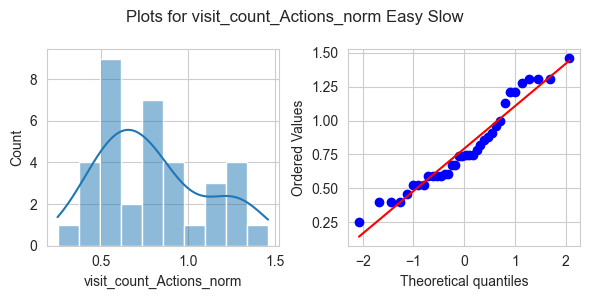

Shapiro-Wilk Test for visit_count_Actions_norm: p-value = 0.05584589421927798


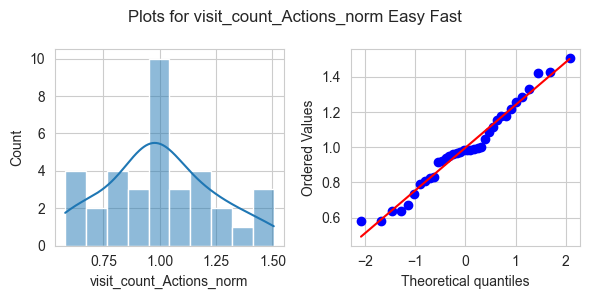

Shapiro-Wilk Test for visit_count_Actions_norm: p-value = 0.4530166957405741


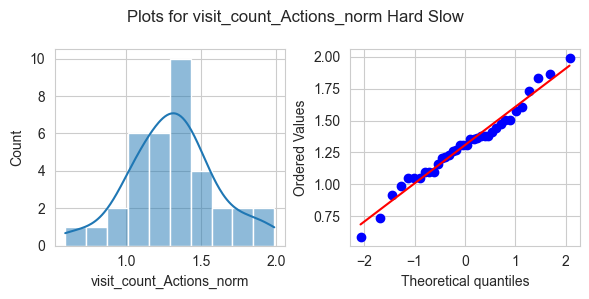

Shapiro-Wilk Test for visit_count_Actions_norm: p-value = 0.7525060244447508


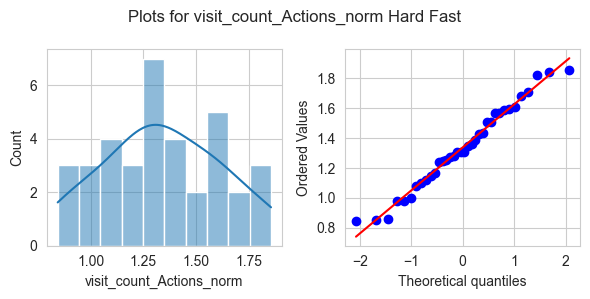

Shapiro-Wilk Test for visit_count_Actions_norm: p-value = 0.5234831105481639


In [98]:
# Normalize (boxcox) and Check Normality
aggregated_df[f'{col}_norm'], _ = stats.boxcox(aggregated_df[col])

check_normality(aggregated_df, f'{col}_norm', 'Easy Slow')
check_normality(aggregated_df, f'{col}_norm', 'Easy Fast')
check_normality(aggregated_df, f'{col}_norm', 'Hard Slow')
check_normality(aggregated_df, f'{col}_norm', 'Hard Fast')

In [99]:
# Check Homoscedasticity
check_homoscedasticity(aggregated_df, 'difficulty', f'{col}_norm')
check_homoscedasticity(aggregated_df, 'frequency', f'{col}_norm')

difficulty: 	Test statistic = 0.5892, p-value = 0.4440
frequency: 	Test statistic = 5.8671, p-value = 0.0167


In [100]:
# ANOVA Results (from R) 
print("Analysis of Variance of Aligned Rank Transformed Data")
print("\nTable Type: Analysis of Deviance Table (Type III Wald F tests with Kenward-Roger df)")
print("Model: Mixed Effects (lmer)")
print("Response: art(visit_count_Actions_norm)")
print("\n| Effect                 | F-value | df | df.residual | Pr(>F)   |")
print("|------------------------|---------|----|-------------|----------|")
print("| Difficulty             | 183.598 | 1  | 123         | 2.22e-16 | ***")
print("| Frequency              |  17.071 | 1  | 123         | 6.60e-05 | ***")
print("| Difficulty:Frequency   |   9.628 | 1  | 123         | 0.00238  |  **")
print("---")
print("Signif. codes:   0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1")

Analysis of Variance of Aligned Rank Transformed Data

Table Type: Analysis of Deviance Table (Type III Wald F tests with Kenward-Roger df)
Model: Mixed Effects (lmer)
Response: art(visit_count_Actions_norm)

| Effect                 | F-value | df | df.residual | Pr(>F)   |
|------------------------|---------|----|-------------|----------|
| Difficulty             | 183.598 | 1  | 123         | 2.22e-16 | ***
| Frequency              |  17.071 | 1  | 123         | 6.60e-05 | ***
| Difficulty:Frequency   |   9.628 | 1  | 123         | 0.00238  |  **
---
Signif. codes:   0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [101]:
# Post-hoc Comparisons (from R)
# interaction
print("\n\n= Interaction Effect (Difficulty × Frequency) =")
print("| Contrast                | Estimate | SE   | df  | t.ratio | p.value |")
print("|-------------------------|----------|------|-----|---------|---------|")
print("| Easy,Fast vs Easy,Slow  |  20.21   | 5.16 | 123 |   3.920  | 0.0008  | ***")
print("| Easy,Fast vs Hard,Fast  | -41.68   | 5.16 | 123 |  -8.085  | <.0001  | ***")
print("| Easy,Fast vs Hard,Slow  | -38.53   | 5.16 | 123 |  -7.474  | <.0001  | ***")
print("| Easy,Slow vs Hard,Fast  | -61.89   | 5.16 | 123 | -12.005  | <.0001  | ***")
print("| Easy,Slow vs Hard,Slow  | -58.74   | 5.16 | 123 | -11.394  | <.0001  | ***")
print("| Hard,Fast vs Hard,Slow  |   3.15   | 5.16 | 123 |   0.612  | 0.9282  |    ")
print("\nDegrees-of-freedom method: kenward-roger")
print("P value adjustment: tukey method for comparing a family of 4 estimates")



= Interaction Effect (Difficulty × Frequency) =
| Contrast                | Estimate | SE   | df  | t.ratio | p.value |
|-------------------------|----------|------|-----|---------|---------|
| Easy,Fast vs Easy,Slow  |  20.21   | 5.16 | 123 |   3.920  | 0.0008  | ***
| Easy,Fast vs Hard,Fast  | -41.68   | 5.16 | 123 |  -8.085  | <.0001  | ***
| Easy,Fast vs Hard,Slow  | -38.53   | 5.16 | 123 |  -7.474  | <.0001  | ***
| Easy,Slow vs Hard,Fast  | -61.89   | 5.16 | 123 | -12.005  | <.0001  | ***
| Easy,Slow vs Hard,Slow  | -58.74   | 5.16 | 123 | -11.394  | <.0001  | ***
| Hard,Fast vs Hard,Slow  |   3.15   | 5.16 | 123 |   0.612  | 0.9282  |    

Degrees-of-freedom method: kenward-roger
P value adjustment: tukey method for comparing a family of 4 estimates


In [102]:
# Post-hoc Pairwise Comparison Results
print("Post-hoc Pairwise Comparisons for Difficulty × Frequency Interaction \n")
print("| Contrast                | Fixed | A    | B    | Paired | Parametric | T       | dof | p-corr   | p-adjust | ")
print("|-------------------------|-------|------|------|--------|------------|---------|-----|----------|----------| ")
print("| difficulty * frequency  | Easy  | Slow | Fast | True   | False      |  -3.920 | 123 | 0.00083  | tukey    | ***")
print("| difficulty * frequency  | Hard  | Slow | Fast | True   | False      |  -0.612 | 123 | 0.92823  | tukey    |    ")
print("|  frequency * difficulty | Slow  | Easy | Hard | True   | False      | -11.394 | 123 | 8.09e-14 | tukey    | ***")
print("|  frequency * difficulty | Fast  | Easy | Hard | True   | False      |  -8.085 | 123 | 3.08e-12 | tukey    | ***")

print("\nDegrees-of-freedom method: kenward-roger")
print("P value adjustment: bonferroni method for multiple comparisons")

Post-hoc Pairwise Comparisons for Difficulty × Frequency Interaction 

| Contrast                | Fixed | A    | B    | Paired | Parametric | T       | dof | p-corr   | p-adjust | 
|-------------------------|-------|------|------|--------|------------|---------|-----|----------|----------| 
| difficulty * frequency  | Easy  | Slow | Fast | True   | False      |  -3.920 | 123 | 0.00083  | tukey    | ***
| difficulty * frequency  | Hard  | Slow | Fast | True   | False      |  -0.612 | 123 | 0.92823  | tukey    |    
|  frequency * difficulty | Slow  | Easy | Hard | True   | False      | -11.394 | 123 | 8.09e-14 | tukey    | ***
|  frequency * difficulty | Fast  | Easy | Hard | True   | False      |  -8.085 | 123 | 3.08e-12 | tukey    | ***

Degrees-of-freedom method: kenward-roger
P value adjustment: bonferroni method for multiple comparisons


##### Visit Length - Description *

In [103]:
# Prepare Dataset
col = 'visit_len_Description'
aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_84\1245350867.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()


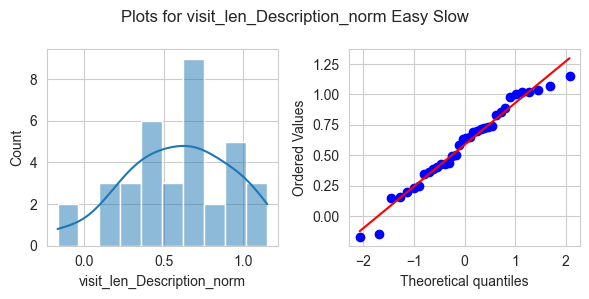

Shapiro-Wilk Test for visit_len_Description_norm: p-value = 0.39442567620731717


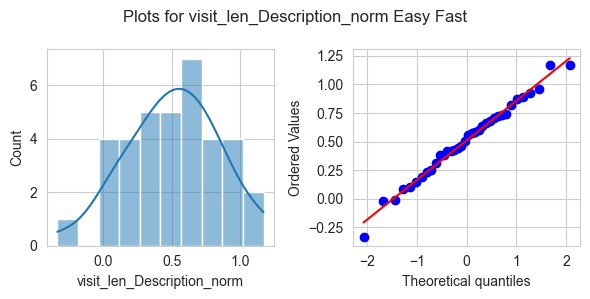

Shapiro-Wilk Test for visit_len_Description_norm: p-value = 0.9731578101789582


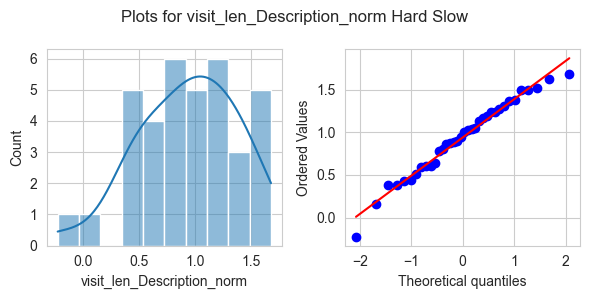

Shapiro-Wilk Test for visit_len_Description_norm: p-value = 0.6414702712201956


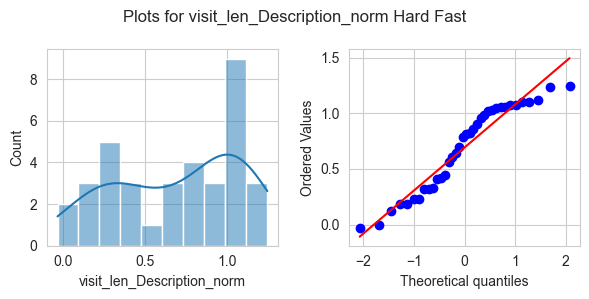

Shapiro-Wilk Test for visit_len_Description_norm: p-value = 0.01188577235442273


In [104]:
# Normalize (boxcox) and Check Normality
aggregated_df[f'{col}_norm'], _ = stats.boxcox(aggregated_df[col])

check_normality(aggregated_df, f'{col}_norm', 'Easy Slow')
check_normality(aggregated_df, f'{col}_norm', 'Easy Fast')
check_normality(aggregated_df, f'{col}_norm', 'Hard Slow')
check_normality(aggregated_df, f'{col}_norm', 'Hard Fast')

In [105]:
# Check Homoscedasticity
check_homoscedasticity(aggregated_df, 'difficulty', f'{col}_norm')
check_homoscedasticity(aggregated_df, 'frequency', f'{col}_norm')

difficulty: 	Test statistic = 4.2818, p-value = 0.0403
frequency: 	Test statistic = 0.7001, p-value = 0.4042


In [106]:
# ANOVA Results (from R) 
print("Analysis of Variance of Aligned Rank Transformed Data")
print("\nTable Type: Analysis of Deviance Table (Type III Wald F tests with Kenward-Roger df)")
print("Model: Mixed Effects (lmer)")
print("Response: art(visit_len_Description_norm)")
print("\n| Effect                 | F-value | df | df.residual | Pr(>F)   |")
print("|------------------------|---------|----|-------------|----------|")
print("| Difficulty             | 29.767  | 1  | 123         | 2.57e-07 | ***")
print("| Frequency              | 10.907  | 1  | 123         | 0.00125  |  **")
print("| Difficulty:Frequency   |  2.678  | 1  | 123         | 0.10428  |    ")
print("---")
print("Signif. codes:   0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1")

Analysis of Variance of Aligned Rank Transformed Data

Table Type: Analysis of Deviance Table (Type III Wald F tests with Kenward-Roger df)
Model: Mixed Effects (lmer)
Response: art(visit_len_Description_norm)

| Effect                 | F-value | df | df.residual | Pr(>F)   |
|------------------------|---------|----|-------------|----------|
| Difficulty             | 29.767  | 1  | 123         | 2.57e-07 | ***
| Frequency              | 10.907  | 1  | 123         | 0.00125  |  **
| Difficulty:Frequency   |  2.678  | 1  | 123         | 0.10428  |    
---
Signif. codes:   0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


##### Dwell_time - Ticket

In [107]:
# Prepare Dataset
col = 'dwell_pct_Ticket'
aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_84\1815151048.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()


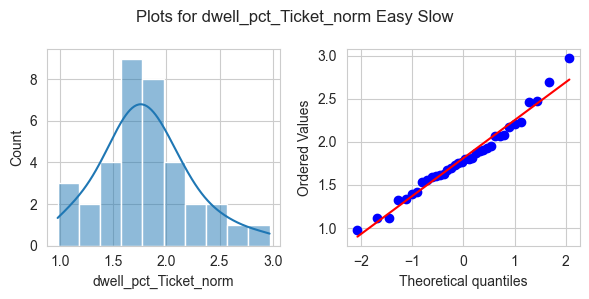

Shapiro-Wilk Test for dwell_pct_Ticket_norm: p-value = 0.6197200689958413


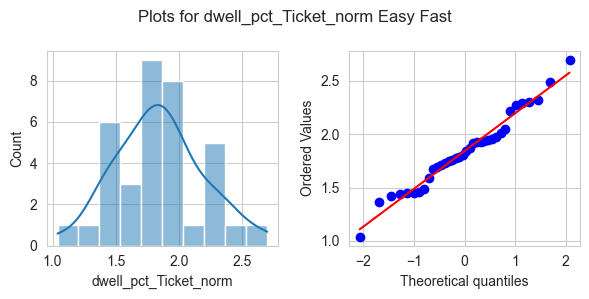

Shapiro-Wilk Test for dwell_pct_Ticket_norm: p-value = 0.6992331030849548


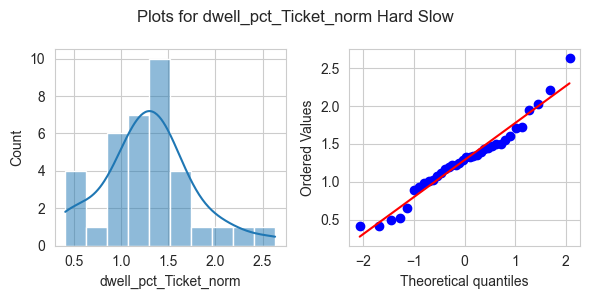

Shapiro-Wilk Test for dwell_pct_Ticket_norm: p-value = 0.28280325464587724


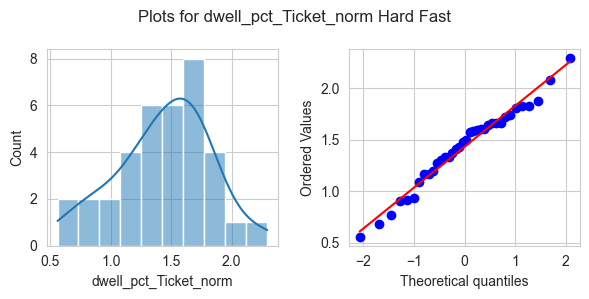

Shapiro-Wilk Test for dwell_pct_Ticket_norm: p-value = 0.6933461418495843


In [108]:
# Normalize (log) and Check Normality
aggregated_df[f'{col}_norm'] = np.log(aggregated_df[col])

check_normality(aggregated_df, f'{col}_norm', 'Easy Slow')
check_normality(aggregated_df, f'{col}_norm', 'Easy Fast')
check_normality(aggregated_df, f'{col}_norm', 'Hard Slow')
check_normality(aggregated_df, f'{col}_norm', 'Hard Fast')

In [109]:
# Check Homoscedasticity
check_homoscedasticity(aggregated_df, 'difficulty', f'{col}_norm')
check_homoscedasticity(aggregated_df, 'frequency', f'{col}_norm')

difficulty: 	Test statistic = 0.9803, p-value = 0.3238
frequency: 	Test statistic = 2.9868, p-value = 0.0861


In [110]:
# Factorial AnovaRM
anova = AnovaRM(
    data=aggregated_df,
    depvar=f'{col}_norm',    # Dependent variable
    subject='participant_id',          # Variable representing the subjects
    within=['difficulty', 'frequency'],# Within-subject factors
    aggregate_func='mean',
).fit()
anova.anova_table

F Value  Num DF  Den DF        Pr > F
difficulty            186.880045     1.0    17.0  1.337555e-10
frequency               1.806765     1.0    17.0  1.965612e-01
difficulty:frequency    2.603175     1.0    17.0  1.250573e-01

In [111]:
# Post-hoc Pairwise Comparison (Bonferroni Correction)
posthoc_diff = pg.pairwise_tests(
    dv=col,
    within=['difficulty', 'frequency'],
    subject='participant_id',
    data=aggregated_df,
    padjust='bonf'
).rename(columns={'difficulty': 'Fixed'})
posthoc_freq = pg.pairwise_tests(
    dv=col,
    within=['frequency', 'difficulty'],
    subject='participant_id',
    data=aggregated_df,
    padjust='bonf'
).rename(columns={'frequency': 'Fixed'})
posthoc = pd.concat([posthoc_diff.tail(4), posthoc_freq.tail(2)])
posthoc

Contrast Fixed     A     B Paired Parametric         T   dof  \
0              difficulty     -  Easy  Hard   True       True  8.112661  17.0   
1               frequency     -  Slow  Fast   True       True -0.485760  17.0   
2  difficulty * frequency  Easy  Slow  Fast   True       True  0.083177  17.0   
3  difficulty * frequency  Hard  Slow  Fast   True       True -0.973957  17.0   
2  frequency * difficulty  Slow  Easy  Hard   True       True  6.133701  17.0   
3  frequency * difficulty  Fast  Easy  Hard   True       True  8.250676  17.0   

  alternative         p-unc        p-corr p-adjust       BF10    hedges  
0   two-sided  3.015550e-07           NaN      NaN  5.332e+04  1.173731  
1   two-sided  6.333387e-01           NaN      NaN       0.27 -0.088047  
2   two-sided  9.346823e-01  1.000000e+00     bonf      0.244  0.013921  
3   two-sided  3.437338e-01  6.874677e-01     bonf      0.368 -0.229702  
2   two-sided  1.103155e-05  2.206310e-05     bonf   2024.358  1.067913  
3   two-sided  2.391928e-07  4.783856e-07     bonf  6.592e+04  1.078708

##### Stationary Entropy

In [112]:
# Prepare Dataset
col = 'stat_entropy'
aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_84\3590772226.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])[col].mean().dropna().reset_index()


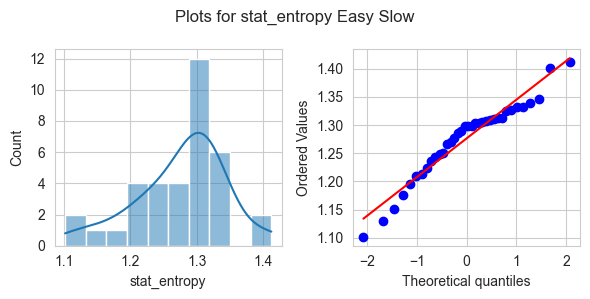

Shapiro-Wilk Test for stat_entropy: p-value = 0.0944326849743241


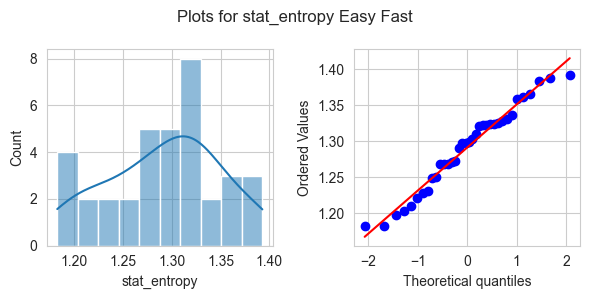

Shapiro-Wilk Test for stat_entropy: p-value = 0.3019543055181213


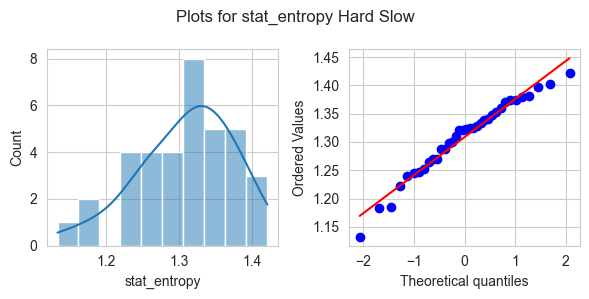

Shapiro-Wilk Test for stat_entropy: p-value = 0.33032635329787313


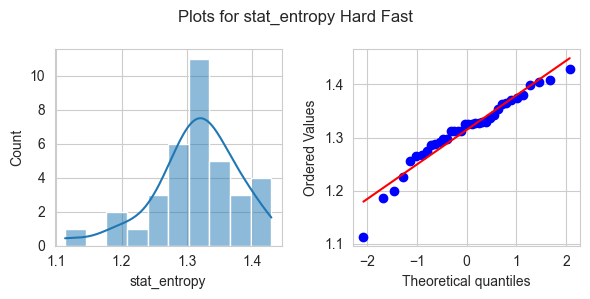

Shapiro-Wilk Test for stat_entropy: p-value = 0.08867592248394991


In [113]:
# Check Normality
check_normality(aggregated_df, col, 'Easy Slow')
check_normality(aggregated_df, col, 'Easy Fast')
check_normality(aggregated_df, col, 'Hard Slow')
check_normality(aggregated_df, col, 'Hard Fast')

In [114]:
# Check Homoscedasticity
check_homoscedasticity(aggregated_df, 'difficulty', col)
check_homoscedasticity(aggregated_df, 'frequency', col)

difficulty: 	Test statistic = 0.0003, p-value = 0.9865
frequency: 	Test statistic = 0.3216, p-value = 0.5715


In [115]:
# Factorial AnovaRM
anova = AnovaRM(
    data=aggregated_df,
    depvar=col,    # Dependent variable
    subject='participant_id',          # Variable representing the subjects
    within=['difficulty', 'frequency'],# Within-subject factors
    aggregate_func='mean',
).fit()
anova.anova_table

F Value  Num DF  Den DF    Pr > F
difficulty            13.798789     1.0    17.0  0.001722
frequency              1.187228     1.0    17.0  0.291094
difficulty:frequency   0.411138     1.0    17.0  0.529943

In [116]:
# Post-hoc Pairwise Comparison (Bonferroni Correction)
posthoc_diff = pg.pairwise_tests(
    dv=col,
    within=['difficulty', 'frequency'],
    subject='participant_id',
    data=aggregated_df,
    padjust='bonf'
).rename(columns={'difficulty': 'Fixed'})
posthoc_freq = pg.pairwise_tests(
    dv=col,
    within=['frequency', 'difficulty'],
    subject='participant_id',
    data=aggregated_df,
    padjust='bonf'
).rename(columns={'frequency': 'Fixed'})
posthoc = pd.concat([posthoc_diff.tail(4), posthoc_freq.tail(2)])
posthoc

Contrast Fixed     A     B Paired Parametric         T   dof  \
0              difficulty     -  Easy  Hard   True       True -3.714672  17.0   
1               frequency     -  Slow  Fast   True       True -1.089600  17.0   
2  difficulty * frequency  Easy  Slow  Fast   True       True -1.214593  17.0   
3  difficulty * frequency  Hard  Slow  Fast   True       True -0.484417  17.0   
2  frequency * difficulty  Slow  Easy  Hard   True       True -2.720489  17.0   
3  frequency * difficulty  Fast  Easy  Hard   True       True -2.547406  17.0   

  alternative     p-unc    p-corr p-adjust    BF10    hedges  
0   two-sided  0.001722       NaN      NaN  23.396 -0.535073  
1   two-sided  0.291094       NaN      NaN   0.407 -0.196994  
2   two-sided  0.241124  0.482247     bonf   0.459 -0.278968  
3   two-sided  0.634272  1.000000     bonf    0.27 -0.093559  
2   two-sided  0.014539  0.029078     bonf   3.882 -0.558876  
3   two-sided  0.020821  0.041641     bonf   2.896 -0.393494

##### ART Analysis

In [117]:
# Prepare Dataset
# time_1st fix
time_1st_fix_aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])['time_1st_fix_Diagnostics'].mean().dropna().reset_index()
time_1st_fix_aggregated_df['time_1st_fix_Diagnostics_norm'], _ = stats.boxcox(time_1st_fix_aggregated_df['time_1st_fix_Diagnostics'])

# visit_count
visit_count_aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])['visit_count_Actions'].mean().dropna().reset_index()
visit_count_aggregated_df['visit_count_Actions_norm'], _ = stats.boxcox(visit_count_aggregated_df['visit_count_Actions'])

# visit_len
visit_len_aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])['visit_len_Description'].mean().dropna().reset_index()
visit_len_aggregated_df['visit_len_Description_norm'], _ = stats.boxcox(visit_len_aggregated_df['visit_len_Description'])

# merge
rq2_art_df = pd.merge(time_1st_fix_aggregated_df, visit_count_aggregated_df, on=['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])
rq2_art_df = pd.merge(rq2_art_df, visit_len_aggregated_df, on=['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])

C:\Users\vale_ad\AppData\Local\Temp\ipykernel_84\1708314726.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_1st_fix_aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])['time_1st_fix_Diagnostics'].mean().dropna().reset_index()
C:\Users\vale_ad\AppData\Local\Temp\ipykernel_84\1708314726.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  visit_count_aggregated_df = df_long_expanded.groupby(['participant_id', 'condition', 'difficulty', 'frequency', 'instance'])['visit_count_Actions'].mean().dropna().reset_index()
C:\Users\vale_ad\AppData\Local

In [118]:
# Export Data in .csv
rq2_art_df.to_csv('./aoi_data/RQ2_ART_data.csv')

### 6. Results

##### RQ1 Features

In [4]:
# ANOVAs Table
anova_data = {
    'Metric': ['Fix Duration', 'Fix Frequency', 'Time-to-1st Fix', 'Visit Frequency', 'Dwell Time', 'Stat Entropy'],
    'Area': ['Description', 'Actions', 'Actions', 'Ticket', 'Ticket', '-'],
    # 'RQ1 Hypothesis': ['Positive', 'Positive', 'Positive', 'Negative', 'Positive', 'Negative'],
    'Diff_Relation': ['Negative' ,'Positive' ,'Positive', 'Negative', 'Negative', 'Positive'],
    'Diff_effect': [-0.320374, 0.525558, 0.432407, -1.343591, -1.173731, 0.535073],
    'Diff_p-value': [0.0116, 0.0012, 0.0230, 5.332291e-08, 1.337555e-10, 0.0017],
    'Diff_Significance': ['  *', ' **', '  *', '***', '***', ' **'],
    'Freq_Relation': ['Negative', 'Positive' ,'Negative' ,'Positive','Positive', 'Positive'],
    'Freq_effect': [-0.184590, .429693, -0.857494, 0.570444, 0.088047, 0.196994],
    'Freq_p-value': [0.0905, 0.0057, 0.0015, 1.875360e-03, 0.1966, 0.2911],
    'Freq_Significance': ['  -', ' **', ' **', ' **', '   ', '   '],
    'Int_p-value': [0.0317, 0.3674, 0.3392, 8.592027e-01, 0.1251, 0.5299],
    'Int_Significance': ['  *', '   ', '   ', '   ', '   ', '   '],
}

df_anova = pd.DataFrame(anova_data)
df_anova.columns = pd.MultiIndex.from_tuples([
    ('', 'Metric'), ('', 'Area'), #('', 'RQ1 Hypothesis'),
    ('Difficulty', 'Relation'), ('Difficulty', 'Effect Size'), ('Difficulty', 'p-value'), ('Difficulty', ''),
    ('Frequency', 'Relation'), ('Frequency', 'Effect Size'), ('Frequency', 'p-value'), ('Frequency', ''),
    ('Interaction', 'p-value'), ('Interaction', '')
])

df_anova.style.format({
    ('Difficulty', 'Effect Size'): lambda x: "{:.4f}".format(x) if isinstance(x, (float)) else x,
    ('Difficulty', 'p-value'): lambda x: "{:.1e}".format(x) if x < 0.001 else "{:.4f}".format(x),
    ('Frequency', 'Effect Size'): lambda x: "{:.4f}".format(x) if isinstance(x, (float)) else x,
    ('Frequency', 'p-value'): lambda x: "{:.1e}".format(x) if x < 0.001 else "{:.4f}".format(x),
    ('Interaction', 'p-value'): lambda x: "{:.1e}".format(x) if x < 0.001 else "{:.4f}".format(x),
}).set_caption("Combined Factorial AnovaRM Results for RQ2"
).set_table_styles({
    ('Difficulty', 'Relation'): [{'selector': 'th', 'props': [('text-align', 'left')]}],
    ('Frequency', 'Relation'): [{'selector': 'th', 'props': [('text-align', 'left')]}],
    ('Interaction', 'p-value'): [{'selector': 'th', 'props': [('text-align', 'left')]}],
}, overwrite=False)

In [25]:
# Post-hoc Comparison Table
post_hoc_data = {
    'Contrast': ['difficulty * frequency', 'difficulty * frequency', 'difficulty * frequency', 'difficulty * frequency'],
    'Fixed': ['Easy', 'Hard', 'Slow', 'Fast'],
    'A': ['Slow', 'Slow', 'Easy', 'Easy'],
    'B': ['Fast' ,'Fast' ,'Hard' ,'Hard'],
    'Dur_p-adjust': ['bonf', 'bonf', 'bonf', 'bonf'],
    'Dur_p-value': [1.0, 0.006811, 1.0, 0.000093],
    'Dur_Significance': ['   ', ' **', '   ', '***'],
    'Count_p-adjust': ['bonf', 'bonf', 'bonf', 'bonf'],
    'Count_p-value': [8.269814e-01, 3.446898e-02, 4.093550e-06, 6.369038e-07],
    'Count_Significance': ['   ', '  *', '***', '***'],
}

df_posthoc = pd.DataFrame(post_hoc_data)
df_posthoc.columns = pd.MultiIndex.from_tuples([
    ('', 'Contrast'), ('', 'Fixed'), ('', 'A'), ('', 'B'),
    ('Fix Duration', 'p-adjust'), ('Fix Duration', 'p-corr'), ('Fix Duration', ''),
    ('Fix Count', 'p-adjust'), ('Fix Count', 'p-corr'), ('Fix Count', ''),
])

df_posthoc.style.format({
    ('Fix Duration', 'p-corr'): lambda x: "{:.1e}".format(x) if x < 0.001 else "{:.4f}".format(x),
    ('Fix Count', 'p-corr'): lambda x: "{:.1e}".format(x) if x < 0.001 else "{:.4f}".format(x),
}).set_caption("Post-hoc Comparison for RQ2"
).set_table_styles({
    ('Fix Duration', 'p-adjust'): [{'selector': 'th', 'props': [('text-align', 'left')]}],
    ('Fix Count', 'p-adjust'): [{'selector': 'th', 'props': [('text-align', 'left')]}],
}, overwrite=False)

##### New features

In [26]:
# Build Table
anova_data = {
    'Metric': ['Fix Duration', 'Fix Count', 'Fix Frequency', '(*) Time-to-1st Fix', '(*) Visit Count', '(*) Visit Length', 'Dwell Time', 'Stat Entropy'],
    'Area': ['Map', 'Description', 'Ticket', 'Diagnostics', 'Actions', 'Description', 'Ticket', '-'],
    'Diff_Relation': ['Positive' ,'Positive' ,'Negative' ,'Positive' ,'Positive' ,'Positive' , 'Negative', 'Positive'],
    'Diff_effect': [0.339723, 1.813692, -1.170385, '-', '-', '-', -1.173731, 0.535073],
    'Diff_p-value': [0.022726, 	2.739265e-11, 	1.439371e-10, 5.70e-04, 2.22e-16, 2.57e-07, 1.337555e-10, 0.001722],
    'Diff_Significance': ['  *', '***', '***', '***', '***', '***', '***', ' **'],
    'Freq_Relation': ['Negative' ,'Negative', '-' ,'Negative' ,'Positive' ,'Negative', '-', '-'],
    'Freq_effect': [-0.901130, -0.488622, 0.150366, '-', '-', '-', 0.088047, 0.196994],
    'Freq_p-value': [0.000018, 	8.670703e-02, 1.481453e-01, 4.72e-09, 6.60e-05, 0.00125, 1.965612e-01, 0.291094],
    'Freq_Significance': ['***', '  -', '   ', '***', '***', ' **', '   ', '   '],
    'Int_p-value': [0.403502, 1.425433e-02, 1.016690e-01, 0.17769, 0.00238, 0.10428, 1.250573e-01, 0.529943],
    'Int_Significance': ['   ', '  *', '   ', '   ', ' **', '   ', '   ', '   '],
}

df_anova = pd.DataFrame(anova_data)
df_anova.columns = pd.MultiIndex.from_tuples([
    ('', 'Metric'), ('', 'Area'),
    ('Difficulty', 'Relation'), ('Difficulty', 'Effect Size'), ('Difficulty', 'p-value'), ('Difficulty', ''),
    ('Frequency', 'Relation'), ('Frequency', 'Effect Size'), ('Frequency', 'p-value'), ('Frequency', ''),
    ('Interaction', 'p-value'), ('Interaction', '')
])

df_anova.style.format({
    ('Difficulty', 'Effect Size'): lambda x: "{:.4f}".format(x) if isinstance(x, (float)) else x,
    ('Difficulty', 'p-value'): lambda x: "{:.1e}".format(x) if x < 0.001 else "{:.4f}".format(x),
    ('Frequency', 'Effect Size'): lambda x: "{:.4f}".format(x) if isinstance(x, (float)) else x,
    ('Frequency', 'p-value'): lambda x: "{:.1e}".format(x) if x < 0.001 else "{:.4f}".format(x),
    ('Interaction', 'p-value'): lambda x: "{:.1e}".format(x) if x < 0.001 else "{:.4f}".format(x),
}).set_caption("Combined Factorial AnovaRM Results for RQ2"
).set_table_styles({
    ('Difficulty', 'Relation'): [{'selector': 'th', 'props': [('text-align', 'left')]}],
    ('Frequency', 'Relation'): [{'selector': 'th', 'props': [('text-align', 'left')]}],
    ('Interaction', 'p-value'): [{'selector': 'th', 'props': [('text-align', 'left')]}],
}, overwrite=False)

In [27]:
# Post-hoc Comparison Table
post_hoc_data = {
    'Contrast': ['difficulty * frequency', 'difficulty * frequency', 'difficulty * frequency', 'difficulty * frequency'],
    'Fixed': ['Easy', 'Hard', 'Slow', 'Fast'],
    'A': ['Slow', 'Slow', 'Easy', 'Easy'],
    'B': ['Fast' ,'Fast' ,'Hard' ,'Hard'],
    'FixCount_p-adjust': ['bonf', 'bonf', 'bonf', 'bonf'],
    'FixCount_p-value': [8.269814e-01, 3.446898e-02, 4.093550e-06, 6.369038e-07],
    'FixCount_Significance': ['   ', '  *', '***', '***'],
    'VisitCount_p-adjust': ['tukey', 'tukey', 'tukey', 'tukey'],
    'VisitCount_p-value': [0.00083, 0.92823, 8.09e-14, 3.08e-12],
    'VisitCount_Significance': ['***', '   ', '***', '***'],
}

df_posthoc = pd.DataFrame(post_hoc_data)
df_posthoc.columns = pd.MultiIndex.from_tuples([
    ('', 'Contrast'), ('', 'Fixed'), ('', 'A'), ('', 'B'),
    ('Fix Count', 'p-adjust'), ('Fix Count', 'p-corr'), ('', ''),
    ('(*) Visit Count', 'p-adjust'), ('(*) Visit Count', 'p-corr'), ('', ''),
])

df_posthoc.style.format({
    ('Fix Count', 'p-corr'): lambda x: "{:.1e}".format(x) if x < 0.001 else "{:.4f}".format(x),
    ('(*) Visit Count', 'p-corr'): lambda x: "{:.1e}".format(x) if x < 0.001 else "{:.4f}".format(x),
}).set_caption("Post-hoc Comparison for RQ2")